In [1]:
# Import necessay library
import pandas as pd
import numpy as np

import functools
from scipy.stats import kurtosis, skew
from itertools import product
import scipy.optimize as sco
import itertools
import random

# matplotlib for plotting
import matplotlib.pyplot as plt

# Suppress warnings from pandas !pip install numpy==1.16.1
import warnings
warnings.filterwarnings('ignore')

# Memory management
import gc

# GARCH model for estimation
from arch import arch_model # FOR garch volatility estimate, IF YOU NOT YET HAVE ARCH MODULE, YOU NEED TO INSTALL IT BY THIS COMMAND "!pip install arch"

# set working directory
import os
# os.chdir('C:\\Users\\18183432\\OneDrive - LA TROBE UNIVERSITY\\Python\\trading strategy\\S&P 500 e-Mini futures') # 18183432
# os.chdir('C:\Users\Owner\OneDrive - LA TROBE UNIVERSITY\Python\trading strategy\S&P 500 e-Mini futures') # Laptop
# os.chdir('C:\\Users\\Phong\\OneDrive - LA TROBE UNIVERSITY\\Python\\trading strategy\\S&P 500 e-Mini futures') # Trusting social

import os
cwd = os.getcwd()
print(cwd)

from datetime import timedelta 
# Set the numbers of columns display
pd.set_option('display.max_columns', 100)


def drawdown (final):
    '''
    function to calculate drawdown of security/portfolio
    
    Input:
        final: return serires of security/portfolio
    Output:
        drawdown of portfolio
    '''
    cum_rets = (1 + final).cumprod()
    drawdown =  -(1-cum_rets.div(cum_rets.cummax()))
     
    return drawdown

C:\Users\Owner\OneDrive - LA TROBE UNIVERSITY\Python\trading strategy\S&P 500 e-Mini futures


In [2]:
# Read the data of future S&P 500 e-Mini futures (we have total 10 year = 41 contracts) 
data = pd.read_csv('SP500_emini_futures_data.csv')
data['Time'] = pd.to_datetime(data['Time'], format=('%d/%m/%Y'))
# Read the SP500 index, choose the start_date for SP500 = 6 years before start_date S&P 500 e-Mini futures (to calculate volatility regime)
sp500 = pd.read_csv('SP500_index.csv', parse_dates =['Date'])[['Date','Adj Close']]
sp500.columns = ['Time', 'SP500_index']
sp500['Time'] = pd.to_datetime(sp500['Time'], format=('%Y/%m/%d'))
start_date = data['Time'][0]- timedelta(365*6)
sp500 = sp500[sp500['Time']>start_date]

In [3]:
### Calculate GARCH volatility with 3 years window (=3*252 days) based on SP500_index
window = 252*3
forecast_horizon=1
update_regime =5

sp500['ret'] =  sp500['SP500_index'].astype(float).pct_change()*100
ret = np.array(sp500['ret'].dropna())

predictions =[]
realized_vars =[]
price_minus_window = sp500.iloc[window:,:].reset_index().drop(columns = ['index'])
# price_minus_window = price_minus_window.reset_index().drop(columns = ['index'])
for i in range(len(ret)-window+1): # i = 1
    ret1 = np.array(ret[i:i+window])# len(ret1)
    # Record realized variance for comparison with forecast values
    realized_var = np.var(ret1)
    realized_vars.append(realized_var)
    # set up GARCH model
    model = arch_model(ret1, mean='Zero', vol='GARCH', p=1, q=1)#
    # fit model
    model_fit = model.fit()
    
    # Record forecast values of Variance
    prediction = model_fit.forecast(horizon=forecast_horizon).variance.values[-1]
    predictions.append(np.mean(prediction))

# put the variance and relized variance into data frame   
price_minus_window ['forecasted_variance'] = np.array(predictions, float) 
price_minus_window ['realized_vars'] = realized_vars
# calculate the median of rolling-3-year window variance
price_minus_window['median_forecast_variance'] = price_minus_window['forecasted_variance'].rolling(window).median()
# eleminate NA values
price_minus_window = price_minus_window.dropna().reset_index().drop(columns = ['index'])

Iteration:      1,   Func. Count:      5,   Neg. LLF: 944.6156845448397
Iteration:      2,   Func. Count:     12,   Neg. LLF: 941.7049403874635
Iteration:      3,   Func. Count:     18,   Neg. LLF: 941.2307826598623
Iteration:      4,   Func. Count:     24,   Neg. LLF: 940.4497308882055
Iteration:      5,   Func. Count:     30,   Neg. LLF: 939.8194128713095
Iteration:      6,   Func. Count:     36,   Neg. LLF: 939.2906619841905
Iteration:      7,   Func. Count:     42,   Neg. LLF: 938.840198566243
Iteration:      8,   Func. Count:     48,   Neg. LLF: 938.4612636996588
Iteration:      9,   Func. Count:     54,   Neg. LLF: 938.138968057222
Iteration:     10,   Func. Count:     60,   Neg. LLF: 937.8841232638521
Iteration:     11,   Func. Count:     66,   Neg. LLF: 937.664184688031
Iteration:     12,   Func. Count:     72,   Neg. LLF: 937.490873844871
Iteration:     13,   Func. Count:     78,   Neg. LLF: 937.3244417789474
Iteration:     14,   Func. Count:     84,   Neg. LLF: 937.0045763902

Iteration:     23,   Func. Count:    137,   Neg. LLF: 926.9486090693324
Iteration:     24,   Func. Count:    142,   Neg. LLF: 926.0531900541952
Iteration:     25,   Func. Count:    148,   Neg. LLF: 926.0310617365367
Iteration:     26,   Func. Count:    153,   Neg. LLF: 926.0243799307134
Iteration:     27,   Func. Count:    158,   Neg. LLF: 926.0234538454688
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 926.0234532409148
            Iterations: 27
            Function evaluations: 159
            Gradient evaluations: 27
Iteration:      1,   Func. Count:      5,   Neg. LLF: 935.0465002121416
Iteration:      2,   Func. Count:     12,   Neg. LLF: 933.0477452724278
Iteration:      3,   Func. Count:     18,   Neg. LLF: 932.5413044331477
Iteration:      4,   Func. Count:     26,   Neg. LLF: 932.5173007277886
Iteration:      5,   Func. Count:     32,   Neg. LLF: 931.8282715649217
Iteration:      6,   Func. Count:     38,   Neg. LLF: 931.28459757887

Iteration:      2,   Func. Count:     13,   Neg. LLF: 918.6645266006608
Iteration:      3,   Func. Count:     19,   Neg. LLF: 918.1117906964942
Iteration:      4,   Func. Count:     25,   Neg. LLF: 917.0250405372927
Iteration:      5,   Func. Count:     31,   Neg. LLF: 916.625075835511
Iteration:      6,   Func. Count:     37,   Neg. LLF: 916.2185860935964
Iteration:      7,   Func. Count:     43,   Neg. LLF: 915.3114029068086
Iteration:      8,   Func. Count:     49,   Neg. LLF: 914.8936147978588
Iteration:      9,   Func. Count:     55,   Neg. LLF: 914.7133889543741
Iteration:     10,   Func. Count:     61,   Neg. LLF: 914.5345628720164
Iteration:     11,   Func. Count:     67,   Neg. LLF: 914.3960939595112
Iteration:     12,   Func. Count:     73,   Neg. LLF: 914.2905081291221
Iteration:     13,   Func. Count:     79,   Neg. LLF: 914.2054243406261
Iteration:     14,   Func. Count:     85,   Neg. LLF: 914.1121428084462
Iteration:     15,   Func. Count:     90,   Neg. LLF: 914.0595129

Iteration:      5,   Func. Count:     31,   Neg. LLF: 915.8169684623751
Iteration:      6,   Func. Count:     37,   Neg. LLF: 915.7157782090593
Iteration:      7,   Func. Count:     43,   Neg. LLF: 915.5782277534609
Iteration:      8,   Func. Count:     49,   Neg. LLF: 915.5036100315607
Iteration:      9,   Func. Count:     54,   Neg. LLF: 915.5003927717192
Iteration:     10,   Func. Count:     59,   Neg. LLF: 915.4976637852141
Iteration:     11,   Func. Count:     64,   Neg. LLF: 915.4976190348989
Iteration:     12,   Func. Count:     69,   Neg. LLF: 915.497610962509
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 915.4976109617894
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 917.7685736589427
Iteration:      2,   Func. Count:     13,   Neg. LLF: 917.1913709384141
Iteration:      3,   Func. Count:     19,   Neg. LLF: 916.7772345279947

Iteration:      2,   Func. Count:     13,   Neg. LLF: 909.4081516501348
Iteration:      3,   Func. Count:     19,   Neg. LLF: 908.9463301805512
Iteration:      4,   Func. Count:     25,   Neg. LLF: 908.0013276303416
Iteration:      5,   Func. Count:     31,   Neg. LLF: 907.6877526524335
Iteration:      6,   Func. Count:     37,   Neg. LLF: 907.3000812055571
Iteration:      7,   Func. Count:     43,   Neg. LLF: 907.1177572296432
Iteration:      8,   Func. Count:     49,   Neg. LLF: 906.9596817512922
Iteration:      9,   Func. Count:     55,   Neg. LLF: 906.8822733862252
Iteration:     10,   Func. Count:     60,   Neg. LLF: 906.8303954129296
Iteration:     11,   Func. Count:     66,   Neg. LLF: 906.7604683218976
Iteration:     12,   Func. Count:     72,   Neg. LLF: 906.748099355764
Iteration:     13,   Func. Count:     78,   Neg. LLF: 906.7325726557297
Iteration:     14,   Func. Count:     83,   Neg. LLF: 906.7310500143338
Iteration:     15,   Func. Count:     88,   Neg. LLF: 906.7307727

Iteration:     12,   Func. Count:     72,   Neg. LLF: 896.957604741435
Iteration:     13,   Func. Count:     79,   Neg. LLF: 896.951533008853
Iteration:     14,   Func. Count:     84,   Neg. LLF: 896.88858356859
Iteration:     15,   Func. Count:     89,   Neg. LLF: 896.8255353107435
Iteration:     16,   Func. Count:     94,   Neg. LLF: 896.822867732388
Iteration:     17,   Func. Count:     99,   Neg. LLF: 896.8214234745574
Iteration:     18,   Func. Count:    109,   Neg. LLF: 896.8210057696272
Iteration:     19,   Func. Count:    120,   Neg. LLF: 896.8210044645048
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 896.8210044697104
            Iterations: 20
            Function evaluations: 120
            Gradient evaluations: 19
Iteration:      1,   Func. Count:      5,   Neg. LLF: 900.3315175753715
Iteration:      2,   Func. Count:     13,   Neg. LLF: 899.6610875439337
Iteration:      3,   Func. Count:     19,   Neg. LLF: 899.2312014862904
It

Iteration:      7,   Func. Count:     43,   Neg. LLF: 889.9320236088208
Iteration:      8,   Func. Count:     49,   Neg. LLF: 889.832780388542
Iteration:      9,   Func. Count:     55,   Neg. LLF: 889.7337027230701
Iteration:     10,   Func. Count:     61,   Neg. LLF: 889.6088290112843
Iteration:     11,   Func. Count:     67,   Neg. LLF: 889.5874791190133
Iteration:     12,   Func. Count:     73,   Neg. LLF: 889.5762042873439
Iteration:     13,   Func. Count:     78,   Neg. LLF: 889.5716237705687
Iteration:     14,   Func. Count:     84,   Neg. LLF: 889.5710597496133
Iteration:     15,   Func. Count:     89,   Neg. LLF: 889.5710012751217
Iteration:     16,   Func. Count:     94,   Neg. LLF: 889.5709993154337
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 889.570999311475
            Iterations: 16
            Function evaluations: 94
            Gradient evaluations: 16
Iteration:      1,   Func. Count:      5,   Neg. LLF: 891.2404601426658


Iteration:      1,   Func. Count:      5,   Neg. LLF: 882.4335970365617
Iteration:      2,   Func. Count:     13,   Neg. LLF: 881.6406288730733
Iteration:      3,   Func. Count:     19,   Neg. LLF: 881.3040173116889
Iteration:      4,   Func. Count:     25,   Neg. LLF: 880.7114876983404
Iteration:      5,   Func. Count:     31,   Neg. LLF: 880.4732842134628
Iteration:      6,   Func. Count:     37,   Neg. LLF: 880.2990441773132
Iteration:      7,   Func. Count:     43,   Neg. LLF: 880.1206174711856
Iteration:      8,   Func. Count:     49,   Neg. LLF: 879.9945264755081
Iteration:      9,   Func. Count:     55,   Neg. LLF: 879.8830031926651
Iteration:     10,   Func. Count:     60,   Neg. LLF: 879.6412962147853
Iteration:     11,   Func. Count:     66,   Neg. LLF: 879.2423640231236
Iteration:     12,   Func. Count:     74,   Neg. LLF: 878.971464437075
Iteration:     13,   Func. Count:     79,   Neg. LLF: 878.868147590333
Iteration:     14,   Func. Count:     84,   Neg. LLF: 878.86326275

Iteration:     11,   Func. Count:     67,   Neg. LLF: 875.4092534616841
Iteration:     12,   Func. Count:     73,   Neg. LLF: 875.2983208174331
Iteration:     13,   Func. Count:     79,   Neg. LLF: 875.0905302464055
Iteration:     14,   Func. Count:     85,   Neg. LLF: 875.0470840048793
Iteration:     15,   Func. Count:     90,   Neg. LLF: 874.6463660698632
Iteration:     16,   Func. Count:     96,   Neg. LLF: 874.5552599927582
Iteration:     17,   Func. Count:    102,   Neg. LLF: 874.1799374445216
Iteration:     18,   Func. Count:    107,   Neg. LLF: 874.177054443594
Iteration:     19,   Func. Count:    112,   Neg. LLF: 874.1769352235073
Iteration:     20,   Func. Count:    117,   Neg. LLF: 874.1769340755093
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 874.1769340762921
            Iterations: 20
            Function evaluations: 117
            Gradient evaluations: 20
Iteration:      1,   Func. Count:      5,   Neg. LLF: 877.119890092047

Iteration:      1,   Func. Count:      5,   Neg. LLF: 870.3123888879734
Iteration:      2,   Func. Count:     13,   Neg. LLF: 869.6450345565548
Iteration:      3,   Func. Count:     19,   Neg. LLF: 869.2926900729021
Iteration:      4,   Func. Count:     25,   Neg. LLF: 868.9777636758756
Iteration:      5,   Func. Count:     31,   Neg. LLF: 868.695919687962
Iteration:      6,   Func. Count:     37,   Neg. LLF: 868.4463945827702
Iteration:      7,   Func. Count:     43,   Neg. LLF: 868.2258998404591
Iteration:      8,   Func. Count:     49,   Neg. LLF: 868.0350365064027
Iteration:      9,   Func. Count:     55,   Neg. LLF: 867.8601426898238
Iteration:     10,   Func. Count:     61,   Neg. LLF: 867.6630114863458
Iteration:     11,   Func. Count:     67,   Neg. LLF: 867.480218020831
Iteration:     12,   Func. Count:     73,   Neg. LLF: 867.3875342651338
Iteration:     13,   Func. Count:     79,   Neg. LLF: 867.2608480070342
Iteration:     14,   Func. Count:     85,   Neg. LLF: 867.19414103

            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 864.7062144220047
Iteration:      2,   Func. Count:     13,   Neg. LLF: 864.324415938107
Iteration:      3,   Func. Count:     19,   Neg. LLF: 863.9797957545434
Iteration:      4,   Func. Count:     25,   Neg. LLF: 863.6740324637052
Iteration:      5,   Func. Count:     31,   Neg. LLF: 863.4065083476921
Iteration:      6,   Func. Count:     37,   Neg. LLF: 863.1725944201393
Iteration:      7,   Func. Count:     42,   Neg. LLF: 861.6641895048826
Iteration:      8,   Func. Count:     48,   Neg. LLF: 860.9986284005947
Iteration:      9,   Func. Count:     56,   Neg. LLF: 860.9023540216476
Iteration:     10,   Func. Count:     62,   Neg. LLF: 860.4818559367611
Iteration:     11,   Func. Count:     67,   Neg. LLF: 860.4785706337811
Iteration:     12,   Func. Count:     72,   Neg. LLF: 860.4783580567246
Iteration:     13,   Func. Count:     77,   Neg. LLF: 860.478355864879
Optimization terminated succe

Iteration:      1,   Func. Count:      5,   Neg. LLF: 858.2814246225138
Iteration:      2,   Func. Count:     13,   Neg. LLF: 857.8882695331386
Iteration:      3,   Func. Count:     19,   Neg. LLF: 857.5002195747809
Iteration:      4,   Func. Count:     25,   Neg. LLF: 857.2111522659334
Iteration:      5,   Func. Count:     31,   Neg. LLF: 856.8908097456532
Iteration:      6,   Func. Count:     37,   Neg. LLF: 856.6131819921607
Iteration:      7,   Func. Count:     43,   Neg. LLF: 856.3539026384096
Iteration:      8,   Func. Count:     49,   Neg. LLF: 856.1332778586801
Iteration:      9,   Func. Count:     55,   Neg. LLF: 855.9404801853683
Iteration:     10,   Func. Count:     61,   Neg. LLF: 855.7676454645601
Iteration:     11,   Func. Count:     67,   Neg. LLF: 855.6122972369706
Iteration:     12,   Func. Count:     73,   Neg. LLF: 855.449328721058
Iteration:     13,   Func. Count:     79,   Neg. LLF: 855.2837836725456
Iteration:     14,   Func. Count:     85,   Neg. LLF: 855.1182365

Iteration:      1,   Func. Count:      5,   Neg. LLF: 851.4583438274999
Iteration:      2,   Func. Count:     13,   Neg. LLF: 851.036018189295
Iteration:      3,   Func. Count:     21,   Neg. LLF: 851.0264340191914
Iteration:      4,   Func. Count:     27,   Neg. LLF: 850.5927582521169
Iteration:      5,   Func. Count:     33,   Neg. LLF: 850.2056096333883
Iteration:      6,   Func. Count:     39,   Neg. LLF: 849.5185897778101
Iteration:      7,   Func. Count:     45,   Neg. LLF: 849.2488489599343
Iteration:      8,   Func. Count:     50,   Neg. LLF: 847.8426605113575
Iteration:      9,   Func. Count:     56,   Neg. LLF: 846.7565975085474
Iteration:     10,   Func. Count:     63,   Neg. LLF: 846.5213297849934
Iteration:     11,   Func. Count:     68,   Neg. LLF: 846.3561137879553
Iteration:     12,   Func. Count:     73,   Neg. LLF: 846.3196654645479
Iteration:     13,   Func. Count:     78,   Neg. LLF: 846.3170294891759
Iteration:     14,   Func. Count:     83,   Neg. LLF: 846.3169692

Iteration:      1,   Func. Count:      5,   Neg. LLF: 842.6856923465506
Iteration:      2,   Func. Count:     13,   Neg. LLF: 842.1224683791165
Iteration:      3,   Func. Count:     21,   Neg. LLF: 842.0213686889713
Iteration:      4,   Func. Count:     27,   Neg. LLF: 841.5755546747685
Iteration:      5,   Func. Count:     33,   Neg. LLF: 841.140663047872
Iteration:      6,   Func. Count:     39,   Neg. LLF: 840.7726220529402
Iteration:      7,   Func. Count:     45,   Neg. LLF: 840.4622752478563
Iteration:      8,   Func. Count:     51,   Neg. LLF: 840.1822684997956
Iteration:      9,   Func. Count:     56,   Neg. LLF: 838.9690758554862
Iteration:     10,   Func. Count:     62,   Neg. LLF: 838.2144657507567
Iteration:     11,   Func. Count:     69,   Neg. LLF: 838.168720998816
Iteration:     12,   Func. Count:     74,   Neg. LLF: 838.0734652480672
Iteration:     13,   Func. Count:     79,   Neg. LLF: 838.0676188806796
Iteration:     14,   Func. Count:     84,   Neg. LLF: 838.06742576

Iteration:      1,   Func. Count:      5,   Neg. LLF: 828.9394788778156
Iteration:      2,   Func. Count:     13,   Neg. LLF: 828.7066861558632
Iteration:      3,   Func. Count:     22,   Neg. LLF: 828.4016547320043
Iteration:      4,   Func. Count:     28,   Neg. LLF: 827.8875204314737
Iteration:      5,   Func. Count:     34,   Neg. LLF: 827.5279284868308
Iteration:      6,   Func. Count:     39,   Neg. LLF: 826.8935139401736
Iteration:      7,   Func. Count:     46,   Neg. LLF: 825.6370725312397
Iteration:      8,   Func. Count:     52,   Neg. LLF: 825.068602160542
Iteration:      9,   Func. Count:     57,   Neg. LLF: 824.9451823083157
Iteration:     10,   Func. Count:     62,   Neg. LLF: 824.7732435682499
Iteration:     11,   Func. Count:     67,   Neg. LLF: 824.7177822285316
Iteration:     12,   Func. Count:     72,   Neg. LLF: 824.7135448631163
Iteration:     13,   Func. Count:     77,   Neg. LLF: 824.7134271758844
Optimization terminated successfully.    (Exit mode 0)
          

Iteration:      5,   Func. Count:     33,   Neg. LLF: 816.1172766326795
Iteration:      6,   Func. Count:     39,   Neg. LLF: 815.939838882461
Iteration:      7,   Func. Count:     45,   Neg. LLF: 815.7854756096895
Iteration:      8,   Func. Count:     51,   Neg. LLF: 815.6523778368635
Iteration:      9,   Func. Count:     57,   Neg. LLF: 815.5620590612261
Iteration:     10,   Func. Count:     63,   Neg. LLF: 815.5358279179336
Iteration:     11,   Func. Count:     69,   Neg. LLF: 815.4382256789372
Iteration:     12,   Func. Count:     75,   Neg. LLF: 815.2285876077513
Iteration:     13,   Func. Count:     80,   Neg. LLF: 814.9871056593538
Iteration:     14,   Func. Count:     85,   Neg. LLF: 814.4237321742855
Iteration:     15,   Func. Count:     90,   Neg. LLF: 814.3985309319412
Iteration:     16,   Func. Count:     95,   Neg. LLF: 814.3220344359481
Iteration:     17,   Func. Count:    100,   Neg. LLF: 814.3104721414024
Iteration:     18,   Func. Count:    105,   Neg. LLF: 814.3102122

Iteration:      1,   Func. Count:      5,   Neg. LLF: 812.1460714732198
Iteration:      2,   Func. Count:     13,   Neg. LLF: 810.5896333951528
Iteration:      3,   Func. Count:     21,   Neg. LLF: 810.4975699144148
Iteration:      4,   Func. Count:     27,   Neg. LLF: 810.3063997209294
Iteration:      5,   Func. Count:     33,   Neg. LLF: 810.1393691162832
Iteration:      6,   Func. Count:     39,   Neg. LLF: 809.9921471028752
Iteration:      7,   Func. Count:     45,   Neg. LLF: 809.8632008517554
Iteration:      8,   Func. Count:     51,   Neg. LLF: 809.7510583233218
Iteration:      9,   Func. Count:     57,   Neg. LLF: 809.6710968360696
Iteration:     10,   Func. Count:     63,   Neg. LLF: 809.6536349998826
Iteration:     11,   Func. Count:     69,   Neg. LLF: 809.5815497973674
Iteration:     12,   Func. Count:     75,   Neg. LLF: 809.4260971189058
Iteration:     13,   Func. Count:     80,   Neg. LLF: 809.3310910618759
Iteration:     14,   Func. Count:     85,   Neg. LLF: 808.780229

Iteration:      1,   Func. Count:      5,   Neg. LLF: 805.881537789815
Iteration:      2,   Func. Count:     13,   Neg. LLF: 804.9217925243343
Iteration:      3,   Func. Count:     21,   Neg. LLF: 804.8284659397459
Iteration:      4,   Func. Count:     27,   Neg. LLF: 804.6554170697586
Iteration:      5,   Func. Count:     33,   Neg. LLF: 804.4977186235121
Iteration:      6,   Func. Count:     39,   Neg. LLF: 804.3568776561754
Iteration:      7,   Func. Count:     45,   Neg. LLF: 804.2192927050635
Iteration:      8,   Func. Count:     51,   Neg. LLF: 804.0915799142517
Iteration:      9,   Func. Count:     57,   Neg. LLF: 803.9721694932543
Iteration:     10,   Func. Count:     63,   Neg. LLF: 803.8611546936761
Iteration:     11,   Func. Count:     69,   Neg. LLF: 803.7554796248028
Iteration:     12,   Func. Count:     75,   Neg. LLF: 803.6322448764893
Iteration:     13,   Func. Count:     81,   Neg. LLF: 803.5518197727037
Iteration:     14,   Func. Count:     87,   Neg. LLF: 803.4655156

Iteration:      1,   Func. Count:      5,   Neg. LLF: 799.9189124186498
Iteration:      2,   Func. Count:     13,   Neg. LLF: 799.0585472664795
Iteration:      3,   Func. Count:     21,   Neg. LLF: 798.9019165428464
Iteration:      4,   Func. Count:     27,   Neg. LLF: 798.7534762412762
Iteration:      5,   Func. Count:     33,   Neg. LLF: 798.6154229167871
Iteration:      6,   Func. Count:     39,   Neg. LLF: 798.4862404267208
Iteration:      7,   Func. Count:     45,   Neg. LLF: 798.3863965212064
Iteration:      8,   Func. Count:     51,   Neg. LLF: 798.2943918716421
Iteration:      9,   Func. Count:     57,   Neg. LLF: 798.1867114958416
Iteration:     10,   Func. Count:     63,   Neg. LLF: 798.0853617815327
Iteration:     11,   Func. Count:     69,   Neg. LLF: 797.9894413627927
Iteration:     12,   Func. Count:     75,   Neg. LLF: 797.8974353566459
Iteration:     13,   Func. Count:     81,   Neg. LLF: 797.8072599380394
Iteration:     14,   Func. Count:     87,   Neg. LLF: 797.676827

Iteration:     17,   Func. Count:    105,   Neg. LLF: 794.9566241338094
Iteration:     18,   Func. Count:    110,   Neg. LLF: 794.7556894905335
Iteration:     19,   Func. Count:    115,   Neg. LLF: 794.362720085735
Iteration:     20,   Func. Count:    121,   Neg. LLF: 794.229018038396
Iteration:     21,   Func. Count:    126,   Neg. LLF: 794.2084828800555
Iteration:     22,   Func. Count:    131,   Neg. LLF: 794.2037959424267
Iteration:     23,   Func. Count:    136,   Neg. LLF: 794.203644519398
Iteration:     24,   Func. Count:    141,   Neg. LLF: 794.2036340376563
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 794.2036340504735
            Iterations: 24
            Function evaluations: 141
            Gradient evaluations: 24
Iteration:      1,   Func. Count:      5,   Neg. LLF: 798.1528289597028
Iteration:      2,   Func. Count:     13,   Neg. LLF: 797.247184765296
Iteration:      3,   Func. Count:     21,   Neg. LLF: 797.2379855554766
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 795.4417256522815
Iteration:      2,   Func. Count:     13,   Neg. LLF: 794.7051678140184
Iteration:      3,   Func. Count:     20,   Neg. LLF: 794.6839905891838
Iteration:      4,   Func. Count:     26,   Neg. LLF: 794.5833083366545
Iteration:      5,   Func. Count:     32,   Neg. LLF: 794.4903878579539
Iteration:      6,   Func. Count:     38,   Neg. LLF: 794.4040169130083
Iteration:      7,   Func. Count:     44,   Neg. LLF: 794.3196997579591
Iteration:      8,   Func. Count:     50,   Neg. LLF: 794.2381490447881
Iteration:      9,   Func. Count:     56,   Neg. LLF: 794.158981611899
Iteration:     10,   Func. Count:     62,   Neg. LLF: 794.0816763592404
Iteration:     11,   Func. Count:     68,   Neg. LLF: 794.0061484381729
Iteration:     12,   Func. Count:     74,   Neg. LLF: 793.9420530522691
Iteration:     13,   Func. Count:     80,   Neg. LLF: 793.8761453658683
Iteration:     14,   Func. Count:     86,   Neg. LLF: 793.7597272

Iteration:      1,   Func. Count:      5,   Neg. LLF: 798.0286987075649
Iteration:      2,   Func. Count:     13,   Neg. LLF: 797.5542886717772
Iteration:      3,   Func. Count:     21,   Neg. LLF: 797.5364813565619
Iteration:      4,   Func. Count:     28,   Neg. LLF: 797.5201345563183
Iteration:      5,   Func. Count:     36,   Neg. LLF: 797.5165963015509
Iteration:      6,   Func. Count:     41,   Neg. LLF: 797.4913039306041
Iteration:      7,   Func. Count:     46,   Neg. LLF: 797.4836263510301
Iteration:      8,   Func. Count:     51,   Neg. LLF: 797.4784996412147
Iteration:      9,   Func. Count:     56,   Neg. LLF: 797.4754560750557
Iteration:     10,   Func. Count:     61,   Neg. LLF: 797.4746346083614
Iteration:     11,   Func. Count:     66,   Neg. LLF: 797.4746178881855
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 797.4746172677945
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 1

Iteration:      9,   Func. Count:     52,   Neg. LLF: 796.7526838613287
Iteration:     10,   Func. Count:     57,   Neg. LLF: 796.7516231507882
Iteration:     11,   Func. Count:     62,   Neg. LLF: 796.7515746505651
Iteration:     12,   Func. Count:     67,   Neg. LLF: 796.7515732728164
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 796.7515732721301
            Iterations: 12
            Function evaluations: 67
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 797.9308002121212
Iteration:      2,   Func. Count:     14,   Neg. LLF: 797.9298020794705
Iteration:      3,   Func. Count:     20,   Neg. LLF: 797.6477369822713
Iteration:      4,   Func. Count:     26,   Neg. LLF: 797.4440224448347
Iteration:      5,   Func. Count:     32,   Neg. LLF: 797.2664807483893
Iteration:      6,   Func. Count:     38,   Neg. LLF: 797.177579758104
Iteration:      7,   Func. Count:     44,   Neg. LLF: 797.02656219542
I

Iteration:      3,   Func. Count:     17,   Neg. LLF: 797.0204304854111
Iteration:      4,   Func. Count:     23,   Neg. LLF: 796.800014235278
Iteration:      5,   Func. Count:     29,   Neg. LLF: 796.6511487718623
Iteration:      6,   Func. Count:     35,   Neg. LLF: 796.5968734108801
Iteration:      7,   Func. Count:     41,   Neg. LLF: 796.5163109678797
Iteration:      8,   Func. Count:     46,   Neg. LLF: 796.4942760818681
Iteration:      9,   Func. Count:     52,   Neg. LLF: 796.4928164964347
Iteration:     10,   Func. Count:     58,   Neg. LLF: 796.4916916290574
Iteration:     11,   Func. Count:     63,   Neg. LLF: 796.4916773650989
Iteration:     12,   Func. Count:     68,   Neg. LLF: 796.4916763144055
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 796.4916763144204
            Iterations: 12
            Function evaluations: 68
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 797.1300102287454

Iteration:      1,   Func. Count:      5,   Neg. LLF: 795.590712035837
Iteration:      2,   Func. Count:     15,   Neg. LLF: 795.590107916874
Iteration:      3,   Func. Count:     21,   Neg. LLF: 795.2846725112149
Iteration:      4,   Func. Count:     27,   Neg. LLF: 795.1081607127118
Iteration:      5,   Func. Count:     33,   Neg. LLF: 794.941564197742
Iteration:      6,   Func. Count:     39,   Neg. LLF: 794.8646898817278
Iteration:      7,   Func. Count:     45,   Neg. LLF: 794.8040631483184
Iteration:      8,   Func. Count:     51,   Neg. LLF: 794.7635905356672
Iteration:      9,   Func. Count:     57,   Neg. LLF: 794.7592969857157
Iteration:     10,   Func. Count:     62,   Neg. LLF: 794.7586694650611
Iteration:     11,   Func. Count:     67,   Neg. LLF: 794.7583735362726
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 794.7583726024163
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 794.8644679371723
Iteration:      2,   Func. Count:     15,   Neg. LLF: 794.8623751349082
Iteration:      3,   Func. Count:     21,   Neg. LLF: 794.5898374212956
Iteration:      4,   Func. Count:     27,   Neg. LLF: 794.4376982758267
Iteration:      5,   Func. Count:     33,   Neg. LLF: 794.3114552850725
Iteration:      6,   Func. Count:     39,   Neg. LLF: 794.2400737500773
Iteration:      7,   Func. Count:     45,   Neg. LLF: 794.1709703031822
Iteration:      8,   Func. Count:     51,   Neg. LLF: 794.1388190236135
Iteration:      9,   Func. Count:     57,   Neg. LLF: 794.1365064973606
Iteration:     10,   Func. Count:     62,   Neg. LLF: 794.1362134927173
Iteration:     11,   Func. Count:     67,   Neg. LLF: 794.135999193777
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 794.1359991919329
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11

Iteration:      1,   Func. Count:      5,   Neg. LLF: 791.730476321298
Iteration:      2,   Func. Count:     14,   Neg. LLF: 791.7202237661882
Iteration:      3,   Func. Count:     20,   Neg. LLF: 791.4770472987904
Iteration:      4,   Func. Count:     26,   Neg. LLF: 791.3738747869794
Iteration:      5,   Func. Count:     32,   Neg. LLF: 791.2611952089505
Iteration:      6,   Func. Count:     38,   Neg. LLF: 791.1994094807792
Iteration:      7,   Func. Count:     44,   Neg. LLF: 791.1360612822994
Iteration:      8,   Func. Count:     50,   Neg. LLF: 791.121165707797
Iteration:      9,   Func. Count:     56,   Neg. LLF: 791.1208898424208
Iteration:     10,   Func. Count:     61,   Neg. LLF: 791.1208589399525
Iteration:     11,   Func. Count:     66,   Neg. LLF: 791.1208509513281
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 791.1208509512136
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11


Iteration:      4,   Func. Count:     23,   Neg. LLF: 787.6567348048942
Iteration:      5,   Func. Count:     29,   Neg. LLF: 787.550448582708
Iteration:      6,   Func. Count:     35,   Neg. LLF: 787.5101935023554
Iteration:      7,   Func. Count:     41,   Neg. LLF: 787.4181599074395
Iteration:      8,   Func. Count:     47,   Neg. LLF: 787.4133747782139
Iteration:      9,   Func. Count:     52,   Neg. LLF: 787.4109082802352
Iteration:     10,   Func. Count:     57,   Neg. LLF: 787.4073702315618
Iteration:     11,   Func. Count:     62,   Neg. LLF: 787.4073459429507
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 787.407345010701
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 786.7268123931892
Iteration:      2,   Func. Count:     11,   Neg. LLF: 786.4495607041047
Iteration:      3,   Func. Count:     17,   Neg. LLF: 786.392968028546
I

Iteration:      3,   Func. Count:     19,   Neg. LLF: 783.3962314110314
Iteration:      4,   Func. Count:     25,   Neg. LLF: 783.2465182807355
Iteration:      5,   Func. Count:     31,   Neg. LLF: 783.0089605651461
Iteration:      6,   Func. Count:     37,   Neg. LLF: 782.9437381538896
Iteration:      7,   Func. Count:     43,   Neg. LLF: 782.8986798692293
Iteration:      8,   Func. Count:     48,   Neg. LLF: 782.8958076500642
Iteration:      9,   Func. Count:     53,   Neg. LLF: 782.8938045840843
Iteration:     10,   Func. Count:     59,   Neg. LLF: 782.8936814493131
Iteration:     11,   Func. Count:     64,   Neg. LLF: 782.8936635683315
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 782.8936635678679
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 782.4017710900653
Iteration:      2,   Func. Count:     14,   Neg. LLF: 782.39967292451


Iteration:      1,   Func. Count:      5,   Neg. LLF: 769.94107055126
Iteration:      2,   Func. Count:     14,   Neg. LLF: 769.9276102070938
Iteration:      3,   Func. Count:     20,   Neg. LLF: 769.65497118184
Iteration:      4,   Func. Count:     26,   Neg. LLF: 769.5568081273395
Iteration:      5,   Func. Count:     32,   Neg. LLF: 769.4325875947559
Iteration:      6,   Func. Count:     38,   Neg. LLF: 769.3809345738016
Iteration:      7,   Func. Count:     44,   Neg. LLF: 769.3297861456033
Iteration:      8,   Func. Count:     50,   Neg. LLF: 769.324563251936
Iteration:      9,   Func. Count:     56,   Neg. LLF: 769.3243467953982
Iteration:     10,   Func. Count:     61,   Neg. LLF: 769.3243453113209
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 769.324345311238
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 769.9175480998805
Iter

Iteration:      1,   Func. Count:      5,   Neg. LLF: 768.7818948349357
Iteration:      2,   Func. Count:     15,   Neg. LLF: 768.7803529374992
Iteration:      3,   Func. Count:     21,   Neg. LLF: 768.4824372164496
Iteration:      4,   Func. Count:     27,   Neg. LLF: 768.3492686841261
Iteration:      5,   Func. Count:     33,   Neg. LLF: 768.2166323395301
Iteration:      6,   Func. Count:     39,   Neg. LLF: 768.1426420823893
Iteration:      7,   Func. Count:     45,   Neg. LLF: 768.0814369305938
Iteration:      8,   Func. Count:     51,   Neg. LLF: 768.0639109691441
Iteration:      9,   Func. Count:     57,   Neg. LLF: 768.0632006525703
Iteration:     10,   Func. Count:     62,   Neg. LLF: 768.0631388051756
Iteration:     11,   Func. Count:     67,   Neg. LLF: 768.0631346971919
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 768.0631346971243
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 1

Iteration:      1,   Func. Count:      5,   Neg. LLF: 763.4117817744002
Iteration:      2,   Func. Count:     15,   Neg. LLF: 763.4108035620291
Iteration:      3,   Func. Count:     21,   Neg. LLF: 763.148856479083
Iteration:      4,   Func. Count:     27,   Neg. LLF: 762.9913842232231
Iteration:      5,   Func. Count:     33,   Neg. LLF: 762.8575725622179
Iteration:      6,   Func. Count:     39,   Neg. LLF: 762.7948318192289
Iteration:      7,   Func. Count:     45,   Neg. LLF: 762.7500919142362
Iteration:      8,   Func. Count:     51,   Neg. LLF: 762.7460327937122
Iteration:      9,   Func. Count:     56,   Neg. LLF: 762.7459852156422
Iteration:     10,   Func. Count:     61,   Neg. LLF: 762.745984158081
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 762.7459841580478
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 763.0566185683658


Iteration:     10,   Func. Count:     57,   Neg. LLF: 760.7642921580397
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 760.7642914954824
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 760.6410914194254
Iteration:      2,   Func. Count:     11,   Neg. LLF: 760.2478911226342
Iteration:      3,   Func. Count:     18,   Neg. LLF: 760.2100527167793
Iteration:      4,   Func. Count:     24,   Neg. LLF: 760.0687121504427
Iteration:      5,   Func. Count:     30,   Neg. LLF: 759.9311906391661
Iteration:      6,   Func. Count:     36,   Neg. LLF: 759.8966833561678
Iteration:      7,   Func. Count:     42,   Neg. LLF: 759.8297830824181
Iteration:      8,   Func. Count:     47,   Neg. LLF: 759.8119913191683
Iteration:      9,   Func. Count:     52,   Neg. LLF: 759.811097282059
Iteration:     10,   Func. Count:     57,   Neg. LLF: 759.8110245398525

Iteration:      1,   Func. Count:      5,   Neg. LLF: 758.5583329315816
Iteration:      2,   Func. Count:     11,   Neg. LLF: 758.0857059704396
Iteration:      3,   Func. Count:     18,   Neg. LLF: 758.0732538433523
Iteration:      4,   Func. Count:     24,   Neg. LLF: 757.956121276407
Iteration:      5,   Func. Count:     30,   Neg. LLF: 757.8593329344797
Iteration:      6,   Func. Count:     36,   Neg. LLF: 757.8217658556059
Iteration:      7,   Func. Count:     41,   Neg. LLF: 757.810331309155
Iteration:      8,   Func. Count:     46,   Neg. LLF: 757.7953591028762
Iteration:      9,   Func. Count:     51,   Neg. LLF: 757.7949842549087
Iteration:     10,   Func. Count:     56,   Neg. LLF: 757.7949655705393
Iteration:     11,   Func. Count:     61,   Neg. LLF: 757.7949632290932
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 757.7949632289022
            Iterations: 11
            Function evaluations: 61
            Gradient evaluations: 11


Iteration:      1,   Func. Count:      5,   Neg. LLF: 752.8493465896215
Iteration:      2,   Func. Count:     11,   Neg. LLF: 752.4668566947264
Iteration:      3,   Func. Count:     17,   Neg. LLF: 752.2028154190889
Iteration:      4,   Func. Count:     24,   Neg. LLF: 752.1961231315047
Iteration:      5,   Func. Count:     30,   Neg. LLF: 752.1066657481596
Iteration:      6,   Func. Count:     36,   Neg. LLF: 752.0079638846331
Iteration:      7,   Func. Count:     42,   Neg. LLF: 751.9330833022677
Iteration:      8,   Func. Count:     47,   Neg. LLF: 751.927258288812
Iteration:      9,   Func. Count:     52,   Neg. LLF: 751.9255981505171
Iteration:     10,   Func. Count:     57,   Neg. LLF: 751.9255531955614
Iteration:     11,   Func. Count:     62,   Neg. LLF: 751.9255502358205
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 751.9255502364788
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11

Iteration:      1,   Func. Count:      5,   Neg. LLF: 749.2926390677889
Iteration:      2,   Func. Count:     14,   Neg. LLF: 749.2039895547838
Iteration:      3,   Func. Count:     23,   Neg. LLF: 748.5017083204411
Iteration:      4,   Func. Count:     29,   Neg. LLF: 748.4250712525998
Iteration:      5,   Func. Count:     35,   Neg. LLF: 748.363167299026
Iteration:      6,   Func. Count:     40,   Neg. LLF: 748.3380452315613
Iteration:      7,   Func. Count:     45,   Neg. LLF: 748.3342317606368
Iteration:      8,   Func. Count:     50,   Neg. LLF: 748.3341217808834
Iteration:      9,   Func. Count:     55,   Neg. LLF: 748.334119435988
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 748.3341194340044
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 748.9808766451525
Iteration:      2,   Func. Count:     14,   Neg. LLF: 748.878654853652
Ite

Iteration:      8,   Func. Count:     50,   Neg. LLF: 744.9225592920872
Iteration:      9,   Func. Count:     55,   Neg. LLF: 744.9225564299757
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 744.9225564280455
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 744.3364333487862
Iteration:      2,   Func. Count:     14,   Neg. LLF: 744.2182983850444
Iteration:      3,   Func. Count:     23,   Neg. LLF: 743.403850811691
Iteration:      4,   Func. Count:     29,   Neg. LLF: 743.3516329799824
Iteration:      5,   Func. Count:     35,   Neg. LLF: 743.2836381221297
Iteration:      6,   Func. Count:     40,   Neg. LLF: 743.2561884523476
Iteration:      7,   Func. Count:     45,   Neg. LLF: 743.2509631628029
Iteration:      8,   Func. Count:     50,   Neg. LLF: 743.2507942546631
Optimization terminated successfully.    (Exit mode 0)
            Curren

Iteration:      7,   Func. Count:     45,   Neg. LLF: 739.8579117894304
Iteration:      8,   Func. Count:     50,   Neg. LLF: 739.8577668244841
Iteration:      9,   Func. Count:     55,   Neg. LLF: 739.8577654875669
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 739.8577654867821
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 739.4804225300902
Iteration:      2,   Func. Count:     14,   Neg. LLF: 739.3849991419979
Iteration:      3,   Func. Count:     23,   Neg. LLF: 738.8215520862781
Iteration:      4,   Func. Count:     29,   Neg. LLF: 738.7528884159155
Iteration:      5,   Func. Count:     35,   Neg. LLF: 738.6978119800442
Iteration:      6,   Func. Count:     40,   Neg. LLF: 738.6778844578544
Iteration:      7,   Func. Count:     45,   Neg. LLF: 738.6753862191038
Iteration:      8,   Func. Count:     50,   Neg. LLF: 738.6753296426766


Iteration:      6,   Func. Count:     38,   Neg. LLF: 758.2385912438604
Iteration:      7,   Func. Count:     44,   Neg. LLF: 758.02559409541
Iteration:      8,   Func. Count:     50,   Neg. LLF: 757.9651066845336
Iteration:      9,   Func. Count:     56,   Neg. LLF: 757.916873532838
Iteration:     10,   Func. Count:     62,   Neg. LLF: 757.9164652596876
Iteration:     11,   Func. Count:     68,   Neg. LLF: 757.9163055289021
Iteration:     12,   Func. Count:     73,   Neg. LLF: 757.916304107448
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 757.9163041074527
            Iterations: 12
            Function evaluations: 73
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 759.2673804816777
Iteration:      2,   Func. Count:     15,   Neg. LLF: 759.2662317917051
Iteration:      3,   Func. Count:     21,   Neg. LLF: 758.7616687123293
Iteration:      4,   Func. Count:     27,   Neg. LLF: 758.4097196103758
It

Iteration:      2,   Func. Count:     14,   Neg. LLF: 759.4729144894116
Iteration:      3,   Func. Count:     20,   Neg. LLF: 758.9597267907002
Iteration:      4,   Func. Count:     26,   Neg. LLF: 758.6363694990118
Iteration:      5,   Func. Count:     32,   Neg. LLF: 758.3618926619947
Iteration:      6,   Func. Count:     38,   Neg. LLF: 758.1866388933646
Iteration:      7,   Func. Count:     44,   Neg. LLF: 758.0629159671092
Iteration:      8,   Func. Count:     50,   Neg. LLF: 757.9679714841905
Iteration:      9,   Func. Count:     56,   Neg. LLF: 757.9274341186017
Iteration:     10,   Func. Count:     62,   Neg. LLF: 757.9109297064098
Iteration:     11,   Func. Count:     67,   Neg. LLF: 757.9105367513359
Iteration:     12,   Func. Count:     72,   Neg. LLF: 757.9105113352964
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 757.9105113364922
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 1

Iteration:      1,   Func. Count:      5,   Neg. LLF: 753.8204964593288
Iteration:      2,   Func. Count:     14,   Neg. LLF: 753.7874850986178
Iteration:      3,   Func. Count:     20,   Neg. LLF: 753.3259989687539
Iteration:      4,   Func. Count:     26,   Neg. LLF: 753.0463480647426
Iteration:      5,   Func. Count:     32,   Neg. LLF: 752.8485767333348
Iteration:      6,   Func. Count:     38,   Neg. LLF: 752.6623488784234
Iteration:      7,   Func. Count:     44,   Neg. LLF: 752.6103503364263
Iteration:      8,   Func. Count:     50,   Neg. LLF: 752.498915816653
Iteration:      9,   Func. Count:     55,   Neg. LLF: 752.4797422403465
Iteration:     10,   Func. Count:     60,   Neg. LLF: 752.4744838460924
Iteration:     11,   Func. Count:     65,   Neg. LLF: 752.4738837702525
Iteration:     12,   Func. Count:     70,   Neg. LLF: 752.4735014747932
Iteration:     13,   Func. Count:     75,   Neg. LLF: 752.4734892267484
Iteration:     14,   Func. Count:     80,   Neg. LLF: 752.4734880

Iteration:      6,   Func. Count:     38,   Neg. LLF: 751.0252987877602
Iteration:      7,   Func. Count:     44,   Neg. LLF: 750.8796292662753
Iteration:      8,   Func. Count:     49,   Neg. LLF: 750.8418097743668
Iteration:      9,   Func. Count:     54,   Neg. LLF: 750.8370955452822
Iteration:     10,   Func. Count:     59,   Neg. LLF: 750.836277753994
Iteration:     11,   Func. Count:     64,   Neg. LLF: 750.8360372721096
Iteration:     12,   Func. Count:     69,   Neg. LLF: 750.8360190780465
Iteration:     13,   Func. Count:     74,   Neg. LLF: 750.8360155591524
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 750.8360155594253
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      5,   Neg. LLF: 750.1662763780173
Iteration:      2,   Func. Count:     14,   Neg. LLF: 750.1482578144999
Iteration:      3,   Func. Count:     20,   Neg. LLF: 749.7143288419563

Iteration:      1,   Func. Count:      5,   Neg. LLF: 745.4470045961757
Iteration:      2,   Func. Count:     14,   Neg. LLF: 745.4327593150725
Iteration:      3,   Func. Count:     20,   Neg. LLF: 745.0265599637861
Iteration:      4,   Func. Count:     26,   Neg. LLF: 744.9313992791944
Iteration:      5,   Func. Count:     32,   Neg. LLF: 744.6927617868133
Iteration:      6,   Func. Count:     38,   Neg. LLF: 744.5893830071628
Iteration:      7,   Func. Count:     44,   Neg. LLF: 744.4475914799274
Iteration:      8,   Func. Count:     49,   Neg. LLF: 744.4321717032894
Iteration:      9,   Func. Count:     54,   Neg. LLF: 744.4267234767735
Iteration:     10,   Func. Count:     59,   Neg. LLF: 744.4262731237503
Iteration:     11,   Func. Count:     64,   Neg. LLF: 744.4262243545031
Iteration:     12,   Func. Count:     69,   Neg. LLF: 744.426222864005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 744.4262222746455
            Iterations: 12
 

Iteration:      8,   Func. Count:     49,   Neg. LLF: 743.0306638008584
Iteration:      9,   Func. Count:     54,   Neg. LLF: 743.0177533468961
Iteration:     10,   Func. Count:     59,   Neg. LLF: 743.0166870199405
Iteration:     11,   Func. Count:     64,   Neg. LLF: 743.0165583923674
Iteration:     12,   Func. Count:     69,   Neg. LLF: 743.0165556243384
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 743.0165556260426
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 745.0042712747613
Iteration:      2,   Func. Count:     14,   Neg. LLF: 744.9775860409976
Iteration:      3,   Func. Count:     20,   Neg. LLF: 744.5661279533913
Iteration:      4,   Func. Count:     26,   Neg. LLF: 744.4794833529265
Iteration:      5,   Func. Count:     32,   Neg. LLF: 744.233624956625
Iteration:      6,   Func. Count:     38,   Neg. LLF: 744.1079716404615

Iteration:      1,   Func. Count:      5,   Neg. LLF: 744.8546122727687
Iteration:      2,   Func. Count:     14,   Neg. LLF: 744.8005315175101
Iteration:      3,   Func. Count:     20,   Neg. LLF: 744.4346880356879
Iteration:      4,   Func. Count:     26,   Neg. LLF: 744.3730214642031
Iteration:      5,   Func. Count:     32,   Neg. LLF: 744.155354537038
Iteration:      6,   Func. Count:     38,   Neg. LLF: 744.0520637310522
Iteration:      7,   Func. Count:     44,   Neg. LLF: 743.92839142306
Iteration:      8,   Func. Count:     49,   Neg. LLF: 743.9235341665562
Iteration:      9,   Func. Count:     54,   Neg. LLF: 743.9207376621532
Iteration:     10,   Func. Count:     59,   Neg. LLF: 743.920648869251
Iteration:     11,   Func. Count:     64,   Neg. LLF: 743.9206423116716
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 743.9206423116352
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
It

Iteration:      3,   Func. Count:     20,   Neg. LLF: 749.3418213456813
Iteration:      4,   Func. Count:     26,   Neg. LLF: 749.3079513398142
Iteration:      5,   Func. Count:     32,   Neg. LLF: 749.1138985603882
Iteration:      6,   Func. Count:     38,   Neg. LLF: 749.0421006215706
Iteration:      7,   Func. Count:     44,   Neg. LLF: 748.9512155719622
Iteration:      8,   Func. Count:     49,   Neg. LLF: 748.9492861314387
Iteration:      9,   Func. Count:     54,   Neg. LLF: 748.9484076382544
Iteration:     10,   Func. Count:     59,   Neg. LLF: 748.9483949309208
Iteration:     11,   Func. Count:     64,   Neg. LLF: 748.9483933303677
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 748.9483933305
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 750.2815633010682
Iteration:      2,   Func. Count:     14,   Neg. LLF: 750.2345331102775
I

Iteration:      9,   Func. Count:     54,   Neg. LLF: 750.7992788211477
Iteration:     10,   Func. Count:     59,   Neg. LLF: 750.7991822579476
Iteration:     11,   Func. Count:     64,   Neg. LLF: 750.799170809212
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 750.7991704084907
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 755.5282622492161
Iteration:      2,   Func. Count:     14,   Neg. LLF: 755.4839472645261
Iteration:      3,   Func. Count:     20,   Neg. LLF: 755.1286948259827
Iteration:      4,   Func. Count:     26,   Neg. LLF: 754.9847198107188
Iteration:      5,   Func. Count:     32,   Neg. LLF: 754.8193354178059
Iteration:      6,   Func. Count:     38,   Neg. LLF: 754.7406562687713
Iteration:      7,   Func. Count:     44,   Neg. LLF: 754.6670409066904
Iteration:      8,   Func. Count:     49,   Neg. LLF: 754.65937858053
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 763.4482446522368
Iteration:      2,   Func. Count:     14,   Neg. LLF: 763.4439716992999
Iteration:      3,   Func. Count:     20,   Neg. LLF: 763.1428679941066
Iteration:      4,   Func. Count:     26,   Neg. LLF: 762.9716138682555
Iteration:      5,   Func. Count:     32,   Neg. LLF: 762.82305028166
Iteration:      6,   Func. Count:     38,   Neg. LLF: 762.7381109885026
Iteration:      7,   Func. Count:     44,   Neg. LLF: 762.6980607426328
Iteration:      8,   Func. Count:     50,   Neg. LLF: 762.6936942272678
Iteration:      9,   Func. Count:     55,   Neg. LLF: 762.6936783331497
Iteration:     10,   Func. Count:     60,   Neg. LLF: 762.6936769364278
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 762.6936769366037
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 764.1731448403493


Iteration:      7,   Func. Count:     42,   Neg. LLF: 772.979514822823
Iteration:      8,   Func. Count:     48,   Neg. LLF: 772.9089042386687
Iteration:      9,   Func. Count:     53,   Neg. LLF: 772.8922659545447
Iteration:     10,   Func. Count:     58,   Neg. LLF: 772.8901502300915
Iteration:     11,   Func. Count:     63,   Neg. LLF: 772.8901192402849
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 772.8901182392758
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 775.0242225289234
Iteration:      2,   Func. Count:     12,   Neg. LLF: 774.6915613818772
Iteration:      3,   Func. Count:     18,   Neg. LLF: 774.2464572155379
Iteration:      4,   Func. Count:     24,   Neg. LLF: 773.9746714160794
Iteration:      5,   Func. Count:     30,   Neg. LLF: 773.6899676066274
Iteration:      6,   Func. Count:     36,   Neg. LLF: 773.4789825343446

Iteration:      1,   Func. Count:      5,   Neg. LLF: 784.1158266471475
Iteration:      2,   Func. Count:     15,   Neg. LLF: 783.4299678579123
Iteration:      3,   Func. Count:     24,   Neg. LLF: 782.4024548606128
Iteration:      4,   Func. Count:     32,   Neg. LLF: 782.3607938876025
Iteration:      5,   Func. Count:     37,   Neg. LLF: 782.3596216309097
Iteration:      6,   Func. Count:     42,   Neg. LLF: 782.359490617836
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 782.3594906187982
            Iterations: 6
            Function evaluations: 42
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 784.125289960692
Iteration:      2,   Func. Count:     15,   Neg. LLF: 783.428250686893
Iteration:      3,   Func. Count:     24,   Neg. LLF: 782.3247257781916
Iteration:      4,   Func. Count:     32,   Neg. LLF: 782.2892026267978
Iteration:      5,   Func. Count:     37,   Neg. LLF: 782.2874637236722
Ite

Iteration:      1,   Func. Count:      5,   Neg. LLF: 789.8321893225925
Iteration:      2,   Func. Count:     15,   Neg. LLF: 789.3066902319543
Iteration:      3,   Func. Count:     23,   Neg. LLF: 788.7209270207668
Iteration:      4,   Func. Count:     30,   Neg. LLF: 788.6671929157745
Iteration:      5,   Func. Count:     36,   Neg. LLF: 788.0957818350787
Iteration:      6,   Func. Count:     41,   Neg. LLF: 788.0345097717707
Iteration:      7,   Func. Count:     46,   Neg. LLF: 787.9984049991331
Iteration:      8,   Func. Count:     51,   Neg. LLF: 787.9971645882537
Iteration:      9,   Func. Count:     56,   Neg. LLF: 787.9969970807118
Iteration:     10,   Func. Count:     61,   Neg. LLF: 787.9969640193299
Iteration:     11,   Func. Count:     66,   Neg. LLF: 787.9969616122901
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 787.9969616117221
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 1

Iteration:      1,   Func. Count:      5,   Neg. LLF: 795.425793935666
Iteration:      2,   Func. Count:     15,   Neg. LLF: 795.0830985161516
Iteration:      3,   Func. Count:     24,   Neg. LLF: 793.9427858015455
Iteration:      4,   Func. Count:     32,   Neg. LLF: 793.9372289565781
Iteration:      5,   Func. Count:     37,   Neg. LLF: 793.9132371494331
Iteration:      6,   Func. Count:     42,   Neg. LLF: 793.9086367815066
Iteration:      7,   Func. Count:     47,   Neg. LLF: 793.9084599877192
Iteration:      8,   Func. Count:     52,   Neg. LLF: 793.9084294147187
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 793.9084294140962
            Iterations: 8
            Function evaluations: 52
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 793.5961772112131
Iteration:      2,   Func. Count:     15,   Neg. LLF: 793.1729319691706
Iteration:      3,   Func. Count:     24,   Neg. LLF: 791.9872437794626
I

Iteration:      8,   Func. Count:     52,   Neg. LLF: 791.8411952212434
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 791.8411944475249
            Iterations: 8
            Function evaluations: 53
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 793.7727547681802
Iteration:      2,   Func. Count:     15,   Neg. LLF: 793.469616298021
Iteration:      3,   Func. Count:     24,   Neg. LLF: 791.6286297506965
Iteration:      4,   Func. Count:     32,   Neg. LLF: 791.576262742421
Iteration:      5,   Func. Count:     37,   Neg. LLF: 791.5293795657155
Iteration:      6,   Func. Count:     42,   Neg. LLF: 791.5176793462776
Iteration:      7,   Func. Count:     47,   Neg. LLF: 791.516542425622
Iteration:      8,   Func. Count:     52,   Neg. LLF: 791.5163419648698
Iteration:      9,   Func. Count:     57,   Neg. LLF: 791.5163409435127
Optimization terminated successfully.    (Exit mode 0)
            Current 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 802.585718808328
Iteration:      2,   Func. Count:     15,   Neg. LLF: 802.2330842144006
Iteration:      3,   Func. Count:     24,   Neg. LLF: 801.7037784098693
Iteration:      4,   Func. Count:     31,   Neg. LLF: 801.6822580258513
Iteration:      5,   Func. Count:     37,   Neg. LLF: 801.6751265643534
Iteration:      6,   Func. Count:     42,   Neg. LLF: 801.6750432080568
Iteration:      7,   Func. Count:     47,   Neg. LLF: 801.67503445393
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 801.6750344537493
            Iterations: 7
            Function evaluations: 47
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 800.2613358609057
Iteration:      2,   Func. Count:     15,   Neg. LLF: 799.7958205373031
Iteration:      3,   Func. Count:     23,   Neg. LLF: 799.567537435903
Iteration:      4,   Func. Count:     30,   Neg. LLF: 799.5514794182607
Iter

Iteration:      1,   Func. Count:      5,   Neg. LLF: 821.9330574647813
Iteration:      2,   Func. Count:     15,   Neg. LLF: 821.8649791671662
Iteration:      3,   Func. Count:     23,   Neg. LLF: 821.816161619378
Iteration:      4,   Func. Count:     31,   Neg. LLF: 821.7472983955208
Iteration:      5,   Func. Count:     36,   Neg. LLF: 821.7465847486626
Iteration:      6,   Func. Count:     41,   Neg. LLF: 821.7465634793821
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 821.746562762859
            Iterations: 6
            Function evaluations: 42
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 822.6293471132859
Iteration:      2,   Func. Count:     15,   Neg. LLF: 822.5681464013192
Iteration:      3,   Func. Count:     23,   Neg. LLF: 822.5357855437873
Iteration:      4,   Func. Count:     30,   Neg. LLF: 822.4856581793038
Iteration:      5,   Func. Count:     35,   Neg. LLF: 822.4447272818641
It

Iteration:      1,   Func. Count:      5,   Neg. LLF: 828.7951893498139
Iteration:      2,   Func. Count:     15,   Neg. LLF: 828.7566950111394
Iteration:      3,   Func. Count:     23,   Neg. LLF: 828.7154325417271
Iteration:      4,   Func. Count:     31,   Neg. LLF: 828.6591247000424
Iteration:      5,   Func. Count:     36,   Neg. LLF: 828.6587853010196
Iteration:      6,   Func. Count:     41,   Neg. LLF: 828.6587776554761
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 828.6587776552384
            Iterations: 6
            Function evaluations: 41
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 829.6517008779691
Iteration:      2,   Func. Count:     15,   Neg. LLF: 829.61910904306
Iteration:      3,   Func. Count:     23,   Neg. LLF: 829.5924708330119
Iteration:      4,   Func. Count:     30,   Neg. LLF: 829.5512716946178
Iteration:      5,   Func. Count:     35,   Neg. LLF: 829.5142801795869
It

            Function evaluations: 41
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 837.1783572626709
Iteration:      2,   Func. Count:     15,   Neg. LLF: 837.1681716468545
Iteration:      3,   Func. Count:     23,   Neg. LLF: 837.1349560641295
Iteration:      4,   Func. Count:     31,   Neg. LLF: 837.0867615826257
Iteration:      5,   Func. Count:     36,   Neg. LLF: 837.0863767916587
Iteration:      6,   Func. Count:     41,   Neg. LLF: 837.0863649297004
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 837.0863649298105
            Iterations: 6
            Function evaluations: 41
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 838.9819906712569
Iteration:      2,   Func. Count:     15,   Neg. LLF: 838.9770238168883
Iteration:      3,   Func. Count:     23,   Neg. LLF: 838.9362341564838
Iteration:      4,   Func. Count:     31,   Neg. LLF: 838.9099624335299

Iteration:      2,   Func. Count:     12,   Neg. LLF: 852.4674495414724
Iteration:      3,   Func. Count:     20,   Neg. LLF: 852.4507446428797
Iteration:      4,   Func. Count:     26,   Neg. LLF: 852.375520343279
Iteration:      5,   Func. Count:     33,   Neg. LLF: 852.3563365003669
Iteration:      6,   Func. Count:     39,   Neg. LLF: 852.3529057707563
Iteration:      7,   Func. Count:     44,   Neg. LLF: 852.3503179251878
Iteration:      8,   Func. Count:     49,   Neg. LLF: 852.3503130680815
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 852.3503130683221
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 853.1217401490203
Iteration:      2,   Func. Count:     12,   Neg. LLF: 853.060016532295
Iteration:      3,   Func. Count:     20,   Neg. LLF: 853.0483218617848
Iteration:      4,   Func. Count:     26,   Neg. LLF: 852.985327775832
Ite

Iteration:      4,   Func. Count:     27,   Neg. LLF: 862.4948957367822
Iteration:      5,   Func. Count:     34,   Neg. LLF: 862.4943862796608
Iteration:      6,   Func. Count:     39,   Neg. LLF: 862.4925082431455
Iteration:      7,   Func. Count:     44,   Neg. LLF: 862.492447775767
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 862.4924477757381
            Iterations: 7
            Function evaluations: 44
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 863.4430149101241
Iteration:      2,   Func. Count:     13,   Neg. LLF: 863.3941722495456
Iteration:      3,   Func. Count:     21,   Neg. LLF: 863.1936707556538
Iteration:      4,   Func. Count:     27,   Neg. LLF: 863.1571324042272
Iteration:      5,   Func. Count:     34,   Neg. LLF: 863.156548144007
Iteration:      6,   Func. Count:     39,   Neg. LLF: 863.1542346063138
Iteration:      7,   Func. Count:     44,   Neg. LLF: 863.1541409647207
Op

Iteration:      1,   Func. Count:      5,   Neg. LLF: 869.4236524232629
Iteration:      2,   Func. Count:     13,   Neg. LLF: 869.3422156822915
Iteration:      3,   Func. Count:     21,   Neg. LLF: 869.1557049562668
Iteration:      4,   Func. Count:     27,   Neg. LLF: 869.0987167946414
Iteration:      5,   Func. Count:     34,   Neg. LLF: 869.0972961462314
Iteration:      6,   Func. Count:     39,   Neg. LLF: 869.0901707974874
Iteration:      7,   Func. Count:     44,   Neg. LLF: 869.0896566707413
Iteration:      8,   Func. Count:     49,   Neg. LLF: 869.0896550173535
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 869.0896550174748
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 870.0461778038439
Iteration:      2,   Func. Count:     13,   Neg. LLF: 869.947406641842
Iteration:      3,   Func. Count:     21,   Neg. LLF: 869.7676741482549
I

Iteration:      3,   Func. Count:     18,   Neg. LLF: 888.8499724769674
Iteration:      4,   Func. Count:     24,   Neg. LLF: 888.4714406013737
Iteration:      5,   Func. Count:     30,   Neg. LLF: 888.4161932141308
Iteration:      6,   Func. Count:     36,   Neg. LLF: 888.3250946348193
Iteration:      7,   Func. Count:     44,   Neg. LLF: 888.3192010508885
Iteration:      8,   Func. Count:     49,   Neg. LLF: 888.3054957484311
Iteration:      9,   Func. Count:     54,   Neg. LLF: 888.3051770991912
Iteration:     10,   Func. Count:     59,   Neg. LLF: 888.3051758139513
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 888.3051758129643
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 891.0521422917618
Iteration:      2,   Func. Count:     12,   Neg. LLF: 890.0496211812927
Iteration:      3,   Func. Count:     18,   Neg. LLF: 889.871596644870

Iteration:     12,   Func. Count:     68,   Neg. LLF: 896.2902747702386
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 896.2902747683364
            Iterations: 12
            Function evaluations: 68
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 898.6222458174695
Iteration:      2,   Func. Count:     13,   Neg. LLF: 898.2029386016421
Iteration:      3,   Func. Count:     20,   Neg. LLF: 897.8546749590835
Iteration:      4,   Func. Count:     26,   Neg. LLF: 897.495736145546
Iteration:      5,   Func. Count:     32,   Neg. LLF: 897.2748454510937
Iteration:      6,   Func. Count:     38,   Neg. LLF: 896.9580253640737
Iteration:      7,   Func. Count:     43,   Neg. LLF: 896.8729611690837
Iteration:      8,   Func. Count:     48,   Neg. LLF: 896.8416322881512
Iteration:      9,   Func. Count:     53,   Neg. LLF: 896.8379208905062
Iteration:     10,   Func. Count:     58,   Neg. LLF: 896.8363216636645

Iteration:      2,   Func. Count:     13,   Neg. LLF: 897.8535529401238
Iteration:      3,   Func. Count:     20,   Neg. LLF: 897.6047482782084
Iteration:      4,   Func. Count:     26,   Neg. LLF: 897.1221920881217
Iteration:      5,   Func. Count:     32,   Neg. LLF: 896.9382500839456
Iteration:      6,   Func. Count:     38,   Neg. LLF: 896.5777196734683
Iteration:      7,   Func. Count:     43,   Neg. LLF: 896.4910392146055
Iteration:      8,   Func. Count:     48,   Neg. LLF: 896.4274483525043
Iteration:      9,   Func. Count:     54,   Neg. LLF: 896.4119913563829
Iteration:     10,   Func. Count:     59,   Neg. LLF: 896.409100171856
Iteration:     11,   Func. Count:     64,   Neg. LLF: 896.4090050531801
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 896.4090044368153
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 898.4465692039287

Iteration:      3,   Func. Count:     21,   Neg. LLF: 898.8028680833315
Iteration:      4,   Func. Count:     27,   Neg. LLF: 898.4208316607774
Iteration:      5,   Func. Count:     33,   Neg. LLF: 898.2761271017913
Iteration:      6,   Func. Count:     39,   Neg. LLF: 898.112728433546
Iteration:      7,   Func. Count:     44,   Neg. LLF: 898.0429802178114
Iteration:      8,   Func. Count:     49,   Neg. LLF: 898.0109830278986
Iteration:      9,   Func. Count:     54,   Neg. LLF: 898.0091504367786
Iteration:     10,   Func. Count:     59,   Neg. LLF: 898.0091200469897
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 898.0091192014768
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 899.8779512993975
Iteration:      2,   Func. Count:     13,   Neg. LLF: 899.4902767109505
Iteration:      3,   Func. Count:     21,   Neg. LLF: 898.9877339630632

Iteration:      3,   Func. Count:     21,   Neg. LLF: 900.2479898186259
Iteration:      4,   Func. Count:     27,   Neg. LLF: 899.8905952722728
Iteration:      5,   Func. Count:     33,   Neg. LLF: 899.776302772093
Iteration:      6,   Func. Count:     39,   Neg. LLF: 899.6052055790088
Iteration:      7,   Func. Count:     44,   Neg. LLF: 899.5318252053198
Iteration:      8,   Func. Count:     49,   Neg. LLF: 899.5077471609342
Iteration:      9,   Func. Count:     54,   Neg. LLF: 899.5065967444735
Iteration:     10,   Func. Count:     59,   Neg. LLF: 899.50658380562
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 899.5065838027831
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 901.4501257037587
Iteration:      2,   Func. Count:     13,   Neg. LLF: 901.1269709632304
Iteration:      3,   Func. Count:     21,   Neg. LLF: 900.7392420253742
I

Iteration:      2,   Func. Count:     13,   Neg. LLF: 913.3994905498657
Iteration:      3,   Func. Count:     21,   Neg. LLF: 913.0234996706928
Iteration:      4,   Func. Count:     27,   Neg. LLF: 912.5773582517593
Iteration:      5,   Func. Count:     33,   Neg. LLF: 912.3109346130457
Iteration:      6,   Func. Count:     39,   Neg. LLF: 912.1340636810476
Iteration:      7,   Func. Count:     45,   Neg. LLF: 912.033648179209
Iteration:      8,   Func. Count:     50,   Neg. LLF: 912.0290096261106
Iteration:      9,   Func. Count:     55,   Neg. LLF: 912.0253165741666
Iteration:     10,   Func. Count:     60,   Neg. LLF: 912.0253132184259
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 912.025313217962
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 915.2405899692637
Iteration:      2,   Func. Count:     13,   Neg. LLF: 915.068269796695
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 924.3421041560904
Iteration:      2,   Func. Count:     13,   Neg. LLF: 924.1775519120422
Iteration:      3,   Func. Count:     21,   Neg. LLF: 923.806495525849
Iteration:      4,   Func. Count:     27,   Neg. LLF: 923.1916249709627
Iteration:      5,   Func. Count:     33,   Neg. LLF: 922.7564999313415
Iteration:      6,   Func. Count:     39,   Neg. LLF: 922.578128812912
Iteration:      7,   Func. Count:     45,   Neg. LLF: 922.5044010315394
Iteration:      8,   Func. Count:     50,   Neg. LLF: 922.488140267472
Iteration:      9,   Func. Count:     55,   Neg. LLF: 922.4828494985493
Iteration:     10,   Func. Count:     60,   Neg. LLF: 922.4827904420634
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 922.482789715426
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 925.0556667402697
It

Iteration:      3,   Func. Count:     18,   Neg. LLF: 932.8699469115236
Iteration:      4,   Func. Count:     24,   Neg. LLF: 932.5513454165282
Iteration:      5,   Func. Count:     30,   Neg. LLF: 932.3443114165318
Iteration:      6,   Func. Count:     36,   Neg. LLF: 932.0529630311523
Iteration:      7,   Func. Count:     43,   Neg. LLF: 932.0414647936587
Iteration:      8,   Func. Count:     49,   Neg. LLF: 931.987371719102
Iteration:      9,   Func. Count:     54,   Neg. LLF: 931.9748017791215
Iteration:     10,   Func. Count:     59,   Neg. LLF: 931.973910027912
Iteration:     11,   Func. Count:     64,   Neg. LLF: 931.9738906509466
Iteration:     12,   Func. Count:     69,   Neg. LLF: 931.973888489301
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 931.973888489665
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 935.470513009144
Ite

Iteration:      7,   Func. Count:     43,   Neg. LLF: 943.2462562127882
Iteration:      8,   Func. Count:     49,   Neg. LLF: 943.1998409124586
Iteration:      9,   Func. Count:     54,   Neg. LLF: 943.1826978778188
Iteration:     10,   Func. Count:     59,   Neg. LLF: 943.1818386296081
Iteration:     11,   Func. Count:     64,   Neg. LLF: 943.1818301437982
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 943.1818301443573
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 946.553915707322
Iteration:      2,   Func. Count:     12,   Neg. LLF: 945.6731366754178
Iteration:      3,   Func. Count:     18,   Neg. LLF: 945.1021527941147
Iteration:      4,   Func. Count:     24,   Neg. LLF: 944.7437880019603
Iteration:      5,   Func. Count:     30,   Neg. LLF: 944.5396943117995
Iteration:      6,   Func. Count:     36,   Neg. LLF: 944.2379127108526

Iteration:      2,   Func. Count:     12,   Neg. LLF: 954.0455400479728
Iteration:      3,   Func. Count:     18,   Neg. LLF: 953.5531894609957
Iteration:      4,   Func. Count:     24,   Neg. LLF: 953.16385039527
Iteration:      5,   Func. Count:     30,   Neg. LLF: 952.9786219371215
Iteration:      6,   Func. Count:     36,   Neg. LLF: 952.69347474451
Iteration:      7,   Func. Count:     43,   Neg. LLF: 952.6835522320368
Iteration:      8,   Func. Count:     49,   Neg. LLF: 952.6304892549259
Iteration:      9,   Func. Count:     54,   Neg. LLF: 952.6288236236962
Iteration:     10,   Func. Count:     59,   Neg. LLF: 952.6287579001988
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 952.6287579000921
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 956.3133603620255
Iteration:      2,   Func. Count:     12,   Neg. LLF: 955.2564393545294
It

Iteration:      9,   Func. Count:     55,   Neg. LLF: 961.4748381187451
Iteration:     10,   Func. Count:     60,   Neg. LLF: 961.4730890348478
Iteration:     11,   Func. Count:     65,   Neg. LLF: 961.4730708387419
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 961.4730708399741
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 968.2439552681205
Iteration:      2,   Func. Count:     12,   Neg. LLF: 967.0660691152956
Iteration:      3,   Func. Count:     18,   Neg. LLF: 966.3668278026965
Iteration:      4,   Func. Count:     24,   Neg. LLF: 965.9466797870832
Iteration:      5,   Func. Count:     30,   Neg. LLF: 965.7258176176056
Iteration:      6,   Func. Count:     36,   Neg. LLF: 965.3731240656647
Iteration:      7,   Func. Count:     42,   Neg. LLF: 965.3599534677891
Iteration:      8,   Func. Count:     48,   Neg. LLF: 965.296590080077

Iteration:      1,   Func. Count:      5,   Neg. LLF: 990.6531823065807
Iteration:      2,   Func. Count:     15,   Neg. LLF: 990.3619801503271
Iteration:      3,   Func. Count:     21,   Neg. LLF: 989.5328781566886
Iteration:      4,   Func. Count:     27,   Neg. LLF: 988.9034393972574
Iteration:      5,   Func. Count:     33,   Neg. LLF: 988.2836258450043
Iteration:      6,   Func. Count:     38,   Neg. LLF: 988.0350883527933
Iteration:      7,   Func. Count:     45,   Neg. LLF: 987.9900421696573
Iteration:      8,   Func. Count:     53,   Neg. LLF: 987.8174388855412
Iteration:      9,   Func. Count:     58,   Neg. LLF: 987.6755915176007
Iteration:     10,   Func. Count:     63,   Neg. LLF: 987.6679690197384
Iteration:     11,   Func. Count:     68,   Neg. LLF: 987.6668114792817
Iteration:     12,   Func. Count:     73,   Neg. LLF: 987.6667726636883
Iteration:     13,   Func. Count:     78,   Neg. LLF: 987.6667708114405
Optimization terminated successfully.    (Exit mode 0)
         

Iteration:      2,   Func. Count:     11,   Neg. LLF: 1012.7919822879362
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1012.0020375342219
Iteration:      4,   Func. Count:     22,   Neg. LLF: 1011.5578839034199
Iteration:      5,   Func. Count:     28,   Neg. LLF: 1010.9658333989488
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1010.7936347550835
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1010.7907542915293
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1010.7480723884655
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1010.7377606732598
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1010.7369159492096
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1010.7369111938555
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1010.7369111948419
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1014.

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1042.6206478426607
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1041.7655993105586
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1039.2222985345302
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1037.6516116537882
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1035.3833272977806
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1035.3655118515953
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1035.3360610654386
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1035.277255789022
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1035.267642747222
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1035.2674089698326
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1035.2674037394515
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1035.2674037404254
            Iterations: 11
            Function evaluations: 63
            Gradient eval

Iteration:      7,   Func. Count:     41,   Neg. LLF: 1050.2818724610675
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1050.2143471898767
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1050.2084079843034
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1050.2078912580107
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1050.2078915349994
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1064.169773318789
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1062.118824622309
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1058.6279864764151
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1056.122530326818
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1055.0959818681367
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1053.288704150186
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1052.6490

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1094.2236655087781
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1090.412635879576
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1085.7726562000526
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1082.3413427291327
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1081.4444264926362
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1078.12280492734
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1077.8236462670952
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1077.6506124205966
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1077.6380054304104
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1077.6356972298158
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1077.635691102853
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1077.6356915142535
            Iterations: 11
            Function evaluations: 61
            Gradient evalua

Iteration:      2,   Func. Count:     14,   Neg. LLF: 1113.8773429049193
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1110.72811567393
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1106.3537239055408
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1104.5891764933885
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1102.7259224057127
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1099.809321807264
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1098.7491893463264
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1098.2336849007074
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1097.152466383928
Iteration:     11,   Func. Count:     67,   Neg. LLF: 1096.940766919287
Iteration:     12,   Func. Count:     72,   Neg. LLF: 1096.938694436155
Iteration:     13,   Func. Count:     77,   Neg. LLF: 1096.9384421847433
Iteration:     14,   Func. Count:     82,   Neg. LLF: 1096.9382671195453
Optimization terminated successfully.    (Exit mode 0)
  

Iteration:      2,   Func. Count:     14,   Neg. LLF: 1131.6028370720592
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1128.5928742845522
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1123.023989832547
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1121.584165544543
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1118.4657008746385
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1117.688665123559
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1117.2589099178322
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1116.8191006912111
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1116.2569478275245
Iteration:     11,   Func. Count:     68,   Neg. LLF: 1116.2108285159925
Iteration:     12,   Func. Count:     73,   Neg. LLF: 1116.1922465938421
Iteration:     13,   Func. Count:     78,   Neg. LLF: 1116.1884591564915
Iteration:     14,   Func. Count:     83,   Neg. LLF: 1116.1882029658557
Optimization terminated successfully.    (Exit mode 0)

Iteration:      2,   Func. Count:     11,   Neg. LLF: 1138.7831915957472
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1136.2616276079655
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1134.3068593887915
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1132.4261825637318
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1129.435880926712
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1128.5613157354132
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1127.448980983559
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1126.097246320148
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1125.9833925677722
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1125.924254013311
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1125.9218327424765
Iteration:     13,   Func. Count:     75,   Neg. LLF: 1125.9217371711998
Iteration:     14,   Func. Count:     80,   Neg. LLF: 1125.9217292634828
Optimization terminated successfully.    (Exit mode 0)


Iteration:     13,   Func. Count:     75,   Neg. LLF: 1136.8376948729551
Iteration:     14,   Func. Count:     80,   Neg. LLF: 1136.8273841861442
Iteration:     15,   Func. Count:     85,   Neg. LLF: 1136.8267146315145
Iteration:     16,   Func. Count:     90,   Neg. LLF: 1136.8267031284322
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1136.8267031284931
            Iterations: 16
            Function evaluations: 90
            Gradient evaluations: 16
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1153.9921834721704
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1150.6306569596418
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1148.3899381914857
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1145.9804218520965
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1144.5881154025378
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1142.9504865593183
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1140.

Iteration:      2,   Func. Count:     11,   Neg. LLF: 1162.2629315474371
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1160.0404280776781
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1157.6726257485998
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1156.2792650733331
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1154.6717602474396
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1152.675537880807
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1151.9328256347294
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1151.203537423944
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1150.6627603775446
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1150.6157818316397
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1150.5662735038977
Iteration:     13,   Func. Count:     75,   Neg. LLF: 1150.4804046244772
Iteration:     14,   Func. Count:     80,   Neg. LLF: 1150.4661071551345
Iteration:     15,   Func. Count:     85,   Neg. LLF:

Iteration:      2,   Func. Count:     11,   Neg. LLF: 1177.4484741445763
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1175.1260716371348
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1172.6322810316656
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1171.1663496652413
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1169.4580975900458
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1167.1510736850648
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1166.297622048616
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1165.675273857624
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1164.8493959429659
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1164.8459812279634
Iteration:     12,   Func. Count:     72,   Neg. LLF: 1164.704424765303
Iteration:     13,   Func. Count:     77,   Neg. LLF: 1164.703961527787
Iteration:     14,   Func. Count:     82,   Neg. LLF: 1164.7038741847873
Iteration:     15,   Func. Count:     87,   Neg. LLF: 1

Iteration:      8,   Func. Count:     47,   Neg. LLF: 1182.1040777453231
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1181.4002918295218
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1180.2899127010785
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1180.2626983093105
Iteration:     12,   Func. Count:     71,   Neg. LLF: 1180.2199189766989
Iteration:     13,   Func. Count:     76,   Neg. LLF: 1180.2182787733461
Iteration:     14,   Func. Count:     81,   Neg. LLF: 1180.218253063465
Iteration:     15,   Func. Count:     86,   Neg. LLF: 1180.2182305352003
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1180.2182305351175
            Iterations: 15
            Function evaluations: 86
            Gradient evaluations: 15
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1197.3014930256475
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1193.8502393602926
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1191.5

Iteration:      5,   Func. Count:     29,   Neg. LLF: 1203.8233706885735
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1202.1380529940134
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1199.7148483885117
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1198.8673853964951
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1198.155444964468
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1197.0042652859315
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1196.9855233664573
Iteration:     12,   Func. Count:     71,   Neg. LLF: 1196.9452372437017
Iteration:     13,   Func. Count:     76,   Neg. LLF: 1196.944231128854
Iteration:     14,   Func. Count:     81,   Neg. LLF: 1196.9442191054218
Iteration:     15,   Func. Count:     86,   Neg. LLF: 1196.9442126411718
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1196.9442126410809
            Iterations: 15
            Function evaluations: 86
            Gradient eval

Iteration:      2,   Func. Count:     11,   Neg. LLF: 1229.8259034700975
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1227.5274940843492
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1225.013612839531
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1223.6168517188903
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1221.9120013778183
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1219.2330103811028
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1218.3945592419548
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1217.611986320173
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1216.3683613756066
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1216.3382818286573
Iteration:     12,   Func. Count:     71,   Neg. LLF: 1216.3191210855803
Iteration:     13,   Func. Count:     76,   Neg. LLF: 1216.3167456204244
Iteration:     14,   Func. Count:     81,   Neg. LLF: 1216.3166978240642
Iteration:     15,   Func. Count:     86,   Neg. LLF:

Iteration:      9,   Func. Count:     53,   Neg. LLF: 1229.261444735945
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1228.158299140358
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1228.1566173130657
Iteration:     12,   Func. Count:     71,   Neg. LLF: 1228.0961664620618
Iteration:     13,   Func. Count:     76,   Neg. LLF: 1228.0949707052105
Iteration:     14,   Func. Count:     81,   Neg. LLF: 1228.0949638611708
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1228.094963861265
            Iterations: 14
            Function evaluations: 81
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1245.292313924634
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1241.8921727137263
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1239.6755719020678
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1237.261470040271
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1235.92887

Iteration:      6,   Func. Count:     35,   Neg. LLF: 1244.0746742393276
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1241.574728140509
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1240.763273275545
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1240.0090337409144
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1239.0619158377913
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1239.0341658740588
Iteration:     12,   Func. Count:     71,   Neg. LLF: 1238.9430619437696
Iteration:     13,   Func. Count:     76,   Neg. LLF: 1238.9414709257298
Iteration:     14,   Func. Count:     81,   Neg. LLF: 1238.9413672517462
Iteration:     15,   Func. Count:     86,   Neg. LLF: 1238.9413590183535
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1238.9413590180538
            Iterations: 15
            Function evaluations: 86
            Gradient evaluations: 15
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1256.10

Iteration:      2,   Func. Count:     11,   Neg. LLF: 1262.5723927828542
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1260.2077975693262
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1257.6038099501498
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1256.1615372566314
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1254.409122632791
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1251.5404404024316
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1250.7081390827188
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1249.8926452966111
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1249.0594831222645
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1248.9488050550156
Iteration:     12,   Func. Count:     71,   Neg. LLF: 1248.8461922876959
Iteration:     13,   Func. Count:     76,   Neg. LLF: 1248.839971665665
Iteration:     14,   Func. Count:     81,   Neg. LLF: 1248.8395818367303
Iteration:     15,   Func. Count:     86,   Neg. LLF:

Iteration:     11,   Func. Count:     64,   Neg. LLF: 1255.917714851402
Iteration:     12,   Func. Count:     71,   Neg. LLF: 1255.7916418786012
Iteration:     13,   Func. Count:     76,   Neg. LLF: 1255.7838913154055
Iteration:     14,   Func. Count:     81,   Neg. LLF: 1255.7833551977035
Iteration:     15,   Func. Count:     86,   Neg. LLF: 1255.7833129572778
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1255.7833129563396
            Iterations: 15
            Function evaluations: 86
            Gradient evaluations: 15
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1273.8493230689555
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1270.2093739261566
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1267.8573647144995
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1265.2751550288149
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1263.8290787125434
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1262.0

Iteration:      8,   Func. Count:     47,   Neg. LLF: 1260.0482528178575
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1259.2486151108833
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1258.6547920146018
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1258.4661160673936
Iteration:     12,   Func. Count:     71,   Neg. LLF: 1258.3297828870777
Iteration:     13,   Func. Count:     76,   Neg. LLF: 1258.3283640218533
Iteration:     14,   Func. Count:     81,   Neg. LLF: 1258.3282713346016
Iteration:     15,   Func. Count:     86,   Neg. LLF: 1258.3282686862035
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1258.3282686858977
            Iterations: 15
            Function evaluations: 86
            Gradient evaluations: 15
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1274.0137285891276
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1270.5781971254196
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1268.

Iteration:      2,   Func. Count:     11,   Neg. LLF: 1276.9701777559894
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1274.5592280394037
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1271.8721354176673
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1270.3855945025084
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1268.5741934740702
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1265.5227235739137
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1264.6715177536175
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1263.8411733399603
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1263.235979561944
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1263.000036276872
Iteration:     12,   Func. Count:     71,   Neg. LLF: 1262.8428354313698
Iteration:     13,   Func. Count:     76,   Neg. LLF: 1262.8346741591745
Iteration:     14,   Func. Count:     81,   Neg. LLF: 1262.8340414015042
Iteration:     15,   Func. Count:     86,   Neg. LLF:

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1284.219819173683
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1280.3672155549273
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1277.9222861617773
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1275.190715281508
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1273.677520677616
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1271.8298158192679
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1268.6997931189558
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1267.8279467328948
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1266.99586820197
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1266.4152079551898
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1266.1467463672068
Iteration:     12,   Func. Count:     71,   Neg. LLF: 1265.9824640828608
Iteration:     13,   Func. Count:     76,   Neg. LLF: 1265.9736983697085
Iteration:     14,   Func. Count:     81,   Neg. LLF: 12

Iteration:      9,   Func. Count:     53,   Neg. LLF: 1271.3584114061473
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1271.0081551274066
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1270.2722013822352
Iteration:     12,   Func. Count:     71,   Neg. LLF: 1270.1732115662116
Iteration:     13,   Func. Count:     76,   Neg. LLF: 1270.160323136183
Iteration:     14,   Func. Count:     81,   Neg. LLF: 1270.1555409354798
Iteration:     15,   Func. Count:     86,   Neg. LLF: 1270.155415112742
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1270.1554151110497
            Iterations: 15
            Function evaluations: 86
            Gradient evaluations: 15
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1287.1229872365489
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1283.0182098091386
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1280.3449880376643
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1277.39

Iteration:     13,   Func. Count:     76,   Neg. LLF: 1269.5173682222903
Iteration:     14,   Func. Count:     81,   Neg. LLF: 1269.5168105981256
Iteration:     15,   Func. Count:     86,   Neg. LLF: 1269.5167349407975
Iteration:     16,   Func. Count:     91,   Neg. LLF: 1269.5167319832185
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1269.5167319835828
            Iterations: 16
            Function evaluations: 91
            Gradient evaluations: 16
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1290.0053872191313
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1285.9568264009263
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1283.36986564942
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1280.4786174995825
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1278.8299280939584
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1276.8363947853293
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1273.52

            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1295.1637201945643
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1292.3496661985628
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1286.466136051499
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1281.3335416377886
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1279.7341722297988
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1278.128059320712
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1276.3478431920996
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1276.1974013707268
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1276.1766971141572
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1276.0756667700205
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1276.066030152583
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1276.0659560295837
Iteration:     13,   Func.

Iteration:      2,   Func. Count:     12,   Neg. LLF: 1300.9476789708615
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1295.8615326329493
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1291.3074444204588
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1290.0513794281003
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1288.5924192449443
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1286.9247189464245
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1286.8681813113399
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1286.8143452039953
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1286.7997172452353
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1286.7890422048774
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1286.7890203591746
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1286.7890203595462
            Iterations: 12
            Function evaluations: 70
            Gradient ev

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1307.4286377207977
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1304.880297807765
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1300.1984345920082
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1296.0364824385397
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1294.99625589791
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1293.6228480517636
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1292.0349913159557
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1292.0083091145739
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1291.9819423639428
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1291.966035772096
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1291.9484126652378
Iteration:     12,   Func. Count:     69,   Neg. LLF: 1291.948257746551
Iteration:     13,   Func. Count:     74,   Neg. LLF: 1291.9482558646062
Optimization terminated successfully.    (Exit mode 0)
 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1315.3053022800145
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1313.2008900110852
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1308.980430717308
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1305.3638981789795
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1304.209705861401
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1303.0819559894626
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1302.3678720672092
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1301.97793545477
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1301.6024040508205
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1301.5869862236555
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1301.52912498182
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1301.523295579083
Iteration:     13,   Func. Count:     75,   Neg. LLF: 1301.5231723754478
Optimization terminated successfully.    (Exit mode 0)
   

Iteration:     11,   Func. Count:     65,   Neg. LLF: 1305.2436601679951
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1305.2425626327863
Iteration:     13,   Func. Count:     75,   Neg. LLF: 1305.2425524165321
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1305.2425524168789
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1318.470833805492
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1316.5296172686262
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1312.794925666335
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1309.6492242785034
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1308.6514689034254
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1307.6871170494305
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1307.123060358633
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1306.907

Iteration:      2,   Func. Count:     12,   Neg. LLF: 1327.0564878796172
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1323.8891692303446
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1321.4119705514813
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1320.1772063880644
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1318.7788421628234
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1318.615382336303
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1318.5813453781261
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1318.4812067782411
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1318.4791702369976
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1318.4791620192711
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1318.4791620191559
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1329.5

Iteration:     11,   Func. Count:     65,   Neg. LLF: 1326.1328739846967
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1326.1328729675495
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1326.1328729675383
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1335.5140029706504
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1334.0576634861384
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1331.3983810340221
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1329.3578874692353
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1328.3715739462432
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1327.1199534016741
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1327.051941643234
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1327.0047447616998
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1326.9

Iteration:     10,   Func. Count:     60,   Neg. LLF: 1331.348323965036
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1331.3473105125595
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1331.3473072250736
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1331.347307224959
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1338.26414516042
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1336.9151659633603
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1334.1935349516934
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1332.2041379216735
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1331.1894575988335
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1330.0477712014745
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1329.8172667948702
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1329.7412

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1343.1367093534218
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1341.8033085784696
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1339.8056069541055
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1338.419030768801
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1337.7047126092884
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1336.8084308461023
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1336.682745721092
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1336.665663709569
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1336.6446749822903
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1336.6443222550713
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1336.644321516484
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1343.6950

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1346.5869406455568
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1345.2710854987126
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1343.729446094187
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1342.7291458556938
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1341.9301592092438
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1341.722547549055
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1341.5200581184
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1341.455290394591
Iteration:      9,   Func. Count:     52,   Neg. LLF: 1341.4443929932377
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1341.4435367050064
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1341.443270631843
Iteration:     12,   Func. Count:     68,   Neg. LLF: 1341.443263773231
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1341.4432637731998
            Iterations

Iteration:      3,   Func. Count:     18,   Neg. LLF: 1352.4490857232167
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1351.922533051741
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1351.2287132193403
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1351.0344333868102
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1351.0240288422633
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1351.0013409749035
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1351.0011821590547
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1351.0011801384667
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1351.0011801388614
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1353.6035012863822
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1352.4856965539395
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1351.3

Iteration:      2,   Func. Count:     12,   Neg. LLF: 1363.043075816948
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1361.349874806911
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1360.889049631135
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1360.3261564673721
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1360.199520170602
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1360.1950908044514
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1360.1752025935948
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1360.174935843993
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1360.1749333384948
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1360.174933338068
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1364.6250080373825
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1363.583784

Iteration:      3,   Func. Count:     18,   Neg. LLF: 1355.4765907889032
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1354.338616044979
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1353.8642053534395
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1353.7265446318384
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1353.7202302147625
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1353.6338783334309
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1353.6288725315421
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1353.6287405234289
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1353.628740522017
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1360.0731752846605
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1358.7327655053582
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1355.94

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1355.568114413696
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1354.0894717572494
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1351.0006374615916
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1349.546854091902
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1349.451684606289
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1348.858107351799
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1348.8545660788068
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1348.8181664195167
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1348.8176732903103
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1348.8176163384937
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1348.8176158113038
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1355.9140

Iteration:      5,   Func. Count:     31,   Neg. LLF: 1344.7749617282657
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1344.25092279403
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1344.1921618751078
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1344.0262415261625
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1344.0213438734997
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1344.0212700079023
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1344.0212685279232
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1344.0212685269678
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1352.0772589150342
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1350.5210755109233
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1347.0765786300944
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1345.49

Iteration:      2,   Func. Count:     12,   Neg. LLF: 1351.8001177893234
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1348.8621949586918
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1347.6848798979522
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1347.4652327884096
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1347.27227837553
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1347.0809709259875
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1346.9572988979453
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1346.944833321934
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1346.944342448333
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1346.9443405013985
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1346.9443405014747
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1353.8214

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1361.8457579226247
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1360.7140626547757
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1358.6813943618058
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1358.216049125499
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1357.7720219177968
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1357.6147140078363
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1357.559241126654
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1357.5354033028566
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1357.535241750551
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1357.5352402483215
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1357.535240248335
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1362.6191

Iteration:      2,   Func. Count:     12,   Neg. LLF: 1377.2996908464133
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1377.2736697714604
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1375.6127144744291
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1375.2929751123727
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1375.103135731729
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1374.8171742796999
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1374.6701016447112
Iteration:      9,   Func. Count:     52,   Neg. LLF: 1374.6531545778353
Iteration:     10,   Func. Count:     57,   Neg. LLF: 1374.652936616259
Iteration:     11,   Func. Count:     62,   Neg. LLF: 1374.652932454341
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1374.6529324545602
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1379.365

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1389.5766838182853
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1388.8217587397135
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1388.8015603118702
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1387.1449075622531
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1386.8757738685667
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1386.5130007074406
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1386.3064045115548
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1386.2245329527293
Iteration:      9,   Func. Count:     52,   Neg. LLF: 1386.2162440967754
Iteration:     10,   Func. Count:     57,   Neg. LLF: 1386.2160520491586
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1386.2160510526587
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1389.

Iteration:      6,   Func. Count:     37,   Neg. LLF: 1391.6845549790414
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1391.4752521550313
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1391.4244605104107
Iteration:      9,   Func. Count:     52,   Neg. LLF: 1391.4210766437222
Iteration:     10,   Func. Count:     57,   Neg. LLF: 1391.4209822559433
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1391.4209822553144
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1394.9386778201515
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1394.07504162947
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1394.0513967244342
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1392.6466295281978
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1392.4333923870922
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1392.17

Iteration:      7,   Func. Count:     41,   Neg. LLF: 1399.1749554241737
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1399.1720245666838
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1399.1710565337662
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1399.1710565342191
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1401.6322248031788
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1400.9175537374624
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1399.49574736152
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1399.229386799291
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1398.9760590800329
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1398.6832735635521
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1398.611753684214
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1398.604438

Iteration:     10,   Func. Count:     56,   Neg. LLF: 1400.445007738092
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1400.4450031081583
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1400.4450031085862
            Iterations: 11
            Function evaluations: 61
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1403.4923824958892
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1402.5803325338932
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1400.977801974485
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1400.6752142753364
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1400.4367716237894
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1400.2177669020314
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1400.144011788567
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1400.132079519056
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1400.1320

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1399.1083985168827
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1398.3363564279593
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1396.765958111296
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1396.4603887700625
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1396.2524991927235
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1396.0033909548497
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1395.95505336014
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1395.9190476708984
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1395.917573796175
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1395.916979909513
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1395.9169752182456
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1395.9169752186617
            Iterations: 11
            Function evaluations: 61
            Gradient evaluat

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1398.272254407107
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1397.7301445876344
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1396.3073525526402
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1396.0332529682212
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1395.767498365219
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1395.4182584035275
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1395.416442305956
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1395.4162281394263
Iteration:      9,   Func. Count:     52,   Neg. LLF: 1395.4160170660302
Iteration:     10,   Func. Count:     57,   Neg. LLF: 1395.4160102258277
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1395.4160102257756
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1398.322

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1392.2739437080986
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1391.5482219375704
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1389.9762615881841
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1389.672884391306
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1389.3961376723569
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1389.1635646495615
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1389.1158485322585
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1389.0566899301652
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1389.0554096063397
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1389.0553431681071
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1389.0553309958752
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1389.0553309958477
            Iterations: 11
            Function evaluations: 61
            Gradient eva

Iteration:      6,   Func. Count:     36,   Neg. LLF: 1393.5664966816885
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1393.5197667884065
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1393.4901023362163
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1393.4896635135958
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1393.4896603477234
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1393.4896603465397
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1398.6217808000051
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1397.989363620188
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1396.451850773168
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1396.1670312663105
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1395.9668670172068
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1395.62

Iteration:      3,   Func. Count:     18,   Neg. LLF: 1395.4722789964198
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1395.0373896406377
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1394.6344817241225
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1394.5582527199188
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1394.5361710610346
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1394.5281349233087
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1394.5280586188749
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1394.5280571050887
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1394.5280571048713
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1396.7618510279833
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1395.8368564458801
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1393.

Iteration:      8,   Func. Count:     49,   Neg. LLF: 1385.2621496992551
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1385.2619627227855
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1385.261962064215
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1392.341086742353
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1391.0642194934394
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1388.852745282613
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1388.174990058339
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1387.7525630468604
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1387.7320812050918
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1387.694158562722
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1387.6817665434191
Iteration:      9,   Func. Count:     52,   Neg. LLF: 1387.6796147

Iteration:      8,   Func. Count:     47,   Neg. LLF: 1380.717894552317
Iteration:      9,   Func. Count:     52,   Neg. LLF: 1380.7132742117144
Iteration:     10,   Func. Count:     57,   Neg. LLF: 1380.7132559767786
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1380.7132559783308
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1384.7641378005642
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1383.4223993264914
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1381.0394650584517
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1380.274930044478
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1379.8229655403788
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1379.8108638213403
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1379.7770721857542
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1379.75

Iteration:      3,   Func. Count:     18,   Neg. LLF: 1376.871720560971
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1376.1633668385423
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1375.6740527799236
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1375.6699793262042
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1375.6177315798498
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1375.6177012747012
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1375.6177012757626
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1378.137293844385
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1376.8946061571235
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1374.5258085072574
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1373.8618863715997
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1373.4128

Iteration:      8,   Func. Count:     48,   Neg. LLF: 1365.9402391508756
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1365.9374621530194
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1365.9372878111647
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1365.9372856284251
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1365.937285628177
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1372.2090836350785
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1370.3910963103174
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1367.1228137028295
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1365.6310104857262
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1365.6107119439494
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1365.3909173084562
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1365.2

Iteration:      2,   Func. Count:     12,   Neg. LLF: 1360.4108627465287
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1356.658051629101
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1354.3248506029454
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1354.3016002228865
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1354.0494415870812
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1353.8508499539648
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1353.801898225962
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1353.791043319924
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1353.7908404355906
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1353.7908097692446
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1353.7908097691432
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1362.253

Iteration:      6,   Func. Count:     37,   Neg. LLF: 1346.4332352098515
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1346.3407856171261
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1346.2521891980016
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1346.2492721932554
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1346.2491095368682
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1346.2491095363457
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1355.4415831937547
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1353.2788458559235
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1349.795604104862
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1348.003886716813
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1347.9310694226401
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1347.46

Iteration:      3,   Func. Count:     18,   Neg. LLF: 1341.5336448345802
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1338.926318146353
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1338.8914731260595
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1338.5785807211103
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1338.4582852716967
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1338.2922585955016
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1338.2771756309455
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1338.2758308597136
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1338.275822330158
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1338.2758223308138
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1347.8782606533155
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1345.36

Iteration:      2,   Func. Count:     12,   Neg. LLF: 1343.4727103157416
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1339.8588933986582
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1337.7798872732506
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1337.4996459276504
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1337.2103037033905
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1337.1671001856346
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1337.0799790570723
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1337.079441398781
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1337.0789491595883
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1337.0788528389958
Iteration:     12,   Func. Count:     69,   Neg. LLF: 1337.0788464302832
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1337.0788464303018
            Iterations: 12
            Function evaluations: 69
            Gradient eva

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1337.1323264017933
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1334.8672756674086
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1331.2851435348339
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1329.2638740150155
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1329.0093873776395
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1328.8488601618383
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1328.629110821567
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1328.5150667615908
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1328.498712073129
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1328.4983502763057
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1328.498348119598
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1328.4983481196584
            Iterations: 11
            Function evaluations: 63
            Gradient evalu

Iteration:      8,   Func. Count:     47,   Neg. LLF: 1319.6443993693774
Iteration:      9,   Func. Count:     52,   Neg. LLF: 1319.631122512846
Iteration:     10,   Func. Count:     57,   Neg. LLF: 1319.628413454521
Iteration:     11,   Func. Count:     62,   Neg. LLF: 1319.627926616387
Iteration:     12,   Func. Count:     67,   Neg. LLF: 1319.6279225450428
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1319.6279225453545
            Iterations: 12
            Function evaluations: 67
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1328.623502230913
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1326.1019857379415
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1322.4039968256839
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1320.1408479457618
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1320.07638621445
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1319.496169

Iteration:      8,   Func. Count:     48,   Neg. LLF: 1311.1321371267159
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1311.0899173157225
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1311.0856687251799
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1311.0855716339106
Iteration:     12,   Func. Count:     68,   Neg. LLF: 1311.0855689764508
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1311.0855689762584
            Iterations: 12
            Function evaluations: 68
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1321.725198316906
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1319.058203116284
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1315.1730841470312
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1312.918897557129
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1312.836240512641
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1312.2727

Iteration:     11,   Func. Count:     63,   Neg. LLF: 1309.6596149540298
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1309.6596149555521
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1318.6705098047755
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1315.6982021821477
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1311.3337237794735
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1308.5375120800788
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1308.4710831132152
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1308.0664078339355
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1307.9126759999067
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1307.7329373219973
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1307.6862857489632
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1307.

Iteration:     11,   Func. Count:     63,   Neg. LLF: 1305.7149633976703
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1305.714963397816
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1318.2512185058972
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1315.068489492815
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1310.449611175024
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1307.193932184522
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1307.1148775299598
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1306.7049787144283
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1306.5815053455167
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1306.4250530340714
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1306.4034730005574
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1306.4033

Iteration:      3,   Func. Count:     18,   Neg. LLF: 1310.1490298585982
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1307.0993621455227
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1307.0331850850316
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1306.6600010240654
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1306.512986371287
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1306.3577610719067
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1306.282279759542
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1306.281864449952
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1306.2818515326744
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1306.2818515317617
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1314.5928834546553
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1311.404

Iteration:      2,   Func. Count:     12,   Neg. LLF: 1310.9214241223917
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1306.2690561161453
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1303.1192559041137
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1303.0479851720397
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1302.6906442569991
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1302.5439389906096
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1302.4032757608518
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1302.312688062723
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1302.312025996925
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1302.3120047134894
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1302.3120047121345
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1314.03

Iteration:      6,   Func. Count:     35,   Neg. LLF: 1300.3766290707886
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1299.8589409762076
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1299.7776450642455
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1299.754860776371
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1299.7394805055708
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1299.7338458131476
Iteration:     12,   Func. Count:     68,   Neg. LLF: 1299.7305932940399
Iteration:     13,   Func. Count:     73,   Neg. LLF: 1299.7304173373827
Iteration:     14,   Func. Count:     78,   Neg. LLF: 1299.7304141298878
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1299.7304141296436
            Iterations: 14
            Function evaluations: 78
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1311.5582516197412
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1308.0

Iteration:      6,   Func. Count:     35,   Neg. LLF: 1295.6448009261576
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1295.343527961731
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1295.137003857487
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1295.0954976431985
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1295.0835361369968
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1295.063486369413
Iteration:     12,   Func. Count:     68,   Neg. LLF: 1295.0633797596233
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1295.0633790158272
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1306.8199875523635
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1303.3775471690822
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1301.5011825197475
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1299.405

            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1303.5286669372194
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1300.0836040609001
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1298.2056615120612
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1296.1123536443474
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1294.9292242095894
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1291.9635360166785
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1291.5149940996835
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1291.4320309109544
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1291.428115952715
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1291.3999503720743
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1291.3996168990157
Iteration:     12,   Func. Count:     69,   Neg. LLF: 1291.399615014535
Optimization terminated s

Iteration:      4,   Func. Count:     23,   Neg. LLF: 1315.3950539501393
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1312.7531547580652
Iteration:      6,   Func. Count:     34,   Neg. LLF: 1312.0930500321401
Iteration:      7,   Func. Count:     40,   Neg. LLF: 1311.6546949300568
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1311.645715830258
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1311.630957259336
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1311.62701765255
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1311.6268719807747
Iteration:     12,   Func. Count:     68,   Neg. LLF: 1311.6268702741077
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1311.626870273807
            Iterations: 12
            Function evaluations: 68
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1322.008731920348
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1318.932364

Iteration:     13,   Func. Count:     74,   Neg. LLF: 1315.1287669679718
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1315.1287669680494
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1326.2206462899744
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1323.0389799652849
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1321.4291186112166
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1319.4813021772711
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1318.515570893378
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1316.1992767174909
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1315.887056424277
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1315.4417715648096
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1315.439688440283
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1315.432

Iteration:      2,   Func. Count:     11,   Neg. LLF: 1318.7879184215853
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1316.9764431897424
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1314.906325083335
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1313.9113876146162
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1311.740974728834
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1311.6728544740342
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1311.2699712089038
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1311.2101421833495
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1311.1337799642074
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1311.1322291080505
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1311.1321716363354
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1311.1321706553258
            Iterations: 12
            Function evaluations: 71
            Gradient eval

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1311.4543156324203
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1308.4335232589674
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1306.739305225126
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1304.8685997825305
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1303.8322798400077
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1302.185645227461
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1301.9491088127133
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1301.6378880207499
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1301.5883380963332
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1301.5077017505578
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1301.5068824212658
Iteration:     12,   Func. Count:     69,   Neg. LLF: 1301.5059594035106
Iteration:     13,   Func. Count:     74,   Neg. LLF: 1301.5058916085213
Iteration:     14,   Func. Count:     79,   Neg. LLF:

Iteration:      4,   Func. Count:     24,   Neg. LLF: 1291.8716847424257
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1291.4511502132536
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1291.443090258674
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1291.2933872320914
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1291.2923830440755
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1291.2919437600922
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1291.2919333212233
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1291.2919327600687
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1297.7952175348873
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1294.2824815449394
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1291.7731402940033
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1290.6

Iteration:      4,   Func. Count:     24,   Neg. LLF: 1278.7568772070008
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1278.5491000633688
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1278.3649275943412
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1278.3019462729835
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1278.273381273606
Iteration:      9,   Func. Count:     52,   Neg. LLF: 1278.2552672177267
Iteration:     10,   Func. Count:     57,   Neg. LLF: 1278.248837875614
Iteration:     11,   Func. Count:     62,   Neg. LLF: 1278.248755584033
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1278.2487555840905
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1282.2793167718312
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1280.3775308375339
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1278.495

            Iterations: 12
            Function evaluations: 66
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1273.418801073627
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1272.0216163656582
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1270.576412220161
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1270.2196285297762
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1270.0418147367554
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1269.8727168735938
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1269.8089207527305
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1269.7916142325662
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1269.7882596623926
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1269.7866429120525
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1269.7866254107216
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1269.78

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1259.909166604613
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1259.6569621048918
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1258.3486014958778
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1258.157271540905
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1257.9435839483717
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1257.80667483886
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1257.7888966502462
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1257.7836301435907
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1257.7829261953793
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1257.7829255649544
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1258.5218770484669
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1258.305905

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1248.39410813425
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1248.2453720651356
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1247.2748646729838
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1247.1761258470744
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1246.8793687245525
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1246.8434001274534
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1246.8421504561911
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1246.8408624288331
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1246.8408608720015
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1246.8408608718494
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1247.808604842532
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1247.66065

Iteration:      2,   Func. Count:     13,   Neg. LLF: 1243.3046725836084
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1242.4739109763536
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1242.4277882067208
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1242.3058073303553
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1242.1446671426172
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1242.1427898316997
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1242.1424305252676
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1242.142389998324
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1242.1423899977926
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1242.1472453972392
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1241.8618345518005
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1241.064

Iteration:      5,   Func. Count:     32,   Neg. LLF: 1227.78952454868
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1227.7277266055194
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1227.7149272187426
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1227.7139357486592
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1227.713882575627
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1227.7138825769523
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1227.6069882292184
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1227.2296458659475
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1226.66064914916
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1226.6293750169484
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1226.5141995667373
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1226.4532583

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1214.18971682241
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1213.8541072616867
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1213.8446640249122
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1213.435415232128
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1213.228028855111
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1213.1015992585872
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1213.0625766364062
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1213.0619791631962
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1213.061975010115
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1213.0619750097
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1212.784840796151
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1212.35216147138

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1195.0139381103754
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1194.5509992195002
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1194.5462669075152
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1194.192005261868
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1193.8974236005383
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1193.869892649202
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1193.8665961865436
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1193.8665852430013
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1193.8665852426498
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1193.2991404092252
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1192.7543410666356
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1192.7498

Iteration:      5,   Func. Count:     34,   Neg. LLF: 1177.9509907090128
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1177.9354521961257
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1177.9330370492182
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1177.9330319701883
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1177.9330319700987
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1177.0157251355554
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1176.6670691814757
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1176.6605344159025
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1176.5614517215106
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1176.5580549486158
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1176.5448527975764
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1176.54

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1157.59049937691
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1157.4429593922612
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1157.4254533556593
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1157.3447048901912
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1157.342225948255
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1157.3314000836585
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1157.3303484976118
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1157.330346883905
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1157.3303468838844
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1156.189056492096
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1156.0684616083718
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1156.0498994

Iteration:      5,   Func. Count:     33,   Neg. LLF: 1147.6402419443111
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1147.6355795510574
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1147.6355547987746
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1147.6355547984513
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1146.6600297951509
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1146.6311635246202
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1146.5737371581463
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1146.55225768215
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1146.5390225043789
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1146.53450291132
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1146.5344792401017
Optimization terminated successfully.    (Exit mode 0)
          

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1138.3212984511451
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1138.2614939976488
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1138.208048211267
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1138.2057865901625
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1138.1854310980161
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1138.1851578559954
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1138.1851550355552
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1138.1851550355009
            Iterations: 7
            Function evaluations: 44
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1136.8980384682247
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1136.8464549557154
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1136.796846026977
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1136.7942

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1127.5083785069069
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1127.4912253571106
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1127.4325988451283
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1127.4315101950494
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1127.4098864642997
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1127.4097128201797
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1127.4097128187434
            Iterations: 6
            Function evaluations: 38
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1126.502756253897
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1126.4836354845227
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1126.4281626690154
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1126.4270988729345
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1126.406

Iteration:      6,   Func. Count:     38,   Neg. LLF: 1128.7603425346645
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1128.7602980323634
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1128.7602980326187
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1127.7932396532703
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1127.7917654768864
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1127.6892666929111
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1127.6769541253893
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1127.6553251113648
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1127.653038838378
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1127.653022252114
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1127.6530222530405
            Iterations: 7


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1127.143958173414
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1127.142926620519
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1126.9692628844732
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1126.947296069729
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1126.917434356479
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1126.9157245284432
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1126.915713387383
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1126.9157133886642
            Iterations: 7
            Function evaluations: 44
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1125.0807395082625
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1125.0733815965295
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1124.9398445989307
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1124.9275121

            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1118.3217899867989
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1118.316164853607
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1118.2492979684953
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1118.1130771430758
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1118.1114246872244
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1118.1031473901821
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1118.1029845470664
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1118.102984546577
            Iterations: 7
            Function evaluations: 46
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1118.615211979737
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1118.611547779141
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1118.5427653644358
Iteration:      4,   Func. Co

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1119.4108361849617
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1119.4070121881532
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1119.406942218376
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1119.4069413138016
            Iterations: 7
            Function evaluations: 46
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1119.004399529317
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1118.9975483601029
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1118.938765172961
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1118.7936789712858
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1118.7922749018478
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1118.7833770965399
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1118.7833090248569
Optimization terminated successfully.    (Exit mode 0)
         

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1109.5454330235393
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1109.5070311022237
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1109.228293288093
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1109.2067155627756
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1109.1587459342754
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1109.1550810935396
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1109.1550344904308
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1109.1550334971669
            Iterations: 7
            Function evaluations: 44
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1109.5297862389443
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1109.4829592075037
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1109.1899878734835
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1109.175

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1106.620927220426
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1106.616429973123
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1106.5539349199198
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1106.3509596598838
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1106.247891802733
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1106.2250447131291
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1106.2248536402803
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1106.2248521138486
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1106.224852113323
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1106.236144341472
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1106.2336599957007
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1106.1725573

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1102.931203171825
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1102.8691668411866
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1102.7773317246179
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1102.625818177129
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1102.6175402980118
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1102.595898439929
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1102.5872032761827
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1102.5871659790291
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1102.5871659774111
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1103.1156729588333
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1103.0492416422871
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1102.94925

Iteration:      2,   Func. Count:     13,   Neg. LLF: 1094.2678746224913
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1094.0446750961833
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1094.0239358000485
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1093.9762759173711
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1093.9684019049441
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1093.9683520968265
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1093.9683520976137
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1094.6359946145626
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1094.5391924271441
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1094.3894453305797
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1094.329902595993
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1094.318

Iteration:      3,   Func. Count:     21,   Neg. LLF: 1088.11932200389
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1088.0393811225445
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1088.033889692692
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1088.0281738533959
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1088.0176399535658
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1088.0176154425064
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1088.0176154415649
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1087.905696507873
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1087.8640287081394
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1087.7868261517083
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1087.7021143623447
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1087.695981

Iteration:      4,   Func. Count:     30,   Neg. LLF: 1088.5025263352527
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1088.498897627654
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1088.490115602158
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1088.490109058668
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1088.4901090584176
            Iterations: 7
            Function evaluations: 47
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1089.601612221945
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1089.580752214889
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1089.4815227830304
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1089.3909735332024
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1089.3872230294373
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1089.3766675863453
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1089.3766608

Iteration:      2,   Func. Count:     15,   Neg. LLF: 1084.316237306271
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1084.2543608792798
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1084.1122488690185
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1084.0261945023453
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1084.008960464348
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1084.0088781492486
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1084.008877348639
            Iterations: 7
            Function evaluations: 46
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1083.9870453805647
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1083.9849162211535
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1083.9214573986314
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1083.7642668724775
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1083.67981

Iteration:      3,   Func. Count:     22,   Neg. LLF: 1087.952635174352
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1087.8185444663982
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1087.728135317785
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1087.7192900078053
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1087.719265085193
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1087.7192650847428
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1091.604394444717
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1091.5837718065354
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1091.5202092065656
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1091.2684170878701
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1091.1681163906076
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1091.154032

Iteration:      2,   Func. Count:     13,   Neg. LLF: 1087.8767983868236
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1087.7459068056105
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1087.6292846826686
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1087.6192650451987
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1087.6079723893072
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1087.5935189747113
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1087.5934539324498
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1087.5934539306913
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1087.0815009657638
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1087.0049105443243
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1086.875003458225
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1086.752

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1079.9306615583066
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1079.8387849982184
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1079.6894300087301
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1079.498048634544
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1079.4782700406877
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1079.459146122921
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1079.4566707626482
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1079.456592018318
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1079.456592017439
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1073.9653581399255
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1073.8943372294018
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1073.869755

Iteration:      3,   Func. Count:     23,   Neg. LLF: 1071.2035849812128
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1071.0815530563289
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1071.0500453316718
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1071.0491112540326
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1071.0489809574676
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1071.0489777721605
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1071.0489777717378
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1070.6920629167182
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1070.6839218976215
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1070.6058262533302
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1070.502522048489
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1070.473

Iteration:      2,   Func. Count:     15,   Neg. LLF: 1072.0408543240467
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1071.9804259741459
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1071.8119106616277
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1071.7280005262764
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1071.7262233521892
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1071.7262015205054
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1071.726201519377
            Iterations: 7
            Function evaluations: 44
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1072.1830932307212
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1072.157036008255
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1072.063877640182
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1071.893604879575
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1071.857108

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1073.3795270550286
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1073.329393586293
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1073.3132795499089
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1073.2833118662397
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1073.2710321580296
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1073.270943038619
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1073.2709430377963
            Iterations: 6
            Function evaluations: 38
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1072.9343133169248
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1072.8787203879722
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1072.86862650554
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1072.8474536966646
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1072.837260

Iteration:      3,   Func. Count:     21,   Neg. LLF: 1074.4013244072758
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1074.3707040254997
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1074.3563660507705
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1074.3561774091104
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1074.3561765454117
            Iterations: 6
            Function evaluations: 38
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1073.6965156645163
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1073.5798926146456
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1073.5028623213746
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1073.455546104597
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1073.4460588900256
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1073.4458754015786
Optimization terminated successfully.    (Exit mode 0)
       

Iteration:      2,   Func. Count:     13,   Neg. LLF: 1059.0928381806202
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1058.9006684092224
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1058.8676189826426
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1058.8517238426398
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1058.850211540358
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1058.850134950859
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1058.850134024248
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1058.0284632202665
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1057.9360986915005
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1057.7366297306403
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1057.7017512907496
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1057.68632

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1046.0148139711428
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1045.9941338063575
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1045.5641590285495
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1045.5525016422025
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1045.5506165706652
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1045.550609504272
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1045.5506095044343
            Iterations: 6
            Function evaluations: 40
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1043.787404821593
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1043.7359690900857
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1043.5901089690665
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1043.5810786119218
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1043.3893

Iteration:      4,   Func. Count:     29,   Neg. LLF: 1042.4972698699662
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1042.29779367081
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1042.2550900786946
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1042.2537331811661
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1042.2537238235213
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1042.2537238226269
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1042.5768917154521
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1042.4861731992232
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1042.310269800912
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1042.2911255890108
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1042.0891096821051
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1042.04576

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1034.4450094456433
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1034.3391120004835
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1033.6584127254312
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1033.6213802612474
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1033.6075540254228
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1033.6072669424675
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1033.607252281003
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1033.6072513622635
            Iterations: 7
            Function evaluations: 46
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1033.9144927793461
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1033.826195945945
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1033.0939318021099
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1033.0453

Iteration:      2,   Func. Count:     15,   Neg. LLF: 1021.9193079590931
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1021.0218222265049
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1020.7417574158304
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1020.7099160529432
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1020.7078228819403
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1020.7077537526508
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1020.707739588707
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1020.7077395892456
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1021.0689271085399
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1021.0392160943422
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1020.1433756750231
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1019.820

Iteration:      2,   Func. Count:     15,   Neg. LLF: 1013.2775258328503
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1012.1757812639673
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1011.5777864412711
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1011.5453304121127
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1011.5415062434872
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1011.541363924738
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1011.541317016756
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1011.5413170169841
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1012.9192860404561
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1012.8768994810481
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1011.7762237238289
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1011.2211

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1003.7710209744558
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1003.6764218793585
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1003.1937106379834
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1002.4701869155341
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1002.0377115653037
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1002.0161023211504
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1002.0141700829338
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1002.0137428335852
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1002.0137127536667
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1002.0137118077455
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1003.0951156532587
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1003.00

Iteration:      2,   Func. Count:     15,   Neg. LLF: 1000.0137551385468
Iteration:      3,   Func. Count:     22,   Neg. LLF: 999.5100781507467
Iteration:      4,   Func. Count:     29,   Neg. LLF: 998.796594607413
Iteration:      5,   Func. Count:     35,   Neg. LLF: 998.3856971907006
Iteration:      6,   Func. Count:     40,   Neg. LLF: 998.3686900278633
Iteration:      7,   Func. Count:     45,   Neg. LLF: 998.367197721187
Iteration:      8,   Func. Count:     50,   Neg. LLF: 998.3668426636407
Iteration:      9,   Func. Count:     55,   Neg. LLF: 998.3668263097757
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 998.3668255343055
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 999.8907138182954
Iteration:      2,   Func. Count:     15,   Neg. LLF: 999.8383327914348
Iteration:      3,   Func. Count:     22,   Neg. LLF: 999.333739778974
It

Iteration:      2,   Func. Count:     15,   Neg. LLF: 993.2327667321256
Iteration:      3,   Func. Count:     22,   Neg. LLF: 992.6838613257457
Iteration:      4,   Func. Count:     29,   Neg. LLF: 991.6681045365417
Iteration:      5,   Func. Count:     35,   Neg. LLF: 991.3106836779016
Iteration:      6,   Func. Count:     40,   Neg. LLF: 991.2953918361351
Iteration:      7,   Func. Count:     45,   Neg. LLF: 991.2930205975811
Iteration:      8,   Func. Count:     50,   Neg. LLF: 991.2922403956313
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 991.2922394131392
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 993.4759119776928
Iteration:      2,   Func. Count:     15,   Neg. LLF: 993.3962157535279
Iteration:      3,   Func. Count:     22,   Neg. LLF: 992.8567849826634
Iteration:      4,   Func. Count:     29,   Neg. LLF: 991.9061110059334


Iteration:      8,   Func. Count:     50,   Neg. LLF: 994.8600097963435
Iteration:      9,   Func. Count:     55,   Neg. LLF: 994.8600070305586
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 994.8600070309349
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 997.2823927306373
Iteration:      2,   Func. Count:     15,   Neg. LLF: 997.1942808369199
Iteration:      3,   Func. Count:     22,   Neg. LLF: 996.6390592752479
Iteration:      4,   Func. Count:     29,   Neg. LLF: 995.5274891604221
Iteration:      5,   Func. Count:     35,   Neg. LLF: 995.1395810054936
Iteration:      6,   Func. Count:     40,   Neg. LLF: 995.1174916095074
Iteration:      7,   Func. Count:     45,   Neg. LLF: 995.1142017042422
Iteration:      8,   Func. Count:     50,   Neg. LLF: 995.113000934412
Iteration:      9,   Func. Count:     55,   Neg. LLF: 995.1129989441154
O

Iteration:      6,   Func. Count:     39,   Neg. LLF: 993.6726231119931
Iteration:      7,   Func. Count:     44,   Neg. LLF: 993.6464962736837
Iteration:      8,   Func. Count:     49,   Neg. LLF: 993.645319505377
Iteration:      9,   Func. Count:     54,   Neg. LLF: 993.6452813675808
Iteration:     10,   Func. Count:     59,   Neg. LLF: 993.6452604312015
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 993.6452604312492
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 995.7322675838957
Iteration:      2,   Func. Count:     15,   Neg. LLF: 995.7058606267847
Iteration:      3,   Func. Count:     22,   Neg. LLF: 995.1390082598556
Iteration:      4,   Func. Count:     28,   Neg. LLF: 994.484021168214
Iteration:      5,   Func. Count:     34,   Neg. LLF: 993.685252026811
Iteration:      6,   Func. Count:     39,   Neg. LLF: 993.4469302333703
I

Iteration:      3,   Func. Count:     22,   Neg. LLF: 987.6149725135983
Iteration:      4,   Func. Count:     29,   Neg. LLF: 986.5280641107838
Iteration:      5,   Func. Count:     35,   Neg. LLF: 986.2430237039333
Iteration:      6,   Func. Count:     40,   Neg. LLF: 986.2349174491317
Iteration:      7,   Func. Count:     45,   Neg. LLF: 986.2331272204915
Iteration:      8,   Func. Count:     50,   Neg. LLF: 986.2327254035249
Iteration:      9,   Func. Count:     55,   Neg. LLF: 986.2327225766986
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 986.2327225772692
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 987.748234184685
Iteration:      2,   Func. Count:     15,   Neg. LLF: 987.7440743579997
Iteration:      3,   Func. Count:     22,   Neg. LLF: 987.1825777568125
Iteration:      4,   Func. Count:     28,   Neg. LLF: 986.5576758644988
I

Iteration:      2,   Func. Count:     15,   Neg. LLF: 981.8928422619794
Iteration:      3,   Func. Count:     22,   Neg. LLF: 981.4411219311756
Iteration:      4,   Func. Count:     29,   Neg. LLF: 980.6833234768594
Iteration:      5,   Func. Count:     35,   Neg. LLF: 980.4822234620002
Iteration:      6,   Func. Count:     40,   Neg. LLF: 980.4792609630376
Iteration:      7,   Func. Count:     45,   Neg. LLF: 980.4784679009172
Iteration:      8,   Func. Count:     50,   Neg. LLF: 980.4784411890845
Iteration:      9,   Func. Count:     55,   Neg. LLF: 980.4784379284838
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 980.4784379284092
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 984.5516376002508
Iteration:      2,   Func. Count:     15,   Neg. LLF: 984.4560707055919
Iteration:      3,   Func. Count:     22,   Neg. LLF: 983.9624573962263


Iteration:      5,   Func. Count:     35,   Neg. LLF: 984.61735182501
Iteration:      6,   Func. Count:     40,   Neg. LLF: 984.6120016871703
Iteration:      7,   Func. Count:     45,   Neg. LLF: 984.6107236264193
Iteration:      8,   Func. Count:     50,   Neg. LLF: 984.6105197832524
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 984.6105197827453
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 986.8578245490437
Iteration:      2,   Func. Count:     15,   Neg. LLF: 986.8189268485341
Iteration:      3,   Func. Count:     22,   Neg. LLF: 986.2928814616416
Iteration:      4,   Func. Count:     29,   Neg. LLF: 985.4289810170935
Iteration:      5,   Func. Count:     35,   Neg. LLF: 985.1671921150939
Iteration:      6,   Func. Count:     40,   Neg. LLF: 985.1620934036212
Iteration:      7,   Func. Count:     45,   Neg. LLF: 985.160891686141
Ite

Iteration:      2,   Func. Count:     15,   Neg. LLF: 992.4490684337806
Iteration:      3,   Func. Count:     22,   Neg. LLF: 991.9290841177808
Iteration:      4,   Func. Count:     29,   Neg. LLF: 991.07461436143
Iteration:      5,   Func. Count:     35,   Neg. LLF: 990.8012002591765
Iteration:      6,   Func. Count:     40,   Neg. LLF: 990.7942702196456
Iteration:      7,   Func. Count:     45,   Neg. LLF: 990.7924096345076
Iteration:      8,   Func. Count:     50,   Neg. LLF: 990.7921401279855
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 990.7921391615383
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 992.4689031174944
Iteration:      2,   Func. Count:     15,   Neg. LLF: 992.4152198851742
Iteration:      3,   Func. Count:     22,   Neg. LLF: 991.8988102296073
Iteration:      4,   Func. Count:     29,   Neg. LLF: 991.0959257362397
It

Iteration:      6,   Func. Count:     40,   Neg. LLF: 993.9830397203316
Iteration:      7,   Func. Count:     45,   Neg. LLF: 993.9806765310401
Iteration:      8,   Func. Count:     50,   Neg. LLF: 993.9804931223111
Iteration:      9,   Func. Count:     55,   Neg. LLF: 993.9804915243311
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 993.9804915240938
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 995.8636980832244
Iteration:      2,   Func. Count:     15,   Neg. LLF: 995.8173359178506
Iteration:      3,   Func. Count:     22,   Neg. LLF: 995.3451745761619
Iteration:      4,   Func. Count:     29,   Neg. LLF: 994.4243190856737
Iteration:      5,   Func. Count:     35,   Neg. LLF: 994.1677163220088
Iteration:      6,   Func. Count:     40,   Neg. LLF: 994.1614968289533
Iteration:      7,   Func. Count:     45,   Neg. LLF: 994.1596545163434


Iteration:      3,   Func. Count:     21,   Neg. LLF: 990.3196153287645
Iteration:      4,   Func. Count:     27,   Neg. LLF: 989.4358309593807
Iteration:      5,   Func. Count:     32,   Neg. LLF: 989.028349203031
Iteration:      6,   Func. Count:     37,   Neg. LLF: 988.969604724369
Iteration:      7,   Func. Count:     42,   Neg. LLF: 988.9670082224452
Iteration:      8,   Func. Count:     47,   Neg. LLF: 988.966922846269
Iteration:      9,   Func. Count:     52,   Neg. LLF: 988.9669127235593
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 988.9669127234417
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 992.2677123173979
Iteration:      2,   Func. Count:     15,   Neg. LLF: 992.2583706689788
Iteration:      3,   Func. Count:     22,   Neg. LLF: 991.6957963757702
Iteration:      4,   Func. Count:     28,   Neg. LLF: 990.8686727019399
Ite

Iteration:      5,   Func. Count:     35,   Neg. LLF: 982.2298718277755
Iteration:      6,   Func. Count:     40,   Neg. LLF: 982.2260581860342
Iteration:      7,   Func. Count:     45,   Neg. LLF: 982.2246815775912
Iteration:      8,   Func. Count:     50,   Neg. LLF: 982.2246281399628
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 982.2246274699505
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 982.416768010293
Iteration:      2,   Func. Count:     15,   Neg. LLF: 982.4019093599364
Iteration:      3,   Func. Count:     22,   Neg. LLF: 981.924269047403
Iteration:      4,   Func. Count:     29,   Neg. LLF: 981.1169666515796
Iteration:      5,   Func. Count:     35,   Neg. LLF: 980.9223973142846
Iteration:      6,   Func. Count:     40,   Neg. LLF: 980.9197317189808
Iteration:      7,   Func. Count:     45,   Neg. LLF: 980.9188124139212
It

Iteration:      2,   Func. Count:     15,   Neg. LLF: 980.775312593129
Iteration:      3,   Func. Count:     22,   Neg. LLF: 980.2981036189095
Iteration:      4,   Func. Count:     29,   Neg. LLF: 979.4861160013425
Iteration:      5,   Func. Count:     35,   Neg. LLF: 979.2823996229331
Iteration:      6,   Func. Count:     40,   Neg. LLF: 979.2789611737812
Iteration:      7,   Func. Count:     45,   Neg. LLF: 979.2778375896778
Iteration:      8,   Func. Count:     50,   Neg. LLF: 979.2778095485936
Iteration:      9,   Func. Count:     55,   Neg. LLF: 979.2778074588434
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 979.2778074587224
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 982.2087289248259
Iteration:      2,   Func. Count:     15,   Neg. LLF: 982.1658245280871
Iteration:      3,   Func. Count:     22,   Neg. LLF: 981.6823700938087
I

Iteration:      4,   Func. Count:     29,   Neg. LLF: 987.5735620896005
Iteration:      5,   Func. Count:     35,   Neg. LLF: 987.340425072737
Iteration:      6,   Func. Count:     40,   Neg. LLF: 987.3348995972501
Iteration:      7,   Func. Count:     45,   Neg. LLF: 987.3329736995829
Iteration:      8,   Func. Count:     50,   Neg. LLF: 987.332847030297
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 987.3328460412492
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 987.2534644084267
Iteration:      2,   Func. Count:     15,   Neg. LLF: 987.2150877707102
Iteration:      3,   Func. Count:     22,   Neg. LLF: 986.6991747946721
Iteration:      4,   Func. Count:     29,   Neg. LLF: 985.6708362404054
Iteration:      5,   Func. Count:     35,   Neg. LLF: 985.4433335071226
Iteration:      6,   Func. Count:     40,   Neg. LLF: 985.4372091924117
It

Iteration:      2,   Func. Count:     14,   Neg. LLF: 986.319419351843
Iteration:      3,   Func. Count:     21,   Neg. LLF: 985.7112718669974
Iteration:      4,   Func. Count:     27,   Neg. LLF: 985.1485014128607
Iteration:      5,   Func. Count:     32,   Neg. LLF: 984.7120144804676
Iteration:      6,   Func. Count:     37,   Neg. LLF: 984.4209704240556
Iteration:      7,   Func. Count:     42,   Neg. LLF: 984.4105774799065
Iteration:      8,   Func. Count:     47,   Neg. LLF: 984.4100437793526
Iteration:      9,   Func. Count:     52,   Neg. LLF: 984.4099744557822
Iteration:     10,   Func. Count:     57,   Neg. LLF: 984.4099693075111
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 984.4099693071562
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 987.0594769427568
Iteration:      2,   Func. Count:     15,   Neg. LLF: 987.0564315197068

Iteration:      6,   Func. Count:     38,   Neg. LLF: 981.3934407564649
Iteration:      7,   Func. Count:     43,   Neg. LLF: 981.393436513305
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 981.3934365126081
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 982.8680430800558
Iteration:      2,   Func. Count:     13,   Neg. LLF: 982.5573757426899
Iteration:      3,   Func. Count:     21,   Neg. LLF: 981.9286288412882
Iteration:      4,   Func. Count:     28,   Neg. LLF: 981.055137690839
Iteration:      5,   Func. Count:     33,   Neg. LLF: 981.0476525890954
Iteration:      6,   Func. Count:     38,   Neg. LLF: 981.0467829557972
Iteration:      7,   Func. Count:     43,   Neg. LLF: 981.046777929464
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 981.0467779287013
            Iterations: 7
            

Iteration:      1,   Func. Count:      5,   Neg. LLF: 972.6917507639489
Iteration:      2,   Func. Count:     12,   Neg. LLF: 972.4271051642359
Iteration:      3,   Func. Count:     20,   Neg. LLF: 971.9819701664704
Iteration:      4,   Func. Count:     26,   Neg. LLF: 971.3286815942869
Iteration:      5,   Func. Count:     32,   Neg. LLF: 971.0180747590781
Iteration:      6,   Func. Count:     37,   Neg. LLF: 970.6427022353549
Iteration:      7,   Func. Count:     42,   Neg. LLF: 970.6271741358412
Iteration:      8,   Func. Count:     47,   Neg. LLF: 970.6246771752185
Iteration:      9,   Func. Count:     52,   Neg. LLF: 970.6246138525644
Iteration:     10,   Func. Count:     57,   Neg. LLF: 970.6245971984774
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 970.6245971986763
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 971.485047008187

Iteration:      3,   Func. Count:     20,   Neg. LLF: 961.9729791400142
Iteration:      4,   Func. Count:     27,   Neg. LLF: 961.1045735254352
Iteration:      5,   Func. Count:     33,   Neg. LLF: 961.0612128435148
Iteration:      6,   Func. Count:     38,   Neg. LLF: 961.0517318875546
Iteration:      7,   Func. Count:     43,   Neg. LLF: 961.0498670508496
Iteration:      8,   Func. Count:     48,   Neg. LLF: 961.0498630213117
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 961.0498630215463
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 961.9742785877439
Iteration:      2,   Func. Count:     12,   Neg. LLF: 961.4795719967332
Iteration:      3,   Func. Count:     20,   Neg. LLF: 961.2859894048397
Iteration:      4,   Func. Count:     27,   Neg. LLF: 960.4858189179865
Iteration:      5,   Func. Count:     33,   Neg. LLF: 960.442718474753
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 952.1024714436509
Iteration:      2,   Func. Count:     12,   Neg. LLF: 951.336835064559
Iteration:      3,   Func. Count:     20,   Neg. LLF: 951.0919854218954
Iteration:      4,   Func. Count:     26,   Neg. LLF: 951.0260565506787
Iteration:      5,   Func. Count:     32,   Neg. LLF: 950.9404686442392
Iteration:      6,   Func. Count:     37,   Neg. LLF: 950.9328610149917
Iteration:      7,   Func. Count:     42,   Neg. LLF: 950.9326637844875
Iteration:      8,   Func. Count:     47,   Neg. LLF: 950.9326598409136
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 950.9326598402058
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 950.6655550694702
Iteration:      2,   Func. Count:     12,   Neg. LLF: 949.8004515144861
Iteration:      3,   Func. Count:     20,   Neg. LLF: 949.5429855315053
I

Iteration:      6,   Func. Count:     37,   Neg. LLF: 936.4533437609405
Iteration:      7,   Func. Count:     42,   Neg. LLF: 936.4505382001875
Iteration:      8,   Func. Count:     47,   Neg. LLF: 936.4500967461811
Iteration:      9,   Func. Count:     52,   Neg. LLF: 936.4500955342401
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 936.4500955354773
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 938.439071411146
Iteration:      2,   Func. Count:     12,   Neg. LLF: 937.6187052907358
Iteration:      3,   Func. Count:     20,   Neg. LLF: 936.1134152731873
Iteration:      4,   Func. Count:     26,   Neg. LLF: 935.9880168288108
Iteration:      5,   Func. Count:     32,   Neg. LLF: 935.9271580248208
Iteration:      6,   Func. Count:     37,   Neg. LLF: 935.8325142969517
Iteration:      7,   Func. Count:     42,   Neg. LLF: 935.8315065293635
I

Iteration:      7,   Func. Count:     44,   Neg. LLF: 915.166600247294
Iteration:      8,   Func. Count:     49,   Neg. LLF: 915.166513592724
Iteration:      9,   Func. Count:     54,   Neg. LLF: 915.1665087388654
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 915.1665087388612
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 914.63169292664
Iteration:      2,   Func. Count:     15,   Neg. LLF: 914.3981197972844
Iteration:      3,   Func. Count:     23,   Neg. LLF: 912.8489955466072
Iteration:      4,   Func. Count:     29,   Neg. LLF: 912.7473341192081
Iteration:      5,   Func. Count:     34,   Neg. LLF: 912.7178109944593
Iteration:      6,   Func. Count:     39,   Neg. LLF: 912.6940133316809
Iteration:      7,   Func. Count:     44,   Neg. LLF: 912.6935889997649
Iteration:      8,   Func. Count:     49,   Neg. LLF: 912.6935845513395
Opti

Iteration:      2,   Func. Count:     15,   Neg. LLF: 896.1533611722543
Iteration:      3,   Func. Count:     23,   Neg. LLF: 894.4239223630457
Iteration:      4,   Func. Count:     29,   Neg. LLF: 894.4130130893309
Iteration:      5,   Func. Count:     34,   Neg. LLF: 894.3936711308612
Iteration:      6,   Func. Count:     39,   Neg. LLF: 894.3788587965148
Iteration:      7,   Func. Count:     44,   Neg. LLF: 894.3786679979225
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 894.3786671598571
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 895.0306830108755
Iteration:      2,   Func. Count:     15,   Neg. LLF: 894.7822080142761
Iteration:      3,   Func. Count:     23,   Neg. LLF: 893.0292911966319
Iteration:      4,   Func. Count:     29,   Neg. LLF: 893.0078868314323
Iteration:      5,   Func. Count:     34,   Neg. LLF: 892.9914179634275


Iteration:      5,   Func. Count:     36,   Neg. LLF: 882.7370890890761
Iteration:      6,   Func. Count:     41,   Neg. LLF: 882.733970910784
Iteration:      7,   Func. Count:     46,   Neg. LLF: 882.7339357581027
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 882.7339357587125
            Iterations: 7
            Function evaluations: 46
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 885.1113314790522
Iteration:      2,   Func. Count:     15,   Neg. LLF: 884.415273937374
Iteration:      3,   Func. Count:     23,   Neg. LLF: 881.5975728490898
Iteration:      4,   Func. Count:     30,   Neg. LLF: 881.5849256460966
Iteration:      5,   Func. Count:     36,   Neg. LLF: 881.5113971478097
Iteration:      6,   Func. Count:     41,   Neg. LLF: 881.5051809869738
Iteration:      7,   Func. Count:     46,   Neg. LLF: 881.5050740893741
Iteration:      8,   Func. Count:     51,   Neg. LLF: 881.5050685213025
It

Iteration:     11,   Func. Count:     62,   Neg. LLF: 877.6590845116805
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 877.6590839010805
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 879.9493690717838
Iteration:      2,   Func. Count:     12,   Neg. LLF: 879.1861473581748
Iteration:      3,   Func. Count:     19,   Neg. LLF: 878.5247466480425
Iteration:      4,   Func. Count:     25,   Neg. LLF: 877.9378648527535
Iteration:      5,   Func. Count:     31,   Neg. LLF: 877.5797056607713
Iteration:      6,   Func. Count:     37,   Neg. LLF: 877.2249064834913
Iteration:      7,   Func. Count:     42,   Neg. LLF: 877.0723613033093
Iteration:      8,   Func. Count:     47,   Neg. LLF: 876.9112216110804
Iteration:      9,   Func. Count:     52,   Neg. LLF: 876.8902285003421
Iteration:     10,   Func. Count:     57,   Neg. LLF: 876.888873107714

Iteration:      1,   Func. Count:      5,   Neg. LLF: 869.3894297572488
Iteration:      2,   Func. Count:     12,   Neg. LLF: 869.0575325645926
Iteration:      3,   Func. Count:     19,   Neg. LLF: 868.8613250106373
Iteration:      4,   Func. Count:     25,   Neg. LLF: 868.466309688979
Iteration:      5,   Func. Count:     31,   Neg. LLF: 868.2976337208972
Iteration:      6,   Func. Count:     37,   Neg. LLF: 868.0152360150214
Iteration:      7,   Func. Count:     42,   Neg. LLF: 867.9942248787305
Iteration:      8,   Func. Count:     47,   Neg. LLF: 867.9899470125129
Iteration:      9,   Func. Count:     52,   Neg. LLF: 867.9898992572047
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 867.9898992579792
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 868.2293408324015
Iteration:      2,   Func. Count:     12,   Neg. LLF: 867.9006263611889
I

Iteration:      7,   Func. Count:     41,   Neg. LLF: 849.921219342354
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 849.9212193422047
            Iterations: 7
            Function evaluations: 41
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 849.3708418099401
Iteration:      2,   Func. Count:     12,   Neg. LLF: 849.0300636536873
Iteration:      3,   Func. Count:     19,   Neg. LLF: 848.8508967227363
Iteration:      4,   Func. Count:     25,   Neg. LLF: 848.7763375326165
Iteration:      5,   Func. Count:     31,   Neg. LLF: 848.7480734473074
Iteration:      6,   Func. Count:     36,   Neg. LLF: 848.7479790002875
Iteration:      7,   Func. Count:     41,   Neg. LLF: 848.7479778730017
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 848.74797787294
            Iterations: 7
            Function evaluations: 41
            Gradient evaluations: 7
Iteration: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 833.0741792799463
Iteration:      2,   Func. Count:     13,   Neg. LLF: 833.051796352524
Iteration:      3,   Func. Count:     20,   Neg. LLF: 832.9597628465849
Iteration:      4,   Func. Count:     27,   Neg. LLF: 832.8682923240557
Iteration:      5,   Func. Count:     32,   Neg. LLF: 832.8381416916961
Iteration:      6,   Func. Count:     37,   Neg. LLF: 832.8280110746392
Iteration:      7,   Func. Count:     42,   Neg. LLF: 832.8263406090894
Iteration:      8,   Func. Count:     47,   Neg. LLF: 832.8263226527607
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 832.8263226518424
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 834.1088556754418
Iteration:      2,   Func. Count:     12,   Neg. LLF: 834.0043373071883
Iteration:      3,   Func. Count:     20,   Neg. LLF: 833.9495725328736
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 830.9799057462269
Iteration:      2,   Func. Count:     14,   Neg. LLF: 830.974147668034
Iteration:      3,   Func. Count:     21,   Neg. LLF: 830.6157910597922
Iteration:      4,   Func. Count:     28,   Neg. LLF: 830.1854017953631
Iteration:      5,   Func. Count:     33,   Neg. LLF: 830.1133643087735
Iteration:      6,   Func. Count:     38,   Neg. LLF: 830.0868125426014
Iteration:      7,   Func. Count:     43,   Neg. LLF: 830.064449833704
Iteration:      8,   Func. Count:     48,   Neg. LLF: 830.064150258764
Iteration:      9,   Func. Count:     53,   Neg. LLF: 830.0641461856355
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 830.0641461850155
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 830.6595839124823
Iteration:      2,   Func. Count:     14,   Neg. LLF: 830.6485529634456
Ite

Iteration:      1,   Func. Count:      5,   Neg. LLF: 836.7958540859595
Iteration:      2,   Func. Count:     14,   Neg. LLF: 836.785002083745
Iteration:      3,   Func. Count:     21,   Neg. LLF: 836.4305759587089
Iteration:      4,   Func. Count:     28,   Neg. LLF: 836.238410228076
Iteration:      5,   Func. Count:     33,   Neg. LLF: 836.1862543104216
Iteration:      6,   Func. Count:     38,   Neg. LLF: 836.1752607094908
Iteration:      7,   Func. Count:     43,   Neg. LLF: 836.1739021191552
Iteration:      8,   Func. Count:     48,   Neg. LLF: 836.1738943438415
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 836.1738943444981
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 837.00227011843
Iteration:      2,   Func. Count:     14,   Neg. LLF: 836.9935929522514
Iteration:      3,   Func. Count:     21,   Neg. LLF: 836.6550744916319
Iter

Iteration:      3,   Func. Count:     21,   Neg. LLF: 844.0971746479752
Iteration:      4,   Func. Count:     28,   Neg. LLF: 843.9639477456366
Iteration:      5,   Func. Count:     33,   Neg. LLF: 843.9229059251055
Iteration:      6,   Func. Count:     38,   Neg. LLF: 843.9179334395333
Iteration:      7,   Func. Count:     43,   Neg. LLF: 843.917674026973
Iteration:      8,   Func. Count:     48,   Neg. LLF: 843.9176681927947
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 843.9176674126502
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 845.4105999534427
Iteration:      2,   Func. Count:     12,   Neg. LLF: 845.0116200091824
Iteration:      3,   Func. Count:     20,   Neg. LLF: 844.8456614985616
Iteration:      4,   Func. Count:     27,   Neg. LLF: 844.7317379200194
Iteration:      5,   Func. Count:     33,   Neg. LLF: 844.7229996825645
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 843.8286619576129
Iteration:      2,   Func. Count:     12,   Neg. LLF: 843.3419150803952
Iteration:      3,   Func. Count:     20,   Neg. LLF: 843.1498366097161
Iteration:      4,   Func. Count:     27,   Neg. LLF: 843.0080649211775
Iteration:      5,   Func. Count:     34,   Neg. LLF: 842.9943415932129
Iteration:      6,   Func. Count:     39,   Neg. LLF: 842.8510305440054
Iteration:      7,   Func. Count:     44,   Neg. LLF: 842.8507277051577
Iteration:      8,   Func. Count:     49,   Neg. LLF: 842.850699337909
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 842.8506993380763
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 843.7293013947158
Iteration:      2,   Func. Count:     12,   Neg. LLF: 843.2140163116766
Iteration:      3,   Func. Count:     20,   Neg. LLF: 843.0266916330133
I

Iteration:      4,   Func. Count:     27,   Neg. LLF: 845.2679598158309
Iteration:      5,   Func. Count:     34,   Neg. LLF: 845.2533479366678
Iteration:      6,   Func. Count:     39,   Neg. LLF: 845.0985270610518
Iteration:      7,   Func. Count:     44,   Neg. LLF: 845.0982100785797
Iteration:      8,   Func. Count:     49,   Neg. LLF: 845.0981796661033
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 845.0981796661273
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 846.242707977275
Iteration:      2,   Func. Count:     12,   Neg. LLF: 845.6693133700246
Iteration:      3,   Func. Count:     20,   Neg. LLF: 845.4756709743939
Iteration:      4,   Func. Count:     27,   Neg. LLF: 845.3213457136078
Iteration:      5,   Func. Count:     34,   Neg. LLF: 845.3055880472792
Iteration:      6,   Func. Count:     39,   Neg. LLF: 845.1483024231056
I

Iteration:      8,   Func. Count:     49,   Neg. LLF: 846.4032132164111
Iteration:      9,   Func. Count:     54,   Neg. LLF: 846.4032108572114
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 846.4032108569506
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 848.2551150327266
Iteration:      2,   Func. Count:     12,   Neg. LLF: 847.5289237340094
Iteration:      3,   Func. Count:     20,   Neg. LLF: 847.2993955443112
Iteration:      4,   Func. Count:     27,   Neg. LLF: 847.1706812959897
Iteration:      5,   Func. Count:     34,   Neg. LLF: 847.1568002618632
Iteration:      6,   Func. Count:     39,   Neg. LLF: 847.0389942421068
Iteration:      7,   Func. Count:     44,   Neg. LLF: 847.0386719295876
Iteration:      8,   Func. Count:     49,   Neg. LLF: 847.0386511158677
Optimization terminated successfully.    (Exit mode 0)
            Curre

Iteration:      8,   Func. Count:     49,   Neg. LLF: 840.4834232162596
Iteration:      9,   Func. Count:     54,   Neg. LLF: 840.4834184350655
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 840.4834184346204
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 842.0135344293299
Iteration:      2,   Func. Count:     12,   Neg. LLF: 841.4230994640633
Iteration:      3,   Func. Count:     20,   Neg. LLF: 841.2580118759518
Iteration:      4,   Func. Count:     27,   Neg. LLF: 841.1157334620643
Iteration:      5,   Func. Count:     34,   Neg. LLF: 841.1008508492168
Iteration:      6,   Func. Count:     39,   Neg. LLF: 840.9447212199242
Iteration:      7,   Func. Count:     44,   Neg. LLF: 840.941512848063
Iteration:      8,   Func. Count:     49,   Neg. LLF: 840.9413566789062
Iteration:      9,   Func. Count:     54,   Neg. LLF: 840.9413511514039
O

Iteration:      4,   Func. Count:     27,   Neg. LLF: 839.0739469699147
Iteration:      5,   Func. Count:     34,   Neg. LLF: 839.0560575161388
Iteration:      6,   Func. Count:     39,   Neg. LLF: 838.8884461786454
Iteration:      7,   Func. Count:     44,   Neg. LLF: 838.8871116191146
Iteration:      8,   Func. Count:     49,   Neg. LLF: 838.887041816206
Iteration:      9,   Func. Count:     54,   Neg. LLF: 838.8870389299013
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 838.8870389297238
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 840.0286988295707
Iteration:      2,   Func. Count:     12,   Neg. LLF: 839.2941859927719
Iteration:      3,   Func. Count:     20,   Neg. LLF: 839.1158219941937
Iteration:      4,   Func. Count:     27,   Neg. LLF: 838.9423793145535
Iteration:      5,   Func. Count:     34,   Neg. LLF: 838.9253240255362
I

Iteration:      4,   Func. Count:     27,   Neg. LLF: 834.3635071810891
Iteration:      5,   Func. Count:     34,   Neg. LLF: 834.3486213368456
Iteration:      6,   Func. Count:     39,   Neg. LLF: 834.2136052090793
Iteration:      7,   Func. Count:     44,   Neg. LLF: 834.2072876371991
Iteration:      8,   Func. Count:     49,   Neg. LLF: 834.2070577794248
Iteration:      9,   Func. Count:     54,   Neg. LLF: 834.2070517914387
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 834.2070517908379
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 834.5566321654392
Iteration:      2,   Func. Count:     13,   Neg. LLF: 834.4515503709486
Iteration:      3,   Func. Count:     20,   Neg. LLF: 833.6892796078355
Iteration:      4,   Func. Count:     27,   Neg. LLF: 833.4283121391538
Iteration:      5,   Func. Count:     32,   Neg. LLF: 833.3982005397214


Iteration:      1,   Func. Count:      5,   Neg. LLF: 826.3530596103826
Iteration:      2,   Func. Count:     13,   Neg. LLF: 826.2094098219274
Iteration:      3,   Func. Count:     20,   Neg. LLF: 825.6487354015716
Iteration:      4,   Func. Count:     27,   Neg. LLF: 825.2429717304385
Iteration:      5,   Func. Count:     33,   Neg. LLF: 825.172939831301
Iteration:      6,   Func. Count:     39,   Neg. LLF: 825.0870511123906
Iteration:      7,   Func. Count:     44,   Neg. LLF: 825.0863863146808
Iteration:      8,   Func. Count:     49,   Neg. LLF: 825.0863693415012
Iteration:      9,   Func. Count:     54,   Neg. LLF: 825.0863650046666
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 825.0863650046374
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 825.5188867000156
Iteration:      2,   Func. Count:     12,   Neg. LLF: 825.0447205455688
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 820.0085011173446
Iteration:      2,   Func. Count:     13,   Neg. LLF: 819.8689673244894
Iteration:      3,   Func. Count:     20,   Neg. LLF: 819.4002439869635
Iteration:      4,   Func. Count:     27,   Neg. LLF: 818.6989111770486
Iteration:      5,   Func. Count:     33,   Neg. LLF: 818.6296666933603
Iteration:      6,   Func. Count:     39,   Neg. LLF: 818.4595234723728
Iteration:      7,   Func. Count:     44,   Neg. LLF: 818.457901551395
Iteration:      8,   Func. Count:     49,   Neg. LLF: 818.4577946233335
Iteration:      9,   Func. Count:     54,   Neg. LLF: 818.4577696903591
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 818.4577696899973
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 817.9912259612126
Iteration:      2,   Func. Count:     13,   Neg. LLF: 817.919238752122
It

            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 819.2059111125808
Iteration:      2,   Func. Count:     14,   Neg. LLF: 819.1757375917388
Iteration:      3,   Func. Count:     22,   Neg. LLF: 818.418162354277
Iteration:      4,   Func. Count:     28,   Neg. LLF: 817.9350538069752
Iteration:      5,   Func. Count:     33,   Neg. LLF: 817.4709567691516
Iteration:      6,   Func. Count:     38,   Neg. LLF: 817.4431854636471
Iteration:      7,   Func. Count:     43,   Neg. LLF: 817.4422313353309
Iteration:      8,   Func. Count:     48,   Neg. LLF: 817.4420829556376
Iteration:      9,   Func. Count:     53,   Neg. LLF: 817.4420508649257
Iteration:     10,   Func. Count:     58,   Neg. LLF: 817.4420427677375
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 817.4420427681622
            Iterations: 10
            Function evaluations: 58
       

Iteration:      1,   Func. Count:      5,   Neg. LLF: 816.4195424187851
Iteration:      2,   Func. Count:     14,   Neg. LLF: 816.3959142908848
Iteration:      3,   Func. Count:     22,   Neg. LLF: 815.4167987232612
Iteration:      4,   Func. Count:     28,   Neg. LLF: 814.8599248564426
Iteration:      5,   Func. Count:     33,   Neg. LLF: 814.3944533465801
Iteration:      6,   Func. Count:     38,   Neg. LLF: 814.3607702112088
Iteration:      7,   Func. Count:     43,   Neg. LLF: 814.3591153094881
Iteration:      8,   Func. Count:     48,   Neg. LLF: 814.3587375521832
Iteration:      9,   Func. Count:     53,   Neg. LLF: 814.3586547768089
Iteration:     10,   Func. Count:     58,   Neg. LLF: 814.3586302841344
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 814.3586302842859
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 816.291251957102

Iteration:      4,   Func. Count:     28,   Neg. LLF: 807.4682609461552
Iteration:      5,   Func. Count:     33,   Neg. LLF: 807.0956324321226
Iteration:      6,   Func. Count:     38,   Neg. LLF: 807.072351236832
Iteration:      7,   Func. Count:     43,   Neg. LLF: 807.0705807635504
Iteration:      8,   Func. Count:     48,   Neg. LLF: 807.0703734756567
Iteration:      9,   Func. Count:     53,   Neg. LLF: 807.0703090273241
Iteration:     10,   Func. Count:     58,   Neg. LLF: 807.0703014120866
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 807.0703014120447
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 809.2020803705835
Iteration:      2,   Func. Count:     14,   Neg. LLF: 809.1338469962009
Iteration:      3,   Func. Count:     22,   Neg. LLF: 808.3011892925645
Iteration:      4,   Func. Count:     28,   Neg. LLF: 807.8238303959772

Iteration:      6,   Func. Count:     36,   Neg. LLF: 828.1934728312353
Iteration:      7,   Func. Count:     41,   Neg. LLF: 828.1694583200524
Iteration:      8,   Func. Count:     46,   Neg. LLF: 828.1604168289688
Iteration:      9,   Func. Count:     51,   Neg. LLF: 828.1602519660189
Iteration:     10,   Func. Count:     56,   Neg. LLF: 828.1602479878434
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 828.1602479880117
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 830.0799836566556
Iteration:      2,   Func. Count:     12,   Neg. LLF: 829.9425211850619
Iteration:      3,   Func. Count:     18,   Neg. LLF: 829.4740150224428
Iteration:      4,   Func. Count:     25,   Neg. LLF: 829.4591585373179
Iteration:      5,   Func. Count:     31,   Neg. LLF: 829.1337304873339
Iteration:      6,   Func. Count:     36,   Neg. LLF: 828.961620928713

Iteration:      2,   Func. Count:     14,   Neg. LLF: 836.6116758921794
Iteration:      3,   Func. Count:     21,   Neg. LLF: 835.5413628754255
Iteration:      4,   Func. Count:     28,   Neg. LLF: 835.5059261087122
Iteration:      5,   Func. Count:     33,   Neg. LLF: 835.4798876614437
Iteration:      6,   Func. Count:     38,   Neg. LLF: 835.4759654664551
Iteration:      7,   Func. Count:     43,   Neg. LLF: 835.4757478754542
Iteration:      8,   Func. Count:     48,   Neg. LLF: 835.4757380219178
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 835.4757380216975
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 837.5546641602484
Iteration:      2,   Func. Count:     14,   Neg. LLF: 836.9642704969874
Iteration:      3,   Func. Count:     21,   Neg. LLF: 835.8650602740458
Iteration:      4,   Func. Count:     28,   Neg. LLF: 835.8008355251079


Iteration:      2,   Func. Count:     14,   Neg. LLF: 846.2663135785738
Iteration:      3,   Func. Count:     21,   Neg. LLF: 845.8822623346889
Iteration:      4,   Func. Count:     28,   Neg. LLF: 845.8455680475747
Iteration:      5,   Func. Count:     33,   Neg. LLF: 845.837779088202
Iteration:      6,   Func. Count:     38,   Neg. LLF: 845.8371448228363
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 845.837144224449
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 848.6491728338095
Iteration:      2,   Func. Count:     14,   Neg. LLF: 848.0513639760459
Iteration:      3,   Func. Count:     21,   Neg. LLF: 847.7247884440053
Iteration:      4,   Func. Count:     28,   Neg. LLF: 847.6941646462301
Iteration:      5,   Func. Count:     33,   Neg. LLF: 847.6870551977643
Iteration:      6,   Func. Count:     38,   Neg. LLF: 847.686584505208
Opt

Iteration:      1,   Func. Count:      5,   Neg. LLF: 852.5462076172731
Iteration:      2,   Func. Count:     14,   Neg. LLF: 852.0513390011024
Iteration:      3,   Func. Count:     21,   Neg. LLF: 851.6571616175031
Iteration:      4,   Func. Count:     27,   Neg. LLF: 851.6091220114613
Iteration:      5,   Func. Count:     32,   Neg. LLF: 851.5887311453173
Iteration:      6,   Func. Count:     37,   Neg. LLF: 851.5862944152007
Iteration:      7,   Func. Count:     42,   Neg. LLF: 851.5862494782749
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 851.5862494782359
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 851.6903580516343
Iteration:      2,   Func. Count:     14,   Neg. LLF: 851.134803197773
Iteration:      3,   Func. Count:     21,   Neg. LLF: 850.7256098050242
Iteration:      4,   Func. Count:     27,   Neg. LLF: 850.6878456835353
I

Iteration:      3,   Func. Count:     21,   Neg. LLF: 845.3471204634914
Iteration:      4,   Func. Count:     27,   Neg. LLF: 845.2972128767119
Iteration:      5,   Func. Count:     32,   Neg. LLF: 845.2740150719352
Iteration:      6,   Func. Count:     37,   Neg. LLF: 845.2686053068786
Iteration:      7,   Func. Count:     42,   Neg. LLF: 845.2685208060343
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 845.2685202448796
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 845.259512151777
Iteration:      2,   Func. Count:     14,   Neg. LLF: 844.677658196945
Iteration:      3,   Func. Count:     21,   Neg. LLF: 844.0568806078857
Iteration:      4,   Func. Count:     27,   Neg. LLF: 844.0232519199751
Iteration:      5,   Func. Count:     32,   Neg. LLF: 843.9934096617831
Iteration:      6,   Func. Count:     37,   Neg. LLF: 843.9882612770972
It

Iteration:      1,   Func. Count:      5,   Neg. LLF: 843.4498513488343
Iteration:      2,   Func. Count:     14,   Neg. LLF: 842.9604155901985
Iteration:      3,   Func. Count:     21,   Neg. LLF: 842.3417903028001
Iteration:      4,   Func. Count:     28,   Neg. LLF: 842.338254287804
Iteration:      5,   Func. Count:     33,   Neg. LLF: 842.3231073541834
Iteration:      6,   Func. Count:     38,   Neg. LLF: 842.3225978769647
Iteration:      7,   Func. Count:     43,   Neg. LLF: 842.3225817128446
Iteration:      8,   Func. Count:     48,   Neg. LLF: 842.3225806385742
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 842.3225806386054
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 842.7629186704708
Iteration:      2,   Func. Count:     14,   Neg. LLF: 842.2701756262418
Iteration:      3,   Func. Count:     21,   Neg. LLF: 841.6747977548155
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 855.4684066751636
Iteration:      2,   Func. Count:     14,   Neg. LLF: 854.9790677204484
Iteration:      3,   Func. Count:     21,   Neg. LLF: 854.5061648752367
Iteration:      4,   Func. Count:     28,   Neg. LLF: 854.4971158305927
Iteration:      5,   Func. Count:     33,   Neg. LLF: 854.4861042319471
Iteration:      6,   Func. Count:     38,   Neg. LLF: 854.485780489688
Iteration:      7,   Func. Count:     43,   Neg. LLF: 854.4857728602906
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 854.485772860944
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 856.3920404081723
Iteration:      2,   Func. Count:     14,   Neg. LLF: 855.9398646250311
Iteration:      3,   Func. Count:     21,   Neg. LLF: 855.503980602894
Iteration:      4,   Func. Count:     28,   Neg. LLF: 855.4977458673885
Ite

Iteration:      1,   Func. Count:      5,   Neg. LLF: 853.5151116373473
Iteration:      2,   Func. Count:     14,   Neg. LLF: 853.1058002423774
Iteration:      3,   Func. Count:     21,   Neg. LLF: 852.9803522214395
Iteration:      4,   Func. Count:     27,   Neg. LLF: 852.7777560342496
Iteration:      5,   Func. Count:     32,   Neg. LLF: 852.764462792883
Iteration:      6,   Func. Count:     37,   Neg. LLF: 852.757990109621
Iteration:      7,   Func. Count:     42,   Neg. LLF: 852.7576920994788
Iteration:      8,   Func. Count:     47,   Neg. LLF: 852.7576675368323
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 852.7576675366236
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 856.7568972013037
Iteration:      2,   Func. Count:     13,   Neg. LLF: 856.5974198196245
Iteration:      3,   Func. Count:     20,   Neg. LLF: 856.4863703372895
It

Iteration:      1,   Func. Count:      5,   Neg. LLF: 873.6982825041785
Iteration:      2,   Func. Count:     13,   Neg. LLF: 873.5578360977455
Iteration:      3,   Func. Count:     20,   Neg. LLF: 873.5070214786479
Iteration:      4,   Func. Count:     26,   Neg. LLF: 873.3397749836611
Iteration:      5,   Func. Count:     32,   Neg. LLF: 873.2682626369319
Iteration:      6,   Func. Count:     37,   Neg. LLF: 873.2554946728326
Iteration:      7,   Func. Count:     42,   Neg. LLF: 873.2549768237327
Iteration:      8,   Func. Count:     47,   Neg. LLF: 873.2549711335344
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 873.2549711334289
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 874.3885541167767
Iteration:      2,   Func. Count:     13,   Neg. LLF: 874.2538606112391
Iteration:      3,   Func. Count:     20,   Neg. LLF: 874.1898936028475


Iteration:      2,   Func. Count:     14,   Neg. LLF: 885.6126032020161
Iteration:      3,   Func. Count:     20,   Neg. LLF: 885.2573989391684
Iteration:      4,   Func. Count:     26,   Neg. LLF: 885.2492472207929
Iteration:      5,   Func. Count:     32,   Neg. LLF: 885.1977240286903
Iteration:      6,   Func. Count:     37,   Neg. LLF: 885.1762713330671
Iteration:      7,   Func. Count:     42,   Neg. LLF: 885.1754698030554
Iteration:      8,   Func. Count:     47,   Neg. LLF: 885.1754325785846
Iteration:      9,   Func. Count:     52,   Neg. LLF: 885.1754314855443
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 885.1754314855684
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 886.9570948343555
Iteration:      2,   Func. Count:     14,   Neg. LLF: 886.8755087585344
Iteration:      3,   Func. Count:     20,   Neg. LLF: 886.5206299114657


Iteration:      1,   Func. Count:      5,   Neg. LLF: 888.4693372621462
Iteration:      2,   Func. Count:     14,   Neg. LLF: 888.3871186104348
Iteration:      3,   Func. Count:     20,   Neg. LLF: 887.8178808263904
Iteration:      4,   Func. Count:     26,   Neg. LLF: 887.6729118907673
Iteration:      5,   Func. Count:     32,   Neg. LLF: 887.4929096082354
Iteration:      6,   Func. Count:     38,   Neg. LLF: 887.4612381298451
Iteration:      7,   Func. Count:     43,   Neg. LLF: 887.4611188264594
Iteration:      8,   Func. Count:     48,   Neg. LLF: 887.4610503138222
Iteration:      9,   Func. Count:     53,   Neg. LLF: 887.4610358955442
Iteration:     10,   Func. Count:     58,   Neg. LLF: 887.4610345528088
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 887.4610345529165
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 889.012344716309

Iteration:      2,   Func. Count:     14,   Neg. LLF: 893.3944936637939
Iteration:      3,   Func. Count:     20,   Neg. LLF: 892.8138667565368
Iteration:      4,   Func. Count:     26,   Neg. LLF: 892.7235526425302
Iteration:      5,   Func. Count:     32,   Neg. LLF: 892.5095943667629
Iteration:      6,   Func. Count:     37,   Neg. LLF: 892.4903442633449
Iteration:      7,   Func. Count:     42,   Neg. LLF: 892.4857166445172
Iteration:      8,   Func. Count:     47,   Neg. LLF: 892.4855139314145
Iteration:      9,   Func. Count:     52,   Neg. LLF: 892.4854035627518
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 892.4854029137525
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 893.3931794987636
Iteration:      2,   Func. Count:     14,   Neg. LLF: 893.2830995707377
Iteration:      3,   Func. Count:     20,   Neg. LLF: 892.7034494309426


Iteration:      2,   Func. Count:     14,   Neg. LLF: 893.5024442162702
Iteration:      3,   Func. Count:     20,   Neg. LLF: 892.8755417869934
Iteration:      4,   Func. Count:     26,   Neg. LLF: 892.7485203701324
Iteration:      5,   Func. Count:     32,   Neg. LLF: 892.5184620908594
Iteration:      6,   Func. Count:     37,   Neg. LLF: 892.5001068734124
Iteration:      7,   Func. Count:     42,   Neg. LLF: 892.4754257621146
Iteration:      8,   Func. Count:     47,   Neg. LLF: 892.4751763290183
Iteration:      9,   Func. Count:     52,   Neg. LLF: 892.4750852084678
Iteration:     10,   Func. Count:     57,   Neg. LLF: 892.4750579781826
Iteration:     11,   Func. Count:     62,   Neg. LLF: 892.4750563873097
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 892.47505638741
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 892.9414224168161


Iteration:      1,   Func. Count:      5,   Neg. LLF: 884.3573000579559
Iteration:      2,   Func. Count:     14,   Neg. LLF: 884.3113176876499
Iteration:      3,   Func. Count:     20,   Neg. LLF: 883.7316000989481
Iteration:      4,   Func. Count:     26,   Neg. LLF: 883.6107619526033
Iteration:      5,   Func. Count:     32,   Neg. LLF: 883.4127028377063
Iteration:      6,   Func. Count:     37,   Neg. LLF: 883.3990320357616
Iteration:      7,   Func. Count:     42,   Neg. LLF: 883.3815012937064
Iteration:      8,   Func. Count:     47,   Neg. LLF: 883.381410871714
Iteration:      9,   Func. Count:     52,   Neg. LLF: 883.3813925092649
Iteration:     10,   Func. Count:     57,   Neg. LLF: 883.381384447094
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 883.3813844474992
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 884.0659436432844


Iteration:      1,   Func. Count:      5,   Neg. LLF: 885.5178709211195
Iteration:      2,   Func. Count:     14,   Neg. LLF: 885.4497322013249
Iteration:      3,   Func. Count:     20,   Neg. LLF: 884.8659897264541
Iteration:      4,   Func. Count:     26,   Neg. LLF: 884.7539276896671
Iteration:      5,   Func. Count:     32,   Neg. LLF: 884.55104068413
Iteration:      6,   Func. Count:     37,   Neg. LLF: 884.5340460375271
Iteration:      7,   Func. Count:     42,   Neg. LLF: 884.5211373347179
Iteration:      8,   Func. Count:     47,   Neg. LLF: 884.5210717446363
Iteration:      9,   Func. Count:     52,   Neg. LLF: 884.5210119253604
Iteration:     10,   Func. Count:     57,   Neg. LLF: 884.5210085108374
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 884.5210085114621
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 885.5609094636636


Iteration:      2,   Func. Count:     14,   Neg. LLF: 887.095848258148
Iteration:      3,   Func. Count:     20,   Neg. LLF: 886.437635725895
Iteration:      4,   Func. Count:     26,   Neg. LLF: 886.2659034370482
Iteration:      5,   Func. Count:     32,   Neg. LLF: 886.0207583672293
Iteration:      6,   Func. Count:     38,   Neg. LLF: 885.9611136053803
Iteration:      7,   Func. Count:     43,   Neg. LLF: 885.959608870767
Iteration:      8,   Func. Count:     48,   Neg. LLF: 885.9588553447752
Iteration:      9,   Func. Count:     53,   Neg. LLF: 885.9586479535747
Iteration:     10,   Func. Count:     58,   Neg. LLF: 885.9585817996069
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 885.9585812462016
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 886.7491776835107
Iteration:      2,   Func. Count:     14,   Neg. LLF: 886.702801507499
It

Iteration:      2,   Func. Count:     14,   Neg. LLF: 878.4849096245439
Iteration:      3,   Func. Count:     20,   Neg. LLF: 877.9141055679377
Iteration:      4,   Func. Count:     26,   Neg. LLF: 877.8161908774719
Iteration:      5,   Func. Count:     32,   Neg. LLF: 877.6035439389829
Iteration:      6,   Func. Count:     37,   Neg. LLF: 877.5830868056956
Iteration:      7,   Func. Count:     42,   Neg. LLF: 877.5775564049934
Iteration:      8,   Func. Count:     47,   Neg. LLF: 877.5773082904566
Iteration:      9,   Func. Count:     52,   Neg. LLF: 877.5771642685163
Iteration:     10,   Func. Count:     57,   Neg. LLF: 877.5771631791578
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 877.5771631795063
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 877.8946449632215
Iteration:      2,   Func. Count:     14,   Neg. LLF: 877.866105526044

Iteration:      1,   Func. Count:      5,   Neg. LLF: 882.368755451602
Iteration:      2,   Func. Count:     14,   Neg. LLF: 882.2426965466907
Iteration:      3,   Func. Count:     20,   Neg. LLF: 882.0435626133929
Iteration:      4,   Func. Count:     27,   Neg. LLF: 882.0291325066738
Iteration:      5,   Func. Count:     33,   Neg. LLF: 882.0249197096592
Iteration:      6,   Func. Count:     38,   Neg. LLF: 882.0244712573774
Iteration:      7,   Func. Count:     43,   Neg. LLF: 882.0244287989003
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 882.024428798957
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 883.6451639287498
Iteration:      2,   Func. Count:     14,   Neg. LLF: 883.5385412173758
Iteration:      3,   Func. Count:     20,   Neg. LLF: 883.3453572957612
Iteration:      4,   Func. Count:     26,   Neg. LLF: 883.3398024597375
It

Iteration:      1,   Func. Count:      5,   Neg. LLF: 885.1611624647533
Iteration:      2,   Func. Count:     14,   Neg. LLF: 885.0937032107632
Iteration:      3,   Func. Count:     20,   Neg. LLF: 884.9904371874034
Iteration:      4,   Func. Count:     28,   Neg. LLF: 884.9893685655566
Iteration:      5,   Func. Count:     33,   Neg. LLF: 884.9868422668778
Iteration:      6,   Func. Count:     38,   Neg. LLF: 884.9850057481369
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 884.9850052247912
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 885.5599334824682
Iteration:      2,   Func. Count:     14,   Neg. LLF: 885.4877579365332
Iteration:      3,   Func. Count:     20,   Neg. LLF: 885.4066187569643
Iteration:      4,   Func. Count:     27,   Neg. LLF: 885.4046280768328
Iteration:      5,   Func. Count:     33,   Neg. LLF: 885.3948276993649


Iteration:      1,   Func. Count:      5,   Neg. LLF: 884.013885998376
Iteration:      2,   Func. Count:     14,   Neg. LLF: 883.9897533186304
Iteration:      3,   Func. Count:     21,   Neg. LLF: 883.9651289647835
Iteration:      4,   Func. Count:     28,   Neg. LLF: 883.9634363006508
Iteration:      5,   Func. Count:     33,   Neg. LLF: 883.9632680092554
Iteration:      6,   Func. Count:     38,   Neg. LLF: 883.9632660069204
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 883.9632660068714
            Iterations: 6
            Function evaluations: 38
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 883.9202343873731
Iteration:      2,   Func. Count:     14,   Neg. LLF: 883.8997171601486
Iteration:      3,   Func. Count:     21,   Neg. LLF: 883.8665764980528
Iteration:      4,   Func. Count:     28,   Neg. LLF: 883.8640321522538
Iteration:      5,   Func. Count:     33,   Neg. LLF: 883.8638743819965
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 877.4671937063293
Iteration:      2,   Func. Count:     13,   Neg. LLF: 877.4564160428804
Iteration:      3,   Func. Count:     19,   Neg. LLF: 877.3404444444966
Iteration:      4,   Func. Count:     26,   Neg. LLF: 877.3307883427467
Iteration:      5,   Func. Count:     32,   Neg. LLF: 877.3255455020708
Iteration:      6,   Func. Count:     37,   Neg. LLF: 877.3245912940953
Iteration:      7,   Func. Count:     42,   Neg. LLF: 877.3244605702514
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 877.3244605703867
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 873.7016237415877
Iteration:      2,   Func. Count:     13,   Neg. LLF: 873.6868384537648
Iteration:      3,   Func. Count:     19,   Neg. LLF: 873.5478589014092
Iteration:      4,   Func. Count:     26,   Neg. LLF: 873.5254812629926


Iteration:      4,   Func. Count:     29,   Neg. LLF: 884.3223245135914
Iteration:      5,   Func. Count:     34,   Neg. LLF: 884.3222167818109
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 884.3222167814217
            Iterations: 5
            Function evaluations: 34
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 884.6107244072647
Iteration:      2,   Func. Count:     14,   Neg. LLF: 884.5536294150129
Iteration:      3,   Func. Count:     22,   Neg. LLF: 884.5480817198211
Iteration:      4,   Func. Count:     29,   Neg. LLF: 884.5430812475365
Iteration:      5,   Func. Count:     34,   Neg. LLF: 884.542997365146
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 884.5429973647322
            Iterations: 5
            Function evaluations: 34
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 883.0445105698229
Iteration

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 884.476130751465
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 884.0130763149862
Iteration:      2,   Func. Count:     14,   Neg. LLF: 883.9770981509295
Iteration:      3,   Func. Count:     21,   Neg. LLF: 883.9607264652229
Iteration:      4,   Func. Count:     28,   Neg. LLF: 883.9153407655251
Iteration:      5,   Func. Count:     33,   Neg. LLF: 883.9120877614102
Iteration:      6,   Func. Count:     38,   Neg. LLF: 883.9116175603683
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 883.9116175604926
            Iterations: 6
            Function evaluations: 38
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 883.175086688974
Iteration:      2,   Func. Count:     14,   Neg. LLF: 883.1571287914876
Iteration:

Iteration:      2,   Func. Count:     14,   Neg. LLF: 876.0871700813611
Iteration:      3,   Func. Count:     21,   Neg. LLF: 876.071079453839
Iteration:      4,   Func. Count:     28,   Neg. LLF: 876.0531952037616
Iteration:      5,   Func. Count:     33,   Neg. LLF: 876.0530615822553
Iteration:      6,   Func. Count:     38,   Neg. LLF: 876.0530586009938
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 876.0530586010585
            Iterations: 6
            Function evaluations: 38
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 875.7300336232386
Iteration:      2,   Func. Count:     14,   Neg. LLF: 875.7049679053131
Iteration:      3,   Func. Count:     21,   Neg. LLF: 875.6767354917874
Iteration:      4,   Func. Count:     28,   Neg. LLF: 875.6754426253693
Iteration:      5,   Func. Count:     33,   Neg. LLF: 875.6734919354075
Iteration:      6,   Func. Count:     38,   Neg. LLF: 875.673490156049
Op

Iteration:      5,   Func. Count:     32,   Neg. LLF: 879.8446156434857
Iteration:      6,   Func. Count:     37,   Neg. LLF: 879.8427799622623
Iteration:      7,   Func. Count:     42,   Neg. LLF: 879.8426562988145
Iteration:      8,   Func. Count:     47,   Neg. LLF: 879.8426551767845
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 879.8426551767577
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 880.2617699058292
Iteration:      2,   Func. Count:     14,   Neg. LLF: 880.137927929564
Iteration:      3,   Func. Count:     21,   Neg. LLF: 880.1213860599644
Iteration:      4,   Func. Count:     27,   Neg. LLF: 880.0781197009685
Iteration:      5,   Func. Count:     32,   Neg. LLF: 880.0569759214568
Iteration:      6,   Func. Count:     37,   Neg. LLF: 880.0561703530639
Iteration:      7,   Func. Count:     42,   Neg. LLF: 880.056124553131
Op

Iteration:      3,   Func. Count:     21,   Neg. LLF: 881.2711145732873
Iteration:      4,   Func. Count:     28,   Neg. LLF: 881.2339645427439
Iteration:      5,   Func. Count:     33,   Neg. LLF: 881.2311647098103
Iteration:      6,   Func. Count:     38,   Neg. LLF: 881.230960820499
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 881.230960820504
            Iterations: 6
            Function evaluations: 38
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 881.5229568274794
Iteration:      2,   Func. Count:     14,   Neg. LLF: 881.4030072608385
Iteration:      3,   Func. Count:     21,   Neg. LLF: 881.3721087168141
Iteration:      4,   Func. Count:     27,   Neg. LLF: 881.3532927725756
Iteration:      5,   Func. Count:     32,   Neg. LLF: 881.3225128249337
Iteration:      6,   Func. Count:     37,   Neg. LLF: 881.3220607266716
Iteration:      7,   Func. Count:     42,   Neg. LLF: 881.3220451672021
Op

Iteration:      1,   Func. Count:      5,   Neg. LLF: 876.9930550216196
Iteration:      2,   Func. Count:     14,   Neg. LLF: 876.9407045098754
Iteration:      3,   Func. Count:     21,   Neg. LLF: 876.9359563495318
Iteration:      4,   Func. Count:     28,   Neg. LLF: 876.9129460340512
Iteration:      5,   Func. Count:     33,   Neg. LLF: 876.9068042797201
Iteration:      6,   Func. Count:     38,   Neg. LLF: 876.9052257174958
Iteration:      7,   Func. Count:     43,   Neg. LLF: 876.9052241231909
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 876.9052241232052
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 876.9908987916846
Iteration:      2,   Func. Count:     14,   Neg. LLF: 876.9426094924555
Iteration:      3,   Func. Count:     22,   Neg. LLF: 876.9315428626265
Iteration:      4,   Func. Count:     29,   Neg. LLF: 876.9087467275554


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 869.9816667506303
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 869.6483397209263
Iteration:      2,   Func. Count:     13,   Neg. LLF: 869.6461781352559
Iteration:      3,   Func. Count:     20,   Neg. LLF: 869.601962581725
Iteration:      4,   Func. Count:     27,   Neg. LLF: 869.597056802237
Iteration:      5,   Func. Count:     32,   Neg. LLF: 869.5970012999194
Iteration:      6,   Func. Count:     37,   Neg. LLF: 869.5969373089116
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 869.596937308824
            Iterations: 6
            Function evaluations: 37
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 867.8444228451092
Iteration:      2,   Func. Count:     13,   Neg. LLF: 867.8438647882488
Iteration: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 855.1084011943435
Iteration:      2,   Func. Count:     12,   Neg. LLF: 855.0445682334662
Iteration:      3,   Func. Count:     19,   Neg. LLF: 855.0371115335001
Iteration:      4,   Func. Count:     26,   Neg. LLF: 855.0208399559533
Iteration:      5,   Func. Count:     33,   Neg. LLF: 855.0206847916214
Iteration:      6,   Func. Count:     38,   Neg. LLF: 855.0206746439017
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 855.0206746443151
            Iterations: 6
            Function evaluations: 38
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 854.8205001173784
Iteration:      2,   Func. Count:     12,   Neg. LLF: 854.7550102251016
Iteration:      3,   Func. Count:     19,   Neg. LLF: 854.7473613810805
Iteration:      4,   Func. Count:     26,   Neg. LLF: 854.7293648797174
Iteration:      5,   Func. Count:     33,   Neg. LLF: 854.7291714229433


Iteration:      2,   Func. Count:     11,   Neg. LLF: 852.5768081224602
Iteration:      3,   Func. Count:     18,   Neg. LLF: 852.5669159567094
Iteration:      4,   Func. Count:     25,   Neg. LLF: 852.5232849787693
Iteration:      5,   Func. Count:     33,   Neg. LLF: 852.5202337376336
Iteration:      6,   Func. Count:     38,   Neg. LLF: 852.5200032741736
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 852.5200032736491
            Iterations: 6
            Function evaluations: 38
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 852.8067976051216
Iteration:      2,   Func. Count:     11,   Neg. LLF: 852.7484528174222
Iteration:      3,   Func. Count:     18,   Neg. LLF: 852.7353764963113
Iteration:      4,   Func. Count:     25,   Neg. LLF: 852.69094373414
Iteration:      5,   Func. Count:     33,   Neg. LLF: 852.6892970278028
Iteration:      6,   Func. Count:     38,   Neg. LLF: 852.6889902006875
Op

Iteration:      2,   Func. Count:     11,   Neg. LLF: 850.4409467854199
Iteration:      3,   Func. Count:     18,   Neg. LLF: 850.4172564747906
Iteration:      4,   Func. Count:     25,   Neg. LLF: 850.3687748070366
Iteration:      5,   Func. Count:     33,   Neg. LLF: 850.3687716938457
Iteration:      6,   Func. Count:     38,   Neg. LLF: 850.3682328883734
Iteration:      7,   Func. Count:     43,   Neg. LLF: 850.3681842568501
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 850.3681842568019
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 849.8680549442756
Iteration:      2,   Func. Count:     11,   Neg. LLF: 849.8023645812498
Iteration:      3,   Func. Count:     18,   Neg. LLF: 849.7762639985892
Iteration:      4,   Func. Count:     25,   Neg. LLF: 849.7229725412114
Iteration:      5,   Func. Count:     33,   Neg. LLF: 849.7228705961438


Iteration:      8,   Func. Count:     47,   Neg. LLF: 837.6495283883304
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 837.6495283884109
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 837.8462761348151
Iteration:      2,   Func. Count:     13,   Neg. LLF: 837.8429424713127
Iteration:      3,   Func. Count:     19,   Neg. LLF: 837.608780815407
Iteration:      4,   Func. Count:     25,   Neg. LLF: 837.4814691773795
Iteration:      5,   Func. Count:     32,   Neg. LLF: 837.4758420186572
Iteration:      6,   Func. Count:     37,   Neg. LLF: 837.4723270701718
Iteration:      7,   Func. Count:     42,   Neg. LLF: 837.472059973185
Iteration:      8,   Func. Count:     47,   Neg. LLF: 837.4720587052329
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 837.4720587052586
            Iterations: 8
           

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 837.489324588091
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 837.8549902105094
Iteration:      2,   Func. Count:     11,   Neg. LLF: 837.6643767630271
Iteration:      3,   Func. Count:     18,   Neg. LLF: 837.6104343572094
Iteration:      4,   Func. Count:     25,   Neg. LLF: 837.5498684405163
Iteration:      5,   Func. Count:     31,   Neg. LLF: 837.5093191984552
Iteration:      6,   Func. Count:     36,   Neg. LLF: 837.5082722537962
Iteration:      7,   Func. Count:     42,   Neg. LLF: 837.5068393738743
Iteration:      8,   Func. Count:     47,   Neg. LLF: 837.5062521756734
Iteration:      9,   Func. Count:     52,   Neg. LLF: 837.5062320504364
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 837.5062320504196
            Iterations: 9
          

Iteration:      1,   Func. Count:      5,   Neg. LLF: 832.1547150574025
Iteration:      2,   Func. Count:     13,   Neg. LLF: 832.1395743011547
Iteration:      3,   Func. Count:     19,   Neg. LLF: 831.7891916655785
Iteration:      4,   Func. Count:     26,   Neg. LLF: 831.7811160698607
Iteration:      5,   Func. Count:     32,   Neg. LLF: 831.6208141310617
Iteration:      6,   Func. Count:     38,   Neg. LLF: 831.6005283669085
Iteration:      7,   Func. Count:     43,   Neg. LLF: 831.5974262226674
Iteration:      8,   Func. Count:     48,   Neg. LLF: 831.5962256341277
Iteration:      9,   Func. Count:     53,   Neg. LLF: 831.5962242116221
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 831.5962242116009
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 838.104798831766
Iteration:      2,   Func. Count:     11,   Neg. LLF: 838.023332195655
It

Iteration:      2,   Func. Count:     11,   Neg. LLF: 838.6811300532213
Iteration:      3,   Func. Count:     18,   Neg. LLF: 838.6541441322477
Iteration:      4,   Func. Count:     25,   Neg. LLF: 838.6165355719667
Iteration:      5,   Func. Count:     32,   Neg. LLF: 838.6163073775808
Iteration:      6,   Func. Count:     37,   Neg. LLF: 838.6158151397422
Iteration:      7,   Func. Count:     42,   Neg. LLF: 838.6157232184406
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 838.6157232183543
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 837.9585039602277
Iteration:      2,   Func. Count:     11,   Neg. LLF: 837.851698427862
Iteration:      3,   Func. Count:     18,   Neg. LLF: 837.8238257137817
Iteration:      4,   Func. Count:     25,   Neg. LLF: 837.7830217997418
Iteration:      5,   Func. Count:     32,   Neg. LLF: 837.7818894719815
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 837.5125198640458
Iteration:      2,   Func. Count:     13,   Neg. LLF: 837.511601485629
Iteration:      3,   Func. Count:     19,   Neg. LLF: 837.4183047429306
Iteration:      4,   Func. Count:     25,   Neg. LLF: 837.3855790915467
Iteration:      5,   Func. Count:     32,   Neg. LLF: 837.37914591861
Iteration:      6,   Func. Count:     37,   Neg. LLF: 837.3656364761268
Iteration:      7,   Func. Count:     42,   Neg. LLF: 837.364656050639
Iteration:      8,   Func. Count:     47,   Neg. LLF: 837.3646540344522
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 837.364654034464
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 836.7623720522556
Iteration:      2,   Func. Count:     13,   Neg. LLF: 836.7614217105108
Iteration:      3,   Func. Count:     19,   Neg. LLF: 836.6653720340344
Itera

Iteration:      2,   Func. Count:     12,   Neg. LLF: 839.9071229355131
Iteration:      3,   Func. Count:     18,   Neg. LLF: 839.8174469379189
Iteration:      4,   Func. Count:     24,   Neg. LLF: 839.8030116950931
Iteration:      5,   Func. Count:     31,   Neg. LLF: 839.7926346980669
Iteration:      6,   Func. Count:     36,   Neg. LLF: 839.7775033880728
Iteration:      7,   Func. Count:     41,   Neg. LLF: 839.7734007703128
Iteration:      8,   Func. Count:     46,   Neg. LLF: 839.7732369600521
Iteration:      9,   Func. Count:     51,   Neg. LLF: 839.7732345515087
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 839.773234551454
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 839.9510696693148
Iteration:      2,   Func. Count:     13,   Neg. LLF: 839.949193441576
Iteration:      3,   Func. Count:     19,   Neg. LLF: 839.8453735256954
It

Iteration:      1,   Func. Count:      5,   Neg. LLF: 827.4434135492801
Iteration:      2,   Func. Count:     13,   Neg. LLF: 827.3800225880952
Iteration:      3,   Func. Count:     20,   Neg. LLF: 827.350469227037
Iteration:      4,   Func. Count:     26,   Neg. LLF: 827.0333491399152
Iteration:      5,   Func. Count:     33,   Neg. LLF: 827.0111772608777
Iteration:      6,   Func. Count:     39,   Neg. LLF: 826.9129893841232
Iteration:      7,   Func. Count:     44,   Neg. LLF: 826.912385710564
Iteration:      8,   Func. Count:     49,   Neg. LLF: 826.9123684057458
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 826.9123684057049
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 827.0549724587247
Iteration:      2,   Func. Count:     13,   Neg. LLF: 826.9807526833358
Iteration:      3,   Func. Count:     20,   Neg. LLF: 826.9431785964102
It

Iteration:      3,   Func. Count:     18,   Neg. LLF: 827.9810998096495
Iteration:      4,   Func. Count:     25,   Neg. LLF: 827.9705935465018
Iteration:      5,   Func. Count:     32,   Neg. LLF: 827.9458989602392
Iteration:      6,   Func. Count:     38,   Neg. LLF: 827.9349330440787
Iteration:      7,   Func. Count:     43,   Neg. LLF: 827.9349227193765
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 827.9349227196303
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 828.3883246608314
Iteration:      2,   Func. Count:     12,   Neg. LLF: 828.3017637353644
Iteration:      3,   Func. Count:     18,   Neg. LLF: 828.0643761770637
Iteration:      4,   Func. Count:     25,   Neg. LLF: 828.0566866581431
Iteration:      5,   Func. Count:     32,   Neg. LLF: 828.024360380785
Iteration:      6,   Func. Count:     38,   Neg. LLF: 828.0172891706856
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 832.8306076266833
Iteration:      2,   Func. Count:     13,   Neg. LLF: 832.8134702902953
Iteration:      3,   Func. Count:     19,   Neg. LLF: 832.6670257375765
Iteration:      4,   Func. Count:     26,   Neg. LLF: 832.659574396891
Iteration:      5,   Func. Count:     32,   Neg. LLF: 832.65572845646
Iteration:      6,   Func. Count:     37,   Neg. LLF: 832.6545481450471
Iteration:      7,   Func. Count:     42,   Neg. LLF: 832.6533526317924
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 832.6533519121309
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 832.6979997455713
Iteration:      2,   Func. Count:     13,   Neg. LLF: 832.6776626599379
Iteration:      3,   Func. Count:     19,   Neg. LLF: 832.5255598463855
Iteration:      4,   Func. Count:     26,   Neg. LLF: 832.5187548398535
Ite

Iteration:      2,   Func. Count:     13,   Neg. LLF: 829.2077787351496
Iteration:      3,   Func. Count:     19,   Neg. LLF: 828.9458643615903
Iteration:      4,   Func. Count:     26,   Neg. LLF: 828.9441818065052
Iteration:      5,   Func. Count:     32,   Neg. LLF: 828.8902616976625
Iteration:      6,   Func. Count:     38,   Neg. LLF: 828.8849712750315
Iteration:      7,   Func. Count:     43,   Neg. LLF: 828.8840915332961
Iteration:      8,   Func. Count:     48,   Neg. LLF: 828.8840460530187
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 828.8840460529991
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 828.2533472565271
Iteration:      2,   Func. Count:     13,   Neg. LLF: 828.1818411706483
Iteration:      3,   Func. Count:     19,   Neg. LLF: 827.9134842828113
Iteration:      4,   Func. Count:     27,   Neg. LLF: 827.9131623583683


Iteration:      1,   Func. Count:      5,   Neg. LLF: 813.5212769141042
Iteration:      2,   Func. Count:     13,   Neg. LLF: 813.4557290720213
Iteration:      3,   Func. Count:     19,   Neg. LLF: 813.1375071995185
Iteration:      4,   Func. Count:     26,   Neg. LLF: 813.1353906955003
Iteration:      5,   Func. Count:     32,   Neg. LLF: 813.0353552467307
Iteration:      6,   Func. Count:     38,   Neg. LLF: 813.0258754855763
Iteration:      7,   Func. Count:     43,   Neg. LLF: 813.0241565548373
Iteration:      8,   Func. Count:     48,   Neg. LLF: 813.0240482230922
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 813.0240482231266
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 811.2870180183604
Iteration:      2,   Func. Count:     13,   Neg. LLF: 811.2368371962326
Iteration:      3,   Func. Count:     19,   Neg. LLF: 810.9347999969823


Iteration:      3,   Func. Count:     19,   Neg. LLF: 799.0125669668635
Iteration:      4,   Func. Count:     26,   Neg. LLF: 799.0054558930339
Iteration:      5,   Func. Count:     32,   Neg. LLF: 798.8034965408709
Iteration:      6,   Func. Count:     38,   Neg. LLF: 798.7744975366279
Iteration:      7,   Func. Count:     43,   Neg. LLF: 798.761705856598
Iteration:      8,   Func. Count:     48,   Neg. LLF: 798.7388421833339
Iteration:      9,   Func. Count:     53,   Neg. LLF: 798.738740473751
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 798.7387404744226
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 799.5187805354424
Iteration:      2,   Func. Count:     13,   Neg. LLF: 799.4710432535088
Iteration:      3,   Func. Count:     19,   Neg. LLF: 799.0471531397507
Iteration:      4,   Func. Count:     26,   Neg. LLF: 799.0395520467471
It

Iteration:      2,   Func. Count:     13,   Neg. LLF: 796.1488131819256
Iteration:      3,   Func. Count:     19,   Neg. LLF: 795.6695640668048
Iteration:      4,   Func. Count:     26,   Neg. LLF: 795.6251386303288
Iteration:      5,   Func. Count:     32,   Neg. LLF: 795.4316235703685
Iteration:      6,   Func. Count:     38,   Neg. LLF: 795.3377688953983
Iteration:      7,   Func. Count:     43,   Neg. LLF: 795.2913982147081
Iteration:      8,   Func. Count:     48,   Neg. LLF: 795.2841197648636
Iteration:      9,   Func. Count:     53,   Neg. LLF: 795.2838323008164
Iteration:     10,   Func. Count:     58,   Neg. LLF: 795.2838244069003
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 795.2838244067714
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 796.8178561526848
Iteration:      2,   Func. Count:     13,   Neg. LLF: 796.766139393056

Iteration:      6,   Func. Count:     37,   Neg. LLF: 798.4085535747292
Iteration:      7,   Func. Count:     43,   Neg. LLF: 798.3281634579345
Iteration:      8,   Func. Count:     48,   Neg. LLF: 798.3263742723728
Iteration:      9,   Func. Count:     53,   Neg. LLF: 798.3263694737112
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 798.3263694738162
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 799.0178252746757
Iteration:      2,   Func. Count:     13,   Neg. LLF: 798.9769222756722
Iteration:      3,   Func. Count:     19,   Neg. LLF: 798.4144901483468
Iteration:      4,   Func. Count:     25,   Neg. LLF: 798.2391141523772
Iteration:      5,   Func. Count:     31,   Neg. LLF: 797.9215539241637
Iteration:      6,   Func. Count:     37,   Neg. LLF: 797.821409489369
Iteration:      7,   Func. Count:     43,   Neg. LLF: 797.7530263511019
I

Iteration:      5,   Func. Count:     30,   Neg. LLF: 788.3581245761118
Iteration:      6,   Func. Count:     36,   Neg. LLF: 788.1385248067265
Iteration:      7,   Func. Count:     42,   Neg. LLF: 788.1253787111318
Iteration:      8,   Func. Count:     47,   Neg. LLF: 788.1244387488412
Iteration:      9,   Func. Count:     52,   Neg. LLF: 788.1239721840064
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 788.1239721837469
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 784.4445012277058
Iteration:      2,   Func. Count:     13,   Neg. LLF: 784.3993625887094
Iteration:      3,   Func. Count:     19,   Neg. LLF: 783.9592901771932
Iteration:      4,   Func. Count:     26,   Neg. LLF: 783.9201540087653
Iteration:      5,   Func. Count:     32,   Neg. LLF: 783.6942446356718
Iteration:      6,   Func. Count:     37,   Neg. LLF: 783.650440890114
I

Iteration:      2,   Func. Count:     12,   Neg. LLF: 777.3777439122516
Iteration:      3,   Func. Count:     18,   Neg. LLF: 776.8538669747279
Iteration:      4,   Func. Count:     24,   Neg. LLF: 776.7162909826214
Iteration:      5,   Func. Count:     30,   Neg. LLF: 776.4910622352735
Iteration:      6,   Func. Count:     36,   Neg. LLF: 776.3239564727659
Iteration:      7,   Func. Count:     41,   Neg. LLF: 776.3178881993056
Iteration:      8,   Func. Count:     46,   Neg. LLF: 776.3164990496858
Iteration:      9,   Func. Count:     51,   Neg. LLF: 776.3164933919272
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 776.3164933926699
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 774.9834799516283
Iteration:      2,   Func. Count:     12,   Neg. LLF: 774.9470574257576
Iteration:      3,   Func. Count:     18,   Neg. LLF: 774.4444265497158


Iteration:      7,   Func. Count:     40,   Neg. LLF: 768.3717379968111
Iteration:      8,   Func. Count:     45,   Neg. LLF: 768.3713928116229
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 768.3713919413049
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 770.303785315383
Iteration:      2,   Func. Count:     13,   Neg. LLF: 770.2347789716869
Iteration:      3,   Func. Count:     19,   Neg. LLF: 769.7915985596458
Iteration:      4,   Func. Count:     25,   Neg. LLF: 769.534432738774
Iteration:      5,   Func. Count:     32,   Neg. LLF: 769.5258361317644
Iteration:      6,   Func. Count:     38,   Neg. LLF: 769.3944348003093
Iteration:      7,   Func. Count:     43,   Neg. LLF: 769.3841734745274
Iteration:      8,   Func. Count:     48,   Neg. LLF: 769.3840422407319
Iteration:      9,   Func. Count:     53,   Neg. LLF: 769.3840403124833
Op

Iteration:      3,   Func. Count:     18,   Neg. LLF: 782.5708848453897
Iteration:      4,   Func. Count:     24,   Neg. LLF: 782.4581059011869
Iteration:      5,   Func. Count:     30,   Neg. LLF: 782.2328474697464
Iteration:      6,   Func. Count:     36,   Neg. LLF: 782.1519596701942
Iteration:      7,   Func. Count:     41,   Neg. LLF: 782.1474902854563
Iteration:      8,   Func. Count:     46,   Neg. LLF: 782.1454978834813
Iteration:      9,   Func. Count:     51,   Neg. LLF: 782.145458814028
Iteration:     10,   Func. Count:     56,   Neg. LLF: 782.1454558399605
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 782.1454558399081
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 784.8169146097579
Iteration:      2,   Func. Count:     12,   Neg. LLF: 784.6749120865215
Iteration:      3,   Func. Count:     19,   Neg. LLF: 784.6022108275527

Iteration:      5,   Func. Count:     30,   Neg. LLF: 793.3638198555208
Iteration:      6,   Func. Count:     36,   Neg. LLF: 793.1530457664078
Iteration:      7,   Func. Count:     41,   Neg. LLF: 793.1408409608147
Iteration:      8,   Func. Count:     47,   Neg. LLF: 793.1271628603383
Iteration:      9,   Func. Count:     52,   Neg. LLF: 793.1229517734464
Iteration:     10,   Func. Count:     57,   Neg. LLF: 793.1227809863002
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 793.122780986431
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 795.4218037183934
Iteration:      2,   Func. Count:     12,   Neg. LLF: 795.1632275093635
Iteration:      3,   Func. Count:     18,   Neg. LLF: 794.420665060402
Iteration:      4,   Func. Count:     24,   Neg. LLF: 794.14849798403
Iteration:      5,   Func. Count:     30,   Neg. LLF: 793.7468342180542
It

Iteration:     10,   Func. Count:     58,   Neg. LLF: 791.2370542952197
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 791.2370542952206
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 792.3872675630797
Iteration:      2,   Func. Count:     12,   Neg. LLF: 792.2140594914977
Iteration:      3,   Func. Count:     18,   Neg. LLF: 791.5260695856887
Iteration:      4,   Func. Count:     24,   Neg. LLF: 791.2605800274334
Iteration:      5,   Func. Count:     30,   Neg. LLF: 790.9051731376923
Iteration:      6,   Func. Count:     36,   Neg. LLF: 790.6681113557609
Iteration:      7,   Func. Count:     42,   Neg. LLF: 790.6553682346737
Iteration:      8,   Func. Count:     48,   Neg. LLF: 790.6458273115522
Iteration:      9,   Func. Count:     53,   Neg. LLF: 790.6457821330253
Iteration:     10,   Func. Count:     58,   Neg. LLF: 790.645780899263

Iteration:      8,   Func. Count:     47,   Neg. LLF: 805.1587364265994
Iteration:      9,   Func. Count:     52,   Neg. LLF: 805.1550857644003
Iteration:     10,   Func. Count:     57,   Neg. LLF: 805.1549686117394
Iteration:     11,   Func. Count:     62,   Neg. LLF: 805.1549630154286
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 805.1549630154473
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 808.931155574491
Iteration:      2,   Func. Count:     12,   Neg. LLF: 808.6922193496558
Iteration:      3,   Func. Count:     18,   Neg. LLF: 807.7111742505954
Iteration:      4,   Func. Count:     24,   Neg. LLF: 807.1792956474153
Iteration:      5,   Func. Count:     30,   Neg. LLF: 806.5771619847785
Iteration:      6,   Func. Count:     36,   Neg. LLF: 806.411800623925
Iteration:      7,   Func. Count:     42,   Neg. LLF: 806.1251377053543


Iteration:      4,   Func. Count:     24,   Neg. LLF: 812.03618034283
Iteration:      5,   Func. Count:     30,   Neg. LLF: 811.4366076399981
Iteration:      6,   Func. Count:     36,   Neg. LLF: 811.3081701158188
Iteration:      7,   Func. Count:     42,   Neg. LLF: 811.0166083912463
Iteration:      8,   Func. Count:     47,   Neg. LLF: 810.9475620562973
Iteration:      9,   Func. Count:     52,   Neg. LLF: 810.9342202583406
Iteration:     10,   Func. Count:     57,   Neg. LLF: 810.9339063026642
Iteration:     11,   Func. Count:     62,   Neg. LLF: 810.9339052445498
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 810.933905244491
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 814.1711153156557
Iteration:      2,   Func. Count:     12,   Neg. LLF: 813.8716569168671
Iteration:      3,   Func. Count:     18,   Neg. LLF: 812.8618585650914
I

Iteration:     10,   Func. Count:     57,   Neg. LLF: 809.7968099753225
Iteration:     11,   Func. Count:     62,   Neg. LLF: 809.7968032841618
Iteration:     12,   Func. Count:     67,   Neg. LLF: 809.7967995165078
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 809.7967995166734
            Iterations: 12
            Function evaluations: 67
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 813.4748469229974
Iteration:      2,   Func. Count:     12,   Neg. LLF: 813.2006504703036
Iteration:      3,   Func. Count:     18,   Neg. LLF: 812.1825424301261
Iteration:      4,   Func. Count:     24,   Neg. LLF: 811.5995054898734
Iteration:      5,   Func. Count:     30,   Neg. LLF: 811.0042337149914
Iteration:      6,   Func. Count:     36,   Neg. LLF: 810.9046484663788
Iteration:      7,   Func. Count:     42,   Neg. LLF: 810.5651417183219
Iteration:      8,   Func. Count:     47,   Neg. LLF: 810.468329699927

Iteration:      2,   Func. Count:     12,   Neg. LLF: 810.7089581141397
Iteration:      3,   Func. Count:     18,   Neg. LLF: 809.6475817858775
Iteration:      4,   Func. Count:     24,   Neg. LLF: 809.0491694405048
Iteration:      5,   Func. Count:     30,   Neg. LLF: 808.434961328072
Iteration:      6,   Func. Count:     36,   Neg. LLF: 808.321905365359
Iteration:      7,   Func. Count:     42,   Neg. LLF: 808.0111108544437
Iteration:      8,   Func. Count:     47,   Neg. LLF: 807.9290075748977
Iteration:      9,   Func. Count:     52,   Neg. LLF: 807.910543377491
Iteration:     10,   Func. Count:     57,   Neg. LLF: 807.9100263726309
Iteration:     11,   Func. Count:     62,   Neg. LLF: 807.9100240802297
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 807.910024080102
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 813.180320427994
Ite

Iteration:      1,   Func. Count:      5,   Neg. LLF: 813.6651405276051
Iteration:      2,   Func. Count:     12,   Neg. LLF: 813.2609358303582
Iteration:      3,   Func. Count:     18,   Neg. LLF: 812.2207262489815
Iteration:      4,   Func. Count:     24,   Neg. LLF: 811.6499869189864
Iteration:      5,   Func. Count:     30,   Neg. LLF: 811.0727525174059
Iteration:      6,   Func. Count:     36,   Neg. LLF: 810.9886497121445
Iteration:      7,   Func. Count:     42,   Neg. LLF: 810.6966990592919
Iteration:      8,   Func. Count:     47,   Neg. LLF: 810.618408458431
Iteration:      9,   Func. Count:     52,   Neg. LLF: 810.6009635538355
Iteration:     10,   Func. Count:     57,   Neg. LLF: 810.6004677469734
Iteration:     11,   Func. Count:     62,   Neg. LLF: 810.6004653023685
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 810.6004653019767
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11

Iteration:     11,   Func. Count:     62,   Neg. LLF: 805.0300388336616
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 805.0300388338753
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 807.8599399674132
Iteration:      2,   Func. Count:     12,   Neg. LLF: 807.26088202966
Iteration:      3,   Func. Count:     19,   Neg. LLF: 807.0328445716384
Iteration:      4,   Func. Count:     25,   Neg. LLF: 806.1245826420217
Iteration:      5,   Func. Count:     31,   Neg. LLF: 805.6378241368877
Iteration:      6,   Func. Count:     37,   Neg. LLF: 805.0860474716281
Iteration:      7,   Func. Count:     42,   Neg. LLF: 804.9213291081676
Iteration:      8,   Func. Count:     47,   Neg. LLF: 804.7477275216027
Iteration:      9,   Func. Count:     52,   Neg. LLF: 804.7361375404003
Iteration:     10,   Func. Count:     57,   Neg. LLF: 804.7354212728749


Iteration:      3,   Func. Count:     19,   Neg. LLF: 803.7842446640195
Iteration:      4,   Func. Count:     25,   Neg. LLF: 802.901583294707
Iteration:      5,   Func. Count:     31,   Neg. LLF: 802.4225555601952
Iteration:      6,   Func. Count:     37,   Neg. LLF: 801.9027840390289
Iteration:      7,   Func. Count:     42,   Neg. LLF: 801.7344401308724
Iteration:      8,   Func. Count:     47,   Neg. LLF: 801.6188833258407
Iteration:      9,   Func. Count:     52,   Neg. LLF: 801.6112469392971
Iteration:     10,   Func. Count:     57,   Neg. LLF: 801.610997782532
Iteration:     11,   Func. Count:     62,   Neg. LLF: 801.6109572578029
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 801.6109572579371
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 804.5733675643319
Iteration:      2,   Func. Count:     12,   Neg. LLF: 803.9076249832948


Iteration:      1,   Func. Count:      5,   Neg. LLF: 802.2490854116068
Iteration:      2,   Func. Count:     12,   Neg. LLF: 801.5088397844466
Iteration:      3,   Func. Count:     19,   Neg. LLF: 801.261785216475
Iteration:      4,   Func. Count:     25,   Neg. LLF: 800.3166239543025
Iteration:      5,   Func. Count:     31,   Neg. LLF: 799.7978941033446
Iteration:      6,   Func. Count:     37,   Neg. LLF: 799.2264382627752
Iteration:      7,   Func. Count:     42,   Neg. LLF: 799.0307693960293
Iteration:      8,   Func. Count:     47,   Neg. LLF: 798.8191308168605
Iteration:      9,   Func. Count:     52,   Neg. LLF: 798.8058322023246
Iteration:     10,   Func. Count:     58,   Neg. LLF: 798.804131779826
Iteration:     11,   Func. Count:     63,   Neg. LLF: 798.80412849091
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 798.8041284910079
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
It

Iteration:      2,   Func. Count:     12,   Neg. LLF: 791.42763189562
Iteration:      3,   Func. Count:     18,   Neg. LLF: 790.2548939547521
Iteration:      4,   Func. Count:     24,   Neg. LLF: 789.3015843893812
Iteration:      5,   Func. Count:     31,   Neg. LLF: 789.1642446679462
Iteration:      6,   Func. Count:     37,   Neg. LLF: 788.6368620527908
Iteration:      7,   Func. Count:     42,   Neg. LLF: 788.3506028517934
Iteration:      8,   Func. Count:     47,   Neg. LLF: 788.232585716529
Iteration:      9,   Func. Count:     52,   Neg. LLF: 788.2253838340766
Iteration:     10,   Func. Count:     57,   Neg. LLF: 788.2250213975644
Iteration:     11,   Func. Count:     62,   Neg. LLF: 788.2249506524151
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 788.2249506524423
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 790.6228196780905
I

Iteration:      2,   Func. Count:     12,   Neg. LLF: 769.8542597904539
Iteration:      3,   Func. Count:     18,   Neg. LLF: 769.0845803878557
Iteration:      4,   Func. Count:     24,   Neg. LLF: 768.7141611252741
Iteration:      5,   Func. Count:     30,   Neg. LLF: 768.1479033987016
Iteration:      6,   Func. Count:     37,   Neg. LLF: 768.1258895398985
Iteration:      7,   Func. Count:     42,   Neg. LLF: 768.0468285070167
Iteration:      8,   Func. Count:     47,   Neg. LLF: 767.993235542711
Iteration:      9,   Func. Count:     52,   Neg. LLF: 767.9922779637232
Iteration:     10,   Func. Count:     57,   Neg. LLF: 767.9922698534517
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 767.9922698527942
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 766.5885975689122
Iteration:      2,   Func. Count:     13,   Neg. LLF: 766.5384850124381

Iteration:      1,   Func. Count:      5,   Neg. LLF: 755.9210507132154
Iteration:      2,   Func. Count:     12,   Neg. LLF: 755.7738227643777
Iteration:      3,   Func. Count:     18,   Neg. LLF: 755.1340919756926
Iteration:      4,   Func. Count:     24,   Neg. LLF: 754.9624593361779
Iteration:      5,   Func. Count:     30,   Neg. LLF: 754.6347347538749
Iteration:      6,   Func. Count:     35,   Neg. LLF: 754.5601899019705
Iteration:      7,   Func. Count:     41,   Neg. LLF: 754.4926134100413
Iteration:      8,   Func. Count:     46,   Neg. LLF: 754.4827598137819
Iteration:      9,   Func. Count:     51,   Neg. LLF: 754.4707988308628
Iteration:     10,   Func. Count:     56,   Neg. LLF: 754.4707633873593
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 754.4707633872555
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 754.265946048893

Iteration:      6,   Func. Count:     38,   Neg. LLF: 759.722843140665
Iteration:      7,   Func. Count:     43,   Neg. LLF: 759.7227869790463
Iteration:      8,   Func. Count:     48,   Neg. LLF: 759.7227830654549
Iteration:      9,   Func. Count:     53,   Neg. LLF: 759.7227799880162
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 759.7227799880135
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 761.2747169830741
Iteration:      2,   Func. Count:     11,   Neg. LLF: 761.1577963839401
Iteration:      3,   Func. Count:     17,   Neg. LLF: 761.110024147139
Iteration:      4,   Func. Count:     24,   Neg. LLF: 761.0908173390549
Iteration:      5,   Func. Count:     32,   Neg. LLF: 761.0881351049318
Iteration:      6,   Func. Count:     38,   Neg. LLF: 761.0582984870147
Iteration:      7,   Func. Count:     43,   Neg. LLF: 761.0579086792602
It

Iteration:      2,   Func. Count:     13,   Neg. LLF: 769.499695014664
Iteration:      3,   Func. Count:     19,   Neg. LLF: 769.025166350563
Iteration:      4,   Func. Count:     26,   Neg. LLF: 768.9985142992626
Iteration:      5,   Func. Count:     32,   Neg. LLF: 768.7905973540544
Iteration:      6,   Func. Count:     38,   Neg. LLF: 768.7796228342737
Iteration:      7,   Func. Count:     43,   Neg. LLF: 768.7747568920302
Iteration:      8,   Func. Count:     48,   Neg. LLF: 768.7738396972757
Iteration:      9,   Func. Count:     53,   Neg. LLF: 768.7738374429318
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 768.7738374435183
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 770.6961902452141
Iteration:      2,   Func. Count:     12,   Neg. LLF: 770.6685185911654
Iteration:      3,   Func. Count:     18,   Neg. LLF: 770.18293572482
Iter

Iteration:      1,   Func. Count:      5,   Neg. LLF: 774.8555548598083
Iteration:      2,   Func. Count:     12,   Neg. LLF: 774.8035520815718
Iteration:      3,   Func. Count:     18,   Neg. LLF: 774.1881151721657
Iteration:      4,   Func. Count:     25,   Neg. LLF: 774.1723930831397
Iteration:      5,   Func. Count:     31,   Neg. LLF: 773.8302293286946
Iteration:      6,   Func. Count:     37,   Neg. LLF: 773.7900692002643
Iteration:      7,   Func. Count:     42,   Neg. LLF: 773.7335342646097
Iteration:      8,   Func. Count:     47,   Neg. LLF: 773.7331184891088
Iteration:      9,   Func. Count:     53,   Neg. LLF: 773.7331046570155
Iteration:     10,   Func. Count:     58,   Neg. LLF: 773.7331024118034
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 773.733102411881
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 774.8316455905427

Iteration:      5,   Func. Count:     30,   Neg. LLF: 783.334539654213
Iteration:      6,   Func. Count:     36,   Neg. LLF: 783.1008983255426
Iteration:      7,   Func. Count:     42,   Neg. LLF: 782.9583645299942
Iteration:      8,   Func. Count:     47,   Neg. LLF: 782.9575456064225
Iteration:      9,   Func. Count:     52,   Neg. LLF: 782.9573334510496
Iteration:     10,   Func. Count:     57,   Neg. LLF: 782.957329973191
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 782.9573299736178
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 784.2319738158437
Iteration:      2,   Func. Count:     12,   Neg. LLF: 784.1345071768046
Iteration:      3,   Func. Count:     18,   Neg. LLF: 783.1670301218988
Iteration:      4,   Func. Count:     24,   Neg. LLF: 782.6740016290746
Iteration:      5,   Func. Count:     30,   Neg. LLF: 782.1028293101508


Iteration:      2,   Func. Count:     12,   Neg. LLF: 785.407520372064
Iteration:      3,   Func. Count:     18,   Neg. LLF: 784.42069138865
Iteration:      4,   Func. Count:     24,   Neg. LLF: 784.3174153575013
Iteration:      5,   Func. Count:     30,   Neg. LLF: 783.4844560148867
Iteration:      6,   Func. Count:     36,   Neg. LLF: 783.2635718407081
Iteration:      7,   Func. Count:     42,   Neg. LLF: 783.109018523206
Iteration:      8,   Func. Count:     47,   Neg. LLF: 783.1079508837262
Iteration:      9,   Func. Count:     52,   Neg. LLF: 783.1079458396093
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 783.1079448629707
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 786.8653368685519
Iteration:      2,   Func. Count:     12,   Neg. LLF: 786.6596459155382
Iteration:      3,   Func. Count:     18,   Neg. LLF: 785.6491773130819
Iter

Iteration:      2,   Func. Count:     12,   Neg. LLF: 796.6302106211458
Iteration:      3,   Func. Count:     18,   Neg. LLF: 795.233258674991
Iteration:      4,   Func. Count:     24,   Neg. LLF: 794.3426585353708
Iteration:      5,   Func. Count:     30,   Neg. LLF: 793.2406430062665
Iteration:      6,   Func. Count:     37,   Neg. LLF: 793.1976506534029
Iteration:      7,   Func. Count:     43,   Neg. LLF: 792.9558790811145
Iteration:      8,   Func. Count:     48,   Neg. LLF: 792.9360245933472
Iteration:      9,   Func. Count:     53,   Neg. LLF: 792.9354303546377
Iteration:     10,   Func. Count:     58,   Neg. LLF: 792.9354288369611
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 792.9354288373383
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 796.5483374645873
Iteration:      2,   Func. Count:     12,   Neg. LLF: 796.0938465932597

Iteration:      6,   Func. Count:     36,   Neg. LLF: 786.7068135045079
Iteration:      7,   Func. Count:     41,   Neg. LLF: 786.7005144500329
Iteration:      8,   Func. Count:     47,   Neg. LLF: 786.6933977089839
Iteration:      9,   Func. Count:     52,   Neg. LLF: 786.6888709506272
Iteration:     10,   Func. Count:     57,   Neg. LLF: 786.6884754554467
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 786.6884754552646
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 788.8970322181455
Iteration:      2,   Func. Count:     12,   Neg. LLF: 788.5428048451213
Iteration:      3,   Func. Count:     18,   Neg. LLF: 787.4764004916938
Iteration:      4,   Func. Count:     24,   Neg. LLF: 787.00951281327
Iteration:      5,   Func. Count:     30,   Neg. LLF: 786.4855176413469
Iteration:      6,   Func. Count:     36,   Neg. LLF: 786.170375233809
I

Iteration:     10,   Func. Count:     57,   Neg. LLF: 780.4988737357133
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 780.4988737356622
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 781.7901293064713
Iteration:      2,   Func. Count:     12,   Neg. LLF: 781.5156868519819
Iteration:      3,   Func. Count:     18,   Neg. LLF: 780.63199305474
Iteration:      4,   Func. Count:     24,   Neg. LLF: 780.2563629866015
Iteration:      5,   Func. Count:     30,   Neg. LLF: 779.7945939239875
Iteration:      6,   Func. Count:     37,   Neg. LLF: 779.6942556285323
Iteration:      7,   Func. Count:     43,   Neg. LLF: 779.6814511390518
Iteration:      8,   Func. Count:     48,   Neg. LLF: 779.6814232484039
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 779.6814232483789
            Iterations: 8
         

Iteration:      2,   Func. Count:     12,   Neg. LLF: 766.7836221108641
Iteration:      3,   Func. Count:     18,   Neg. LLF: 766.129620035559
Iteration:      4,   Func. Count:     24,   Neg. LLF: 766.1077716962359
Iteration:      5,   Func. Count:     30,   Neg. LLF: 765.7817892042875
Iteration:      6,   Func. Count:     35,   Neg. LLF: 765.6296660541985
Iteration:      7,   Func. Count:     41,   Neg. LLF: 765.6204988430985
Iteration:      8,   Func. Count:     46,   Neg. LLF: 765.6189732948241
Iteration:      9,   Func. Count:     51,   Neg. LLF: 765.6185869806912
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 765.6185869806718
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 766.6699976673142
Iteration:      2,   Func. Count:     12,   Neg. LLF: 766.4830274473616
Iteration:      3,   Func. Count:     18,   Neg. LLF: 765.8136733565422
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 766.3943649910836
Iteration:      2,   Func. Count:     12,   Neg. LLF: 766.2409281496975
Iteration:      3,   Func. Count:     18,   Neg. LLF: 765.5977801945367
Iteration:      4,   Func. Count:     25,   Neg. LLF: 765.5600331416293
Iteration:      5,   Func. Count:     31,   Neg. LLF: 765.2195084120024
Iteration:      6,   Func. Count:     36,   Neg. LLF: 765.1104113666158
Iteration:      7,   Func. Count:     42,   Neg. LLF: 765.1051162823701
Iteration:      8,   Func. Count:     48,   Neg. LLF: 765.1025887453684
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 765.1025880634941
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 770.2034267063084
Iteration:      2,   Func. Count:     12,   Neg. LLF: 770.0847518141079
Iteration:      3,   Func. Count:     18,   Neg. LLF: 769.46597559116
It

Iteration:      1,   Func. Count:      5,   Neg. LLF: 768.624790243817
Iteration:      2,   Func. Count:     12,   Neg. LLF: 768.4536285397475
Iteration:      3,   Func. Count:     18,   Neg. LLF: 767.824832864944
Iteration:      4,   Func. Count:     25,   Neg. LLF: 767.7791335237341
Iteration:      5,   Func. Count:     31,   Neg. LLF: 767.4194321127047
Iteration:      6,   Func. Count:     37,   Neg. LLF: 767.3848735829685
Iteration:      7,   Func. Count:     42,   Neg. LLF: 767.3570013149647
Iteration:      8,   Func. Count:     47,   Neg. LLF: 767.3539382329938
Iteration:      9,   Func. Count:     52,   Neg. LLF: 767.3539314304379
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 767.3539314306518
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 768.6309403073282
Iteration:      2,   Func. Count:     12,   Neg. LLF: 768.4428667483082
It

Iteration:      4,   Func. Count:     24,   Neg. LLF: 765.6551568792852
Iteration:      5,   Func. Count:     30,   Neg. LLF: 765.2696092455099
Iteration:      6,   Func. Count:     37,   Neg. LLF: 765.2179889011901
Iteration:      7,   Func. Count:     42,   Neg. LLF: 765.1815124046802
Iteration:      8,   Func. Count:     47,   Neg. LLF: 765.1812585558042
Iteration:      9,   Func. Count:     52,   Neg. LLF: 765.1812369314987
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 765.1812369314837
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 766.3450357206564
Iteration:      2,   Func. Count:     12,   Neg. LLF: 766.1289885267852
Iteration:      3,   Func. Count:     18,   Neg. LLF: 765.4409295755936
Iteration:      4,   Func. Count:     24,   Neg. LLF: 765.3526167412408
Iteration:      5,   Func. Count:     30,   Neg. LLF: 764.9866005307863


Iteration:      2,   Func. Count:     12,   Neg. LLF: 773.2409250243716
Iteration:      3,   Func. Count:     18,   Neg. LLF: 772.5351027098602
Iteration:      4,   Func. Count:     25,   Neg. LLF: 772.4858414709844
Iteration:      5,   Func. Count:     31,   Neg. LLF: 772.038346580485
Iteration:      6,   Func. Count:     37,   Neg. LLF: 771.9479254536286
Iteration:      7,   Func. Count:     43,   Neg. LLF: 771.9036558422488
Iteration:      8,   Func. Count:     48,   Neg. LLF: 771.9025677436248
Iteration:      9,   Func. Count:     53,   Neg. LLF: 771.9024653111823
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 771.9024653114041
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 773.3914063955001
Iteration:      2,   Func. Count:     12,   Neg. LLF: 773.3007202373051
Iteration:      3,   Func. Count:     18,   Neg. LLF: 772.5949307336488
I

Iteration:      1,   Func. Count:      5,   Neg. LLF: 775.4841811935677
Iteration:      2,   Func. Count:     12,   Neg. LLF: 775.4192501780951
Iteration:      3,   Func. Count:     18,   Neg. LLF: 774.7085424116101
Iteration:      4,   Func. Count:     25,   Neg. LLF: 774.6645841756043
Iteration:      5,   Func. Count:     31,   Neg. LLF: 774.2296640961225
Iteration:      6,   Func. Count:     36,   Neg. LLF: 774.0636324614649
Iteration:      7,   Func. Count:     41,   Neg. LLF: 774.0568727221853
Iteration:      8,   Func. Count:     47,   Neg. LLF: 774.0459598469259
Iteration:      9,   Func. Count:     52,   Neg. LLF: 774.0432741463837
Iteration:     10,   Func. Count:     57,   Neg. LLF: 774.0429693276028
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 774.0429689245445
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 779.698780615757

Iteration:      7,   Func. Count:     43,   Neg. LLF: 777.5395853039041
Iteration:      8,   Func. Count:     48,   Neg. LLF: 777.4351288186485
Iteration:      9,   Func. Count:     53,   Neg. LLF: 777.427872329077
Iteration:     10,   Func. Count:     58,   Neg. LLF: 777.427758974296
Iteration:     11,   Func. Count:     63,   Neg. LLF: 777.4277572563046
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 777.4277572552618
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 780.3032401087512
Iteration:      2,   Func. Count:     12,   Neg. LLF: 780.1817968432586
Iteration:      3,   Func. Count:     18,   Neg. LLF: 779.144480433034
Iteration:      4,   Func. Count:     24,   Neg. LLF: 778.3265846159721
Iteration:      5,   Func. Count:     30,   Neg. LLF: 777.8533812522946
Iteration:      6,   Func. Count:     36,   Neg. LLF: 777.3829589425861
I

Iteration:      2,   Func. Count:     11,   Neg. LLF: 764.2705367699007
Iteration:      3,   Func. Count:     17,   Neg. LLF: 763.418258303452
Iteration:      4,   Func. Count:     23,   Neg. LLF: 762.7894596461829
Iteration:      5,   Func. Count:     29,   Neg. LLF: 762.6112632348048
Iteration:      6,   Func. Count:     35,   Neg. LLF: 762.4971831390988
Iteration:      7,   Func. Count:     41,   Neg. LLF: 762.1831018523837
Iteration:      8,   Func. Count:     46,   Neg. LLF: 762.0987731253373
Iteration:      9,   Func. Count:     51,   Neg. LLF: 762.0942910994518
Iteration:     10,   Func. Count:     56,   Neg. LLF: 762.0939421625525
Iteration:     11,   Func. Count:     61,   Neg. LLF: 762.0939354004893
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 762.0939354010991
            Iterations: 11
            Function evaluations: 61
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 765.1368754009061

Iteration:      2,   Func. Count:     11,   Neg. LLF: 760.5867780720305
Iteration:      3,   Func. Count:     17,   Neg. LLF: 759.7172025652723
Iteration:      4,   Func. Count:     23,   Neg. LLF: 759.0394059995971
Iteration:      5,   Func. Count:     29,   Neg. LLF: 758.8194378274443
Iteration:      6,   Func. Count:     35,   Neg. LLF: 758.7687407455908
Iteration:      7,   Func. Count:     41,   Neg. LLF: 758.3993437837631
Iteration:      8,   Func. Count:     46,   Neg. LLF: 758.2413950546787
Iteration:      9,   Func. Count:     51,   Neg. LLF: 758.2228051091947
Iteration:     10,   Func. Count:     56,   Neg. LLF: 758.2214833079934
Iteration:     11,   Func. Count:     61,   Neg. LLF: 758.2214714420259
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 758.2214714416638
            Iterations: 11
            Function evaluations: 61
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 761.772055514656

Iteration:      2,   Func. Count:     11,   Neg. LLF: 777.2790025747709
Iteration:      3,   Func. Count:     17,   Neg. LLF: 776.419616024657
Iteration:      4,   Func. Count:     23,   Neg. LLF: 775.9959501337682
Iteration:      5,   Func. Count:     29,   Neg. LLF: 775.769542717692
Iteration:      6,   Func. Count:     35,   Neg. LLF: 775.534544411423
Iteration:      7,   Func. Count:     42,   Neg. LLF: 775.522759593766
Iteration:      8,   Func. Count:     47,   Neg. LLF: 775.5138339392562
Iteration:      9,   Func. Count:     52,   Neg. LLF: 775.5131355754634
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 775.5131350471877
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 779.6809594494979
Iteration:      2,   Func. Count:     11,   Neg. LLF: 778.7693911270592
Iteration:      3,   Func. Count:     17,   Neg. LLF: 777.9130027039926
Iter

Iteration:      2,   Func. Count:     15,   Neg. LLF: 796.448043510735
Iteration:      3,   Func. Count:     22,   Neg. LLF: 795.6762944496331
Iteration:      4,   Func. Count:     29,   Neg. LLF: 793.5693540351887
Iteration:      5,   Func. Count:     35,   Neg. LLF: 793.2669091815371
Iteration:      6,   Func. Count:     40,   Neg. LLF: 793.2203539823593
Iteration:      7,   Func. Count:     45,   Neg. LLF: 793.2066720348687
Iteration:      8,   Func. Count:     50,   Neg. LLF: 793.2031391399422
Iteration:      9,   Func. Count:     55,   Neg. LLF: 793.2030395698473
Iteration:     10,   Func. Count:     60,   Neg. LLF: 793.2030267699238
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 793.2030260167073
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 797.2812204698903
Iteration:      2,   Func. Count:     16,   Neg. LLF: 796.5866193514082

Iteration:      6,   Func. Count:     40,   Neg. LLF: 788.7626831045797
Iteration:      7,   Func. Count:     45,   Neg. LLF: 788.6844523968907
Iteration:      8,   Func. Count:     50,   Neg. LLF: 788.6800975995009
Iteration:      9,   Func. Count:     55,   Neg. LLF: 788.6773614741295
Iteration:     10,   Func. Count:     60,   Neg. LLF: 788.6766389652563
Iteration:     11,   Func. Count:     65,   Neg. LLF: 788.6765971318173
Iteration:     12,   Func. Count:     70,   Neg. LLF: 788.6765959783766
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 788.6765959782808
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 792.2915265363474
Iteration:      2,   Func. Count:     12,   Neg. LLF: 792.1970621951348
Iteration:      3,   Func. Count:     18,   Neg. LLF: 790.6411482212649
Iteration:      4,   Func. Count:     24,   Neg. LLF: 789.678546058256

Iteration:      4,   Func. Count:     24,   Neg. LLF: 783.6587257467608
Iteration:      5,   Func. Count:     30,   Neg. LLF: 782.7380062711457
Iteration:      6,   Func. Count:     36,   Neg. LLF: 782.1562854093112
Iteration:      7,   Func. Count:     42,   Neg. LLF: 781.6686424892782
Iteration:      8,   Func. Count:     47,   Neg. LLF: 781.5216460494612
Iteration:      9,   Func. Count:     52,   Neg. LLF: 781.4527656426203
Iteration:     10,   Func. Count:     57,   Neg. LLF: 781.4495255581924
Iteration:     11,   Func. Count:     62,   Neg. LLF: 781.4494771648015
Iteration:     12,   Func. Count:     67,   Neg. LLF: 781.4494651516268
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 781.4494651514462
            Iterations: 12
            Function evaluations: 67
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 786.0588160173036
Iteration:      2,   Func. Count:     12,   Neg. LLF: 785.893441450423

Iteration:      1,   Func. Count:      5,   Neg. LLF: 792.0942981879592
Iteration:      2,   Func. Count:     12,   Neg. LLF: 791.449036073267
Iteration:      3,   Func. Count:     18,   Neg. LLF: 789.9738324523105
Iteration:      4,   Func. Count:     24,   Neg. LLF: 788.3727014440217
Iteration:      5,   Func. Count:     30,   Neg. LLF: 787.8938325479021
Iteration:      6,   Func. Count:     36,   Neg. LLF: 787.4644312157653
Iteration:      7,   Func. Count:     42,   Neg. LLF: 787.2334261908179
Iteration:      8,   Func. Count:     47,   Neg. LLF: 787.1973914693785
Iteration:      9,   Func. Count:     52,   Neg. LLF: 787.1799555601874
Iteration:     10,   Func. Count:     57,   Neg. LLF: 787.17923969518
Iteration:     11,   Func. Count:     62,   Neg. LLF: 787.179220915232
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 787.1792209152558
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11
It

Iteration:      1,   Func. Count:      5,   Neg. LLF: 795.592163277877
Iteration:      2,   Func. Count:     12,   Neg. LLF: 794.9647106726882
Iteration:      3,   Func. Count:     18,   Neg. LLF: 793.6042297171022
Iteration:      4,   Func. Count:     24,   Neg. LLF: 791.938024730207
Iteration:      5,   Func. Count:     30,   Neg. LLF: 791.4794883729545
Iteration:      6,   Func. Count:     36,   Neg. LLF: 791.2874513956688
Iteration:      7,   Func. Count:     42,   Neg. LLF: 791.0803743560809
Iteration:      8,   Func. Count:     47,   Neg. LLF: 791.0595509586892
Iteration:      9,   Func. Count:     52,   Neg. LLF: 791.0563726739184
Iteration:     10,   Func. Count:     57,   Neg. LLF: 791.0561832173448
Iteration:     11,   Func. Count:     62,   Neg. LLF: 791.0561691593116
Iteration:     12,   Func. Count:     67,   Neg. LLF: 791.0561676314749
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 791.0561676313168
            Iterations: 12
  

Iteration:      5,   Func. Count:     30,   Neg. LLF: 783.08346255732
Iteration:      6,   Func. Count:     36,   Neg. LLF: 782.5059510939583
Iteration:      7,   Func. Count:     42,   Neg. LLF: 782.0538601531141
Iteration:      8,   Func. Count:     47,   Neg. LLF: 781.9464557337612
Iteration:      9,   Func. Count:     53,   Neg. LLF: 781.91841175592
Iteration:     10,   Func. Count:     59,   Neg. LLF: 781.9044905776159
Iteration:     11,   Func. Count:     64,   Neg. LLF: 781.9044809146797
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 781.90448091454
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 784.4664498114046
Iteration:      2,   Func. Count:     12,   Neg. LLF: 783.5982190835022
Iteration:      3,   Func. Count:     18,   Neg. LLF: 781.8997253960658
Iteration:      4,   Func. Count:     24,   Neg. LLF: 780.5153077821815
Iter

Iteration:      1,   Func. Count:      5,   Neg. LLF: 784.348193457718
Iteration:      2,   Func. Count:     12,   Neg. LLF: 783.3594872691452
Iteration:      3,   Func. Count:     18,   Neg. LLF: 781.6781369864468
Iteration:      4,   Func. Count:     24,   Neg. LLF: 780.4624295763599
Iteration:      5,   Func. Count:     30,   Neg. LLF: 779.9500394052291
Iteration:      6,   Func. Count:     36,   Neg. LLF: 779.2829395819201
Iteration:      7,   Func. Count:     42,   Neg. LLF: 779.1130970468398
Iteration:      8,   Func. Count:     48,   Neg. LLF: 778.6385305762417
Iteration:      9,   Func. Count:     53,   Neg. LLF: 778.6240337667332
Iteration:     10,   Func. Count:     58,   Neg. LLF: 778.6217338562262
Iteration:     11,   Func. Count:     63,   Neg. LLF: 778.6217258853362
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 778.6217258849995
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11

In [4]:
### Create a column to indicate volatility regime in SP500_future_data
regime = []
#update_regime = 5 # as the paper said that they only update regime 1 time a week, then update_regime is set by 5 business days.
for i in range(update_regime, price_minus_window.shape[0], update_regime): # i = 5, i = 5 +5
    #print(i)
    if price_minus_window['forecasted_variance'][i] > price_minus_window['median_forecast_variance'][i-1]:
        regime += ['low']* update_regime
    else:
        regime += ['high']*update_regime

# Handle the remainder of (number of days / update-regime)
if price_minus_window['forecasted_variance'].iloc[-1] > price_minus_window['median_forecast_variance'].iloc[-2]:
    if (price_minus_window.shape[0] % update_regime) == 0:
        regime += ['low']* update_regime
    else:
        regime += ['low']* (price_minus_window.shape[0] % update_regime)
else:
    if (price_minus_window.shape[0] % update_regime) == 0:
        regime += ['high']* update_regime
    else:
        regime += ['high']* (price_minus_window.shape[0] % update_regime)
   # Put regime back into dataframe 
price_minus_window['regime'] = regime

#data = data.drop(df.index[0]).reset_index().drop(columns =['index'])
data = pd.merge(data,price_minus_window[['Time','regime']],  on ='Time', how = 'left')


In [5]:
bid_ask=pd.read_csv("Bid-Ask Price.csv")
bid_ask.head(10)
#bid_ask.shape[1]
new_header = []
for i in range ((bid_ask.shape[1]-1)//2):
    new_header.append('Bid_{}'.format(str(i)))
    new_header.append('Ask_{}'.format(str(i)))
new_header
bid_ask = bid_ask[5:]
bid_ask['Start Date'] = pd.to_datetime(bid_ask['Start Date'], format=('%d/%m/%Y'))
new_header.insert(0,'Time')
bid_ask.columns = new_header
bid_ask

Time Bid_0 Ask_0 Bid_1   Ask_1 Bid_2 Ask_2 Bid_3 Ask_3    Bid_4  \
5    2008-01-01   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN      NaN   
6    2008-01-02   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN      NaN   
7    2008-01-03   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN      NaN   
8    2008-01-04   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN      NaN   
9    2008-01-07   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN      NaN   
...         ...   ...   ...   ...     ...   ...   ...   ...   ...      ...   
3124 2019-12-16  1097  1108  1166  1179.5  1116  1116  1128  1128  1243.25   
3125 2019-12-17  1097  1108  1166  1179.5  1116  1116  1128  1128  1243.25   
3126 2019-12-18  1097  1108  1166  1179.5  1116  1116  1128  1128  1243.25   
3127 2019-12-19  1097  1108  1166  1179.5  1116  1116  1128  1128  1243.25   
3128 2019-12-20  1097  1108  1166  1179.5  1116  1116  1128  1128  1243.25   

        Ask_4    Bid_5    Ask_5   Bid_6   Ask_6 Bid_7 Ask_7 Bid_8 Ask_8  \
5         NaN      NaN      NaN     NaN     NaN   NaN   NaN   NaN   NaN   
6         NaN      NaN      NaN     NaN     NaN   NaN   NaN   NaN   NaN   
7         NaN      NaN      NaN     NaN     NaN   NaN   NaN   NaN   NaN   
8         NaN      NaN      NaN     NaN     NaN   NaN   NaN   NaN   NaN   
9         NaN      NaN      NaN     NaN     NaN   NaN   NaN   NaN   NaN   
...       ...      ...      ...     ...     ...   ...   ...   ...   ...   
3124  1243.25  1272.25  1272.25  1269.5  1269.5  1210  1210  1217  1219   
3125  1243.25  1272.25  1272.25  1269.5  1269.5  1210  1210  1217  1219   
3126  1243.25  1272.25  1272.25  1269.5  1269.5  1210  1210  1217  1219   
3127  1243.25  1272.25  1272.25  1269.5  1269.5  1210  1210  1217  1219   
3128  1243.25  1272.25  1272.25  1269.5  1269.5  1210  1210  1217  1219   

       Bid_9   Ask_9   Bid_10   Ask_10   Bid_11   Ask_11  Bid_12  Ask_12  \
5        NaN     NaN      NaN      NaN      NaN      NaN     NaN     NaN   
6        NaN     NaN      NaN      NaN      NaN      NaN     NaN     NaN   
7        NaN     NaN      NaN      NaN      NaN      NaN     NaN     NaN   
8        NaN     NaN      NaN      NaN      NaN      NaN     NaN     NaN   
9        NaN     NaN      NaN      NaN      NaN      NaN     NaN     NaN   
...      ...     ...      ...      ...      ...      ...     ...     ...   
3124  1401.5  1401.5  1332.25  1332.25  1460.75  1460.75  1445.5  1445.5   
3125  1401.5  1401.5  1332.25  1332.25  1460.75  1460.75  1445.5  1445.5   
3126  1401.5  1401.5  1332.25  1332.25  1460.75  1460.75  1445.5  1445.5   
3127  1401.5  1401.5  1332.25  1332.25  1460.75  1460.75  1445.5  1445.5   
3128  1401.5  1401.5  1332.25  1332.25  1460.75  1460.75  1445.5  1445.5   

       Bid_13  Ask_13 Bid_14  Ask_14   Bid_15  Ask_15   Bid_16 Ask_16  \
5         NaN     NaN    NaN     NaN      NaN     NaN      NaN    NaN   
6         NaN     NaN    NaN     NaN      NaN     NaN      NaN    NaN   
7         NaN     NaN    NaN     NaN      NaN     NaN      NaN    NaN   
8         NaN     NaN    NaN     NaN      NaN     NaN      NaN    NaN   
9         NaN     NaN    NaN     NaN      NaN     NaN      NaN    NaN   
...       ...     ...    ...     ...      ...     ...      ...    ...   
3124  1560.75  1561.5   1590  1592.5  1723.75  1724.5  1808.25   1809   
3125  1560.75  1561.5   1590  1592.5  1723.75  1724.5  1808.25   1809   
3126  1560.75  1561.5   1590  1592.5  1723.75  1724.5  1808.25   1809   
3127  1560.75  1561.5   1590  1592.5  1723.75  1724.5  1808.25   1809   
3128  1560.75  1561.5   1590  1592.5  1723.75  1724.5  1808.25   1809   

       Bid_17  Ask_17   Bid_18   Ask_18  Bid_19   Ask_19   Bid_20  Ask_20  \
5         NaN     NaN      NaN      NaN     NaN      NaN      NaN     NaN   
6         NaN     NaN      NaN      NaN     NaN      NaN      NaN     NaN   
7         NaN     NaN      NaN      NaN     NaN      NaN      NaN     NaN   
8         NaN     NaN      NaN      NaN     NaN      NaN      NaN     NaN  

In [43]:
# Based on the above analysis, I created a function taken into account transaction cost and searching for optimal MA1& MA2
def sp500_future_analyzing(data = data, MA1=5, MA2=210, initial_equity1 = 1000000, commission_fee1 = 0.002):
    individual_ret =[]
    valid_contracts = []
    for m in range (data.shape[1]-2):
        #print(m)
        price = data[['Time', str(m), 'regime']]
        price.columns =['Time', 'price', 'regime']
        price['log_ret'] =  price['price'].astype(float).pct_change()*100
        price['low'] = price['price'].rolling(MA1).mean() # 66
        price['high'] = price['price'].rolling(MA2).mean()
        price = price[np.isfinite(price['low'])]
        price = price[np.isfinite(price['high'])].reset_index().drop(columns = ['index'])
        price_minus_window = price
        price_minus_window ['position'] = np.where(price_minus_window['regime'] =='low', np.where(price_minus_window['price'] >= price_minus_window['low'],1, -1), np.where(price_minus_window['price'] >= price_minus_window['high'],1, -1))
        price_minus_window ['ret'] = price_minus_window ['position'].shift(1)* price_minus_window ['log_ret']/100
        sell_buy =[]
        for i in range (price_minus_window.shape[0]):
            if (i == 0):
                sell_buy.append('None')

            elif (i == 1):
                if (price_minus_window['position'].iloc[i]== 1):
                    sell_buy.append('buy')

                if (price_minus_window['position'].iloc[i]== -1):
                    sell_buy.append('sell')

            elif (i == price_minus_window.shape[0]-1):
                if (price_minus_window['position'].iloc[i]== 1):
                    sell_buy.append('sell')

                if (price_minus_window['position'].iloc[i]== -1):
                    sell_buy.append('buy')

            else:
                if (price_minus_window['position'].iloc[i-1]== 1) and (price_minus_window['position'].iloc[i]== -1):
                    sell_buy.append('sell')

                elif (price_minus_window['position'].iloc[i-1]== -1) and (price_minus_window['position'].iloc[i]== 1):
                    sell_buy.append('buy')

                else:
                    sell_buy.append('None')
        price_minus_window['sell_buy'] = sell_buy

        price_minus_window = price_minus_window [price_minus_window['ret']!=0]

        # ############# Modeling transaction cost using Bid-Ask Price data ###################################################

        # Data for transaction cost
        data_for_transaction_cost = price_minus_window[price_minus_window['sell_buy'].isin(['sell','buy'])].reset_index()
        data_for_transaction_cost = data_for_transaction_cost [['Time', 'sell_buy']]
        transaction_data = data_for_transaction_cost.merge(bid_ask, on='Time', how='left') 

        transaction_data1 =transaction_data[['Time','sell_buy', 'Bid_{}'.format(str(m)),'Ask_{}'.format(str(m))]]
        transaction_data1.columns = ['Time','sell_buy','bid','ask']

        # Calculate accumulate equity
        initial_equity = initial_equity1
        
        commission_fee = [commission_fee1]
        volume =[]
        equity =[]
        for i in range(transaction_data1.shape[0]): 

            if (i == 0):
                if (transaction_data1['sell_buy'].iloc[i]== "sell"):
                    equity0 = initial_equity
                    volume0 = initial_equity/float(transaction_data1['bid'].iloc[i])
                else:
                    equity0 = initial_equity
                    volume0 = initial_equity/float(transaction_data1['ask'].iloc[i])
                volume.append(volume0)
                equity.append(equity0)
            elif i == 1:

                if transaction_data1['sell_buy'].iloc[i]== "buy":
                    volume1 = equity[0]/float(transaction_data1['ask'].iloc[i])
                    equity1 = min(volume[0],volume1)*(float(transaction_data1['bid'].iloc[i-1])-float(transaction_data1['ask'].iloc[i]))+equity[i-1]
                else:
                    volume1 = equity[0]/float(transaction_data1['bid'].iloc[i])
                    equity1 = min(volume[0],volume1)*(float(transaction_data1['bid'].iloc[i])-float(transaction_data1['ask'].iloc[i-1]))+equity[i-1]
                volume.append(volume1)
                equity.append(equity1)
            else:
                if equity[i-1] == equity[i-2]:
                    if transaction_data1['sell_buy'].iloc[i]== "buy":
                        volume2 = equity[i-1]/float(transaction_data1['ask'].iloc[i])
                        equity2 = min(volume[i-1],volume2)*(float(transaction_data1['bid'].iloc[i-1])-float(transaction_data1['ask'].iloc[i]))+equity[i-1]
                    else:
                        volume2 = equity[i-1]/float(transaction_data1['bid'].iloc[i])
                        equity2 = min(volume[i-1],volume2)*(float(transaction_data1['bid'].iloc[i])-float(transaction_data1['ask'].iloc[i-1]))+equity[i-1]
                    volume.append(volume2)
                    equity.append(equity2)
                else:
                    equity2 = equity[i-1]
                    if transaction_data1['sell_buy'].iloc[i]== "sell":
                        volume2 = equity[i-1]/float(transaction_data1['bid'].iloc[i])
                    else:
                        volume2 = equity[i-1]/float(transaction_data1['ask'].iloc[i])

                    volume.append(volume2)
                    equity.append(equity2)

        transaction_data1 ['volume'] = volume
        transaction_data1 ['accumulate equity'] = equity
        # Take into aacount the effect of comission fee
        transaction_data1 ['commission_index'] = range(transaction_data1.shape[0])
        transaction_data1 ['commission_fee'] = commission_fee* transaction_data1.shape[0]
        transaction_data1 ['accum_commission_fee'] = transaction_data1 ['commission_index']*transaction_data1 ['commission_fee']
        transaction_data1 ['accum_equity_after_comm'] = transaction_data1 ['accumulate equity'] - transaction_data1 ['accum_commission_fee'] 
        transaction_data1.drop(columns =['commission_index', 'commission_fee'], inplace = True)
        print("Number of transactions in contract ", m, " is ", transaction_data1.shape [0])
        # Put accumulate equity into price_minus_window data frame 
        price_minus_window = price_minus_window.merge(transaction_data1[['Time','accum_equity_after_comm']], on = 'Time', how = 'left')
        price_minus_window1 = price_minus_window[['Time', 'accum_equity_after_comm']]
        price_minus_window1.ffill(inplace = True)
        price_minus_window1 ['accum_equity_after_comm'].iloc[0]= price_minus_window1 ['accum_equity_after_comm'].iloc[1]
        price_minus_window['accum_equity_after_comm'] = price_minus_window1['accum_equity_after_comm'] 
        valid_contracts.append(m)
        individual_ret.append(price_minus_window[['Time','accum_equity_after_comm']])
        
    ### Collect the returns columns of each contract and merger them tegether based on 'Time' columns
    port_ret =pd.DataFrame(individual_ret[0])  
    for i in range(1,len(individual_ret),1): # i = 1
        port_ret = port_ret.merge(pd.DataFrame(individual_ret[i]),on='Time', how='outer')
    ### Create the name for columns in port_ret dataframe 
    column1 = valid_contracts.copy()
    column1.insert(0,'Time')
    port_ret.columns = column1
    port_ret.ffill(inplace = True)
    port_ret.fillna(initial_equity, inplace=True)
    port_ret['Total Ret'] = port_ret.sum(axis=1)
    port_ret1 = port_ret.set_index('Time')

    port_ret1['ret'] =  port_ret1['Total Ret'].astype(float).pct_change()*100
    port_ret1

    winning_percentage = len(port_ret1[port_ret1['ret']>0])/len(port_ret1)

    port_ret1['Cum_ret'] = (1+port_ret1['ret']).cumprod() -1 
    avg_annualized_return = (1+port_ret1['Cum_ret'].iloc[-1])**(252/port_ret1.shape[0])-1

    print('Average annualized daily return of portfolio is', avg_annualized_return,'%')
    # standard deviation
    annualized_standard_deviation = port_ret1['ret'].std()*np.sqrt(252)
    print('Annualized standard deviation return of portfolio is', annualized_standard_deviation, '%')
    # sharpe ratio
    annualized_sharpe = avg_annualized_return/annualized_standard_deviation
    annualized_sharpe 
    print('Annualized_sharpe ratio of portfolio is: ', annualized_sharpe )

    # Maximum draw down
    max_draw_down = max(-drawdown(port_ret1['ret'].dropna()))
    print('Maximum draw down of portfolio is: ', max_draw_down )
    # port_ret.to_csv ('port_ret.csv', index = False, header=True)
    summary_port = pd.DataFrame({'Start':port_ret['Time'].iloc[0] ,'Finish':port_ret['Time'].iloc[-1],'MA1': MA1,'MA2': MA2,'annualized_return': avg_annualized_return, 'annualized_sd': annualized_standard_deviation,
                                 'annualized_Sharpe': annualized_sharpe,'max_draw_down': max_draw_down,'winning_percentage': winning_percentage }, index=[0])
    return summary_port # port_ret1

In [44]:
# Run grid_search to find optimal MA1&MA2
from itertools import product
from joblib import Parallel, delayed
import multiprocessing
ma1 = range(10, 70, 5) # ma1 =[5] ma2 = [210]
ma2 = range(21*5,21*15, 21) # ma2 = range(21,21*15, 21)
inputs = list(product(ma1,ma2)) 
results =[]
for MA1, MA2 in inputs:
    print(MA1, MA2)
    result = sp500_future_analyzing(data = data, MA1=MA1, MA2=MA2, initial_equity1 = 1000000, commission_fee1 = 0.002)
    results.append(result)
for i in range(len(results)):
    if i ==0:
        summary = results[i]
    summary = pd.concat([summary,results[i]], axis =0)
summary.sort_values('annualized_Sharpe', ascending = False) 
summary

# Note: the highest achieved Sharpe ratio is 0.56 when we use MA1 = 10 and MA2 = 252

10 105
Number of transactions in contract  0  is  27
Number of transactions in contract  1  is  21
Number of transactions in contract  2  is  18
Number of transactions in contract  3  is  31
Number of transactions in contract  4  is  27
Number of transactions in contract  5  is  21
Number of transactions in contract  6  is  5
Number of transactions in contract  7  is  18
Number of transactions in contract  8  is  27
Number of transactions in contract  9  is  28
Number of transactions in contract  10  is  26
Number of transactions in contract  11  is  20
Number of transactions in contract  12  is  20
Number of transactions in contract  13  is  22
Number of transactions in contract  14  is  18
Number of transactions in contract  15  is  18
Number of transactions in contract  16  is  19
Number of transactions in contract  17  is  17
Number of transactions in contract  18  is  15
Number of transactions in contract  19  is  8
Number of transactions in contract  20  is  14
Number of transact

Number of transactions in contract  36  is  16
Number of transactions in contract  37  is  20
Number of transactions in contract  38  is  23
Number of transactions in contract  39  is  21
Number of transactions in contract  40  is  18
Average annualized daily return of portfolio is nan %
Annualized standard deviation return of portfolio is 0.6283145942158294 %
Annualized_sharpe ratio of portfolio is:  nan
Maximum draw down of portfolio is:  1.0503499907713532
10 189
Number of transactions in contract  0  is  12
Number of transactions in contract  1  is  6
Number of transactions in contract  2  is  12
Number of transactions in contract  3  is  21
Number of transactions in contract  4  is  11
Number of transactions in contract  5  is  3
Number of transactions in contract  6  is  2
Number of transactions in contract  7  is  12
Number of transactions in contract  8  is  23
Number of transactions in contract  9  is  13
Number of transactions in contract  10  is  6
Number of transactions in 

Number of transactions in contract  29  is  4
Number of transactions in contract  30  is  6
Number of transactions in contract  31  is  13
Number of transactions in contract  32  is  2
Number of transactions in contract  33  is  8
Number of transactions in contract  34  is  16
Number of transactions in contract  35  is  7
Number of transactions in contract  36  is  6
Number of transactions in contract  37  is  10
Number of transactions in contract  38  is  12
Number of transactions in contract  39  is  10
Number of transactions in contract  40  is  6
Average annualized daily return of portfolio is 0.14403210222481588 %
Annualized standard deviation return of portfolio is 0.2546629488250348 %
Annualized_sharpe ratio of portfolio is:  0.565579338845136
Maximum draw down of portfolio is:  0.41632980701273037
10 273
Number of transactions in contract  0  is  4
Number of transactions in contract  1  is  4
Number of transactions in contract  2  is  11
Number of transactions in contract  3  i

Number of transactions in contract  20  is  12
Number of transactions in contract  21  is  15
Number of transactions in contract  22  is  21
Number of transactions in contract  23  is  30
Number of transactions in contract  24  is  34
Number of transactions in contract  25  is  31
Number of transactions in contract  26  is  25
Number of transactions in contract  27  is  21
Number of transactions in contract  28  is  24
Number of transactions in contract  29  is  18
Number of transactions in contract  30  is  15
Number of transactions in contract  31  is  17
Number of transactions in contract  32  is  17
Number of transactions in contract  33  is  19
Number of transactions in contract  34  is  20
Number of transactions in contract  35  is  26
Number of transactions in contract  36  is  29
Number of transactions in contract  37  is  23
Number of transactions in contract  38  is  26
Number of transactions in contract  39  is  23
Number of transactions in contract  40  is  21
Average annua

Number of transactions in contract  14  is  13
Number of transactions in contract  15  is  12
Number of transactions in contract  16  is  6
Number of transactions in contract  17  is  6
Number of transactions in contract  18  is  8
Number of transactions in contract  19  is  3
Number of transactions in contract  20  is  8
Number of transactions in contract  21  is  12
Number of transactions in contract  22  is  14
Number of transactions in contract  23  is  16
Number of transactions in contract  24  is  22
Number of transactions in contract  25  is  14
Number of transactions in contract  26  is  11
Number of transactions in contract  27  is  10
Number of transactions in contract  28  is  14
Number of transactions in contract  29  is  7
Number of transactions in contract  30  is  6
Number of transactions in contract  31  is  13
Number of transactions in contract  32  is  6
Number of transactions in contract  33  is  8
Number of transactions in contract  34  is  21
Number of transactions

Number of transactions in contract  10  is  6
Number of transactions in contract  11  is  2
Number of transactions in contract  12  is  6
Number of transactions in contract  13  is  4
Number of transactions in contract  14  is  7
Number of transactions in contract  15  is  2
Number of transactions in contract  16  is  3
Number of transactions in contract  17  is  3
Number of transactions in contract  18  is  2
Number of transactions in contract  19  is  2
Number of transactions in contract  20  is  4
Number of transactions in contract  21  is  4
Number of transactions in contract  22  is  3
Number of transactions in contract  23  is  7
Number of transactions in contract  24  is  9
Number of transactions in contract  25  is  2
Number of transactions in contract  26  is  4
Number of transactions in contract  27  is  3
Number of transactions in contract  28  is  5
Number of transactions in contract  29  is  4
Number of transactions in contract  30  is  2
Number of transactions in contract

Number of transactions in contract  4  is  8
Number of transactions in contract  5  is  4
Number of transactions in contract  6  is  5
Number of transactions in contract  7  is  14
Number of transactions in contract  8  is  24
Number of transactions in contract  9  is  19
Number of transactions in contract  10  is  15
Number of transactions in contract  11  is  10
Number of transactions in contract  12  is  14
Number of transactions in contract  13  is  10
Number of transactions in contract  14  is  14
Number of transactions in contract  15  is  12
Number of transactions in contract  16  is  8
Number of transactions in contract  17  is  6
Number of transactions in contract  18  is  8
Number of transactions in contract  19  is  6
Number of transactions in contract  20  is  8
Number of transactions in contract  21  is  17
Number of transactions in contract  22  is  19
Number of transactions in contract  23  is  22
Number of transactions in contract  24  is  25
Number of transactions in c

Number of transactions in contract  4  is  3
Number of transactions in contract  5  is  2
Number of transactions in contract  6  is  2
Number of transactions in contract  7  is  8
Number of transactions in contract  8  is  15
Number of transactions in contract  9  is  6
Number of transactions in contract  10  is  6
Number of transactions in contract  11  is  6
Number of transactions in contract  12  is  6
Number of transactions in contract  13  is  6
Number of transactions in contract  14  is  9
Number of transactions in contract  15  is  6
Number of transactions in contract  16  is  4
Number of transactions in contract  17  is  4
Number of transactions in contract  18  is  6
Number of transactions in contract  19  is  2
Number of transactions in contract  20  is  8
Number of transactions in contract  21  is  12
Number of transactions in contract  22  is  9
Number of transactions in contract  23  is  12
Number of transactions in contract  24  is  14
Number of transactions in contract  

Number of transactions in contract  3  is  20
Number of transactions in contract  4  is  15
Number of transactions in contract  5  is  11
Number of transactions in contract  6  is  3
Number of transactions in contract  7  is  12
Number of transactions in contract  8  is  19
Number of transactions in contract  9  is  19
Number of transactions in contract  10  is  12
Number of transactions in contract  11  is  14
Number of transactions in contract  12  is  13
Number of transactions in contract  13  is  15
Number of transactions in contract  14  is  15
Number of transactions in contract  15  is  14
Number of transactions in contract  16  is  12
Number of transactions in contract  17  is  9
Number of transactions in contract  18  is  10
Number of transactions in contract  19  is  8
Number of transactions in contract  20  is  12
Number of transactions in contract  21  is  17
Number of transactions in contract  22  is  23
Number of transactions in contract  23  is  32
Number of transactions 

Average annualized daily return of portfolio is -0.1272460399864107 %
Annualized standard deviation return of portfolio is 0.45352791292528166 %
Annualized_sharpe ratio of portfolio is:  -0.28056936819095935
Maximum draw down of portfolio is:  0.9007801032877832
25 210
Number of transactions in contract  0  is  4
Number of transactions in contract  1  is  7
Number of transactions in contract  2  is  9
Number of transactions in contract  3  is  15
Number of transactions in contract  4  is  9
Number of transactions in contract  5  is  2
Number of transactions in contract  6  is  2
Number of transactions in contract  7  is  8
Number of transactions in contract  8  is  13
Number of transactions in contract  9  is  7
Number of transactions in contract  10  is  6
Number of transactions in contract  11  is  8
Number of transactions in contract  12  is  4
Number of transactions in contract  13  is  8
Number of transactions in contract  14  is  11
Number of transactions in contract  15  is  10


Number of transactions in contract  32  is  2
Number of transactions in contract  33  is  7
Number of transactions in contract  34  is  11
Number of transactions in contract  35  is  6
Number of transactions in contract  36  is  9
Number of transactions in contract  37  is  6
Number of transactions in contract  38  is  5
Number of transactions in contract  39  is  4
Number of transactions in contract  40  is  7
Average annualized daily return of portfolio is -0.01866613596377298 %
Annualized standard deviation return of portfolio is 0.22651365889008065 %
Annualized_sharpe ratio of portfolio is:  -0.0824062268705439
Maximum draw down of portfolio is:  0.4862034907790458
25 294
Number of transactions in contract  0  is  2
Number of transactions in contract  1  is  4
Number of transactions in contract  2  is  4
Number of transactions in contract  3  is  4
Number of transactions in contract  4  is  2
Number of transactions in contract  5  is  2
Number of transactions in contract  6  is  2


Number of transactions in contract  23  is  31
Number of transactions in contract  24  is  29
Number of transactions in contract  25  is  24
Number of transactions in contract  26  is  19
Number of transactions in contract  27  is  10
Number of transactions in contract  28  is  18
Number of transactions in contract  29  is  12
Number of transactions in contract  30  is  4
Number of transactions in contract  31  is  9
Number of transactions in contract  32  is  10
Number of transactions in contract  33  is  11
Number of transactions in contract  34  is  17
Number of transactions in contract  35  is  19
Number of transactions in contract  36  is  17
Number of transactions in contract  37  is  11
Number of transactions in contract  38  is  13
Number of transactions in contract  39  is  12
Number of transactions in contract  40  is  12
Average annualized daily return of portfolio is -0.6650235147914508 %
Annualized standard deviation return of portfolio is 0.6757493185403676 %
Annualized_s

Number of transactions in contract  16  is  4
Number of transactions in contract  17  is  4
Number of transactions in contract  18  is  7
Number of transactions in contract  19  is  2
Number of transactions in contract  20  is  8
Number of transactions in contract  21  is  17
Number of transactions in contract  22  is  12
Number of transactions in contract  23  is  15
Number of transactions in contract  24  is  15
Number of transactions in contract  25  is  13
Number of transactions in contract  26  is  5
Number of transactions in contract  27  is  9
Number of transactions in contract  28  is  12
Number of transactions in contract  29  is  3
Number of transactions in contract  30  is  2
Number of transactions in contract  31  is  9
Number of transactions in contract  32  is  6
Number of transactions in contract  33  is  7
Number of transactions in contract  34  is  17
Number of transactions in contract  35  is  6
Number of transactions in contract  36  is  7
Number of transactions in c

Number of transactions in contract  7  is  10
Number of transactions in contract  8  is  17
Number of transactions in contract  9  is  18
Number of transactions in contract  10  is  12
Number of transactions in contract  11  is  18
Number of transactions in contract  12  is  18
Number of transactions in contract  13  is  19
Number of transactions in contract  14  is  17
Number of transactions in contract  15  is  17
Number of transactions in contract  16  is  15
Number of transactions in contract  17  is  15
Number of transactions in contract  18  is  13
Number of transactions in contract  19  is  8
Number of transactions in contract  20  is  12
Number of transactions in contract  21  is  19
Number of transactions in contract  22  is  25
Number of transactions in contract  23  is  32
Number of transactions in contract  24  is  31
Number of transactions in contract  25  is  28
Number of transactions in contract  26  is  20
Number of transactions in contract  27  is  20
Number of transac

Number of transactions in contract  4  is  12
Number of transactions in contract  5  is  3
Number of transactions in contract  6  is  2
Number of transactions in contract  7  is  4
Number of transactions in contract  8  is  13
Number of transactions in contract  9  is  11
Number of transactions in contract  10  is  6
Number of transactions in contract  11  is  8
Number of transactions in contract  12  is  9
Number of transactions in contract  13  is  6
Number of transactions in contract  14  is  13
Number of transactions in contract  15  is  12
Number of transactions in contract  16  is  8
Number of transactions in contract  17  is  6
Number of transactions in contract  18  is  8
Number of transactions in contract  19  is  6
Number of transactions in contract  20  is  8
Number of transactions in contract  21  is  19
Number of transactions in contract  22  is  20
Number of transactions in contract  23  is  20
Number of transactions in contract  24  is  23
Number of transactions in contr

Number of transactions in contract  3  is  13
Number of transactions in contract  4  is  2
Number of transactions in contract  5  is  2
Number of transactions in contract  6  is  2
Number of transactions in contract  7  is  4
Number of transactions in contract  8  is  6
Number of transactions in contract  9  is  2
Number of transactions in contract  10  is  4
Number of transactions in contract  11  is  2
Number of transactions in contract  12  is  4
Number of transactions in contract  13  is  2
Number of transactions in contract  14  is  11
Number of transactions in contract  15  is  2
Number of transactions in contract  16  is  3
Number of transactions in contract  17  is  4
Number of transactions in contract  18  is  6
Number of transactions in contract  19  is  2
Number of transactions in contract  20  is  5
Number of transactions in contract  21  is  12
Number of transactions in contract  22  is  6
Number of transactions in contract  23  is  10
Number of transactions in contract  2

Average annualized daily return of portfolio is nan %
Annualized standard deviation return of portfolio is 0.9469478408296004 %
Annualized_sharpe ratio of portfolio is:  nan
Maximum draw down of portfolio is:  1.0013308024537166
40 147
Number of transactions in contract  0  is  11
Number of transactions in contract  1  is  9
Number of transactions in contract  2  is  10
Number of transactions in contract  3  is  14
Number of transactions in contract  4  is  11
Number of transactions in contract  5  is  9
Number of transactions in contract  6  is  3
Number of transactions in contract  7  is  8
Number of transactions in contract  8  is  13
Number of transactions in contract  9  is  12
Number of transactions in contract  10  is  12
Number of transactions in contract  11  is  16
Number of transactions in contract  12  is  18
Number of transactions in contract  13  is  10
Number of transactions in contract  14  is  13
Number of transactions in contract  15  is  10
Number of transactions in 

Number of transactions in contract  35  is  8
Number of transactions in contract  36  is  5
Number of transactions in contract  37  is  8
Number of transactions in contract  38  is  9
Number of transactions in contract  39  is  8
Number of transactions in contract  40  is  9
Average annualized daily return of portfolio is 0.008514902874904529 %
Annualized standard deviation return of portfolio is 0.29279806490044574 %
Annualized_sharpe ratio of portfolio is:  0.029081144637344788
Maximum draw down of portfolio is:  0.5885041076581348
40 231
Number of transactions in contract  0  is  6
Number of transactions in contract  1  is  5
Number of transactions in contract  2  is  6
Number of transactions in contract  3  is  12
Number of transactions in contract  4  is  6
Number of transactions in contract  5  is  2
Number of transactions in contract  6  is  2
Number of transactions in contract  7  is  4
Number of transactions in contract  8  is  8
Number of transactions in contract  9  is  6
Nu

Number of transactions in contract  29  is  2
Number of transactions in contract  30  is  2
Number of transactions in contract  31  is  6
Number of transactions in contract  32  is  2
Number of transactions in contract  33  is  7
Number of transactions in contract  34  is  3
Number of transactions in contract  35  is  2
Number of transactions in contract  36  is  4
Number of transactions in contract  37  is  2
Number of transactions in contract  38  is  5
Number of transactions in contract  39  is  4
Number of transactions in contract  40  is  2
Average annualized daily return of portfolio is 0.08396069968922837 %
Annualized standard deviation return of portfolio is 0.2562395218094812 %
Annualized_sharpe ratio of portfolio is:  0.3276649093641952
Maximum draw down of portfolio is:  0.38012323290834826
45 105
Number of transactions in contract  0  is  14
Number of transactions in contract  1  is  15
Number of transactions in contract  2  is  11
Number of transactions in contract  3  is 

Number of transactions in contract  22  is  23
Number of transactions in contract  23  is  23
Number of transactions in contract  24  is  21
Number of transactions in contract  25  is  12
Number of transactions in contract  26  is  13
Number of transactions in contract  27  is  12
Number of transactions in contract  28  is  16
Number of transactions in contract  29  is  10
Number of transactions in contract  30  is  2
Number of transactions in contract  31  is  8
Number of transactions in contract  32  is  8
Number of transactions in contract  33  is  10
Number of transactions in contract  34  is  12
Number of transactions in contract  35  is  15
Number of transactions in contract  36  is  8
Number of transactions in contract  37  is  7
Number of transactions in contract  38  is  11
Number of transactions in contract  39  is  10
Number of transactions in contract  40  is  11
Average annualized daily return of portfolio is nan %
Annualized standard deviation return of portfolio is 0.762

Number of transactions in contract  16  is  4
Number of transactions in contract  17  is  4
Number of transactions in contract  18  is  6
Number of transactions in contract  19  is  2
Number of transactions in contract  20  is  8
Number of transactions in contract  21  is  17
Number of transactions in contract  22  is  11
Number of transactions in contract  23  is  13
Number of transactions in contract  24  is  10
Number of transactions in contract  25  is  8
Number of transactions in contract  26  is  4
Number of transactions in contract  27  is  7
Number of transactions in contract  28  is  10
Number of transactions in contract  29  is  2
Number of transactions in contract  30  is  2
Number of transactions in contract  31  is  8
Number of transactions in contract  32  is  2
Number of transactions in contract  33  is  7
Number of transactions in contract  34  is  8
Number of transactions in contract  35  is  5
Number of transactions in contract  36  is  5
Number of transactions in con

Number of transactions in contract  11  is  12
Number of transactions in contract  12  is  11
Number of transactions in contract  13  is  13
Number of transactions in contract  14  is  9
Number of transactions in contract  15  is  8
Number of transactions in contract  16  is  8
Number of transactions in contract  17  is  8
Number of transactions in contract  18  is  8
Number of transactions in contract  19  is  6
Number of transactions in contract  20  is  8
Number of transactions in contract  21  is  19
Number of transactions in contract  22  is  25
Number of transactions in contract  23  is  35
Number of transactions in contract  24  is  25
Number of transactions in contract  25  is  22
Number of transactions in contract  26  is  15
Number of transactions in contract  27  is  18
Number of transactions in contract  28  is  16
Number of transactions in contract  29  is  14
Number of transactions in contract  30  is  9
Number of transactions in contract  31  is  8
Number of transactions

Number of transactions in contract  3  is  11
Number of transactions in contract  4  is  10
Number of transactions in contract  5  is  2
Number of transactions in contract  6  is  2
Number of transactions in contract  7  is  3
Number of transactions in contract  8  is  7
Number of transactions in contract  9  is  7
Number of transactions in contract  10  is  4
Number of transactions in contract  11  is  6
Number of transactions in contract  12  is  4
Number of transactions in contract  13  is  6
Number of transactions in contract  14  is  5
Number of transactions in contract  15  is  6
Number of transactions in contract  16  is  4
Number of transactions in contract  17  is  4
Number of transactions in contract  18  is  6
Number of transactions in contract  19  is  3
Number of transactions in contract  20  is  6
Number of transactions in contract  21  is  18
Number of transactions in contract  22  is  18
Number of transactions in contract  23  is  17
Number of transactions in contract  

Average annualized daily return of portfolio is -0.1024322719238876 %
Annualized standard deviation return of portfolio is 0.23819437275069064 %
Annualized_sharpe ratio of portfolio is:  -0.4300364896995267
Maximum draw down of portfolio is:  0.5991943271929678
50 294
Number of transactions in contract  0  is  2
Number of transactions in contract  1  is  4
Number of transactions in contract  2  is  3
Number of transactions in contract  3  is  4
Number of transactions in contract  4  is  2
Number of transactions in contract  5  is  2
Number of transactions in contract  6  is  2
Number of transactions in contract  7  is  2
Number of transactions in contract  8  is  5
Number of transactions in contract  9  is  2
Number of transactions in contract  10  is  4
Number of transactions in contract  11  is  2
Number of transactions in contract  12  is  4
Number of transactions in contract  13  is  2
Number of transactions in contract  14  is  3
Number of transactions in contract  15  is  2
Numbe

Number of transactions in contract  36  is  12
Number of transactions in contract  37  is  7
Number of transactions in contract  38  is  11
Number of transactions in contract  39  is  14
Number of transactions in contract  40  is  16
Average annualized daily return of portfolio is -0.6663814388773377 %
Annualized standard deviation return of portfolio is 0.7146385829443618 %
Annualized_sharpe ratio of portfolio is:  -0.9324733575562052
Maximum draw down of portfolio is:  0.9999938293584285
55 168
Number of transactions in contract  0  is  11
Number of transactions in contract  1  is  9
Number of transactions in contract  2  is  8
Number of transactions in contract  3  is  13
Number of transactions in contract  4  is  7
Number of transactions in contract  5  is  4
Number of transactions in contract  6  is  5
Number of transactions in contract  7  is  9
Number of transactions in contract  8  is  14
Number of transactions in contract  9  is  9
Number of transactions in contract  10  is  1

Number of transactions in contract  31  is  6
Number of transactions in contract  32  is  6
Number of transactions in contract  33  is  8
Number of transactions in contract  34  is  12
Number of transactions in contract  35  is  6
Number of transactions in contract  36  is  5
Number of transactions in contract  37  is  6
Number of transactions in contract  38  is  7
Number of transactions in contract  39  is  12
Number of transactions in contract  40  is  8
Average annualized daily return of portfolio is -0.06495407222413929 %
Annualized standard deviation return of portfolio is 0.2905535413961596 %
Annualized_sharpe ratio of portfolio is:  -0.2235528498879203
Maximum draw down of portfolio is:  0.7184039374488804
55 252
Number of transactions in contract  0  is  6
Number of transactions in contract  1  is  5
Number of transactions in contract  2  is  6
Number of transactions in contract  3  is  9
Number of transactions in contract  4  is  3
Number of transactions in contract  5  is  2

Number of transactions in contract  22  is  23
Number of transactions in contract  23  is  30
Number of transactions in contract  24  is  23
Number of transactions in contract  25  is  21
Number of transactions in contract  26  is  13
Number of transactions in contract  27  is  18
Number of transactions in contract  28  is  20
Number of transactions in contract  29  is  20
Number of transactions in contract  30  is  16
Number of transactions in contract  31  is  6
Number of transactions in contract  32  is  6
Number of transactions in contract  33  is  12
Number of transactions in contract  34  is  16
Number of transactions in contract  35  is  17
Number of transactions in contract  36  is  17
Number of transactions in contract  37  is  10
Number of transactions in contract  38  is  12
Number of transactions in contract  39  is  18
Number of transactions in contract  40  is  18
Average annualized daily return of portfolio is nan %
Annualized standard deviation return of portfolio is 1.

Number of transactions in contract  15  is  4
Number of transactions in contract  16  is  6
Number of transactions in contract  17  is  6
Number of transactions in contract  18  is  6
Number of transactions in contract  19  is  4
Number of transactions in contract  20  is  6
Number of transactions in contract  21  is  19
Number of transactions in contract  22  is  21
Number of transactions in contract  23  is  15
Number of transactions in contract  24  is  13
Number of transactions in contract  25  is  11
Number of transactions in contract  26  is  10
Number of transactions in contract  27  is  11
Number of transactions in contract  28  is  16
Number of transactions in contract  29  is  12
Number of transactions in contract  30  is  2
Number of transactions in contract  31  is  6
Number of transactions in contract  32  is  6
Number of transactions in contract  33  is  8
Number of transactions in contract  34  is  13
Number of transactions in contract  35  is  11
Number of transactions 

Number of transactions in contract  8  is  5
Number of transactions in contract  9  is  2
Number of transactions in contract  10  is  4
Number of transactions in contract  11  is  2
Number of transactions in contract  12  is  6
Number of transactions in contract  13  is  2
Number of transactions in contract  14  is  3
Number of transactions in contract  15  is  2
Number of transactions in contract  16  is  3
Number of transactions in contract  17  is  4
Number of transactions in contract  18  is  4
Number of transactions in contract  19  is  2
Number of transactions in contract  20  is  5
Number of transactions in contract  21  is  14
Number of transactions in contract  22  is  6
Number of transactions in contract  23  is  8
Number of transactions in contract  24  is  6
Number of transactions in contract  25  is  5
Number of transactions in contract  26  is  4
Number of transactions in contract  27  is  5
Number of transactions in contract  28  is  5
Number of transactions in contract 

Number of transactions in contract  3  is  12
Number of transactions in contract  4  is  9
Number of transactions in contract  5  is  6
Number of transactions in contract  6  is  3
Number of transactions in contract  7  is  7
Number of transactions in contract  8  is  10
Number of transactions in contract  9  is  10
Number of transactions in contract  10  is  13
Number of transactions in contract  11  is  14
Number of transactions in contract  12  is  18
Number of transactions in contract  13  is  12
Number of transactions in contract  14  is  9
Number of transactions in contract  15  is  4
Number of transactions in contract  16  is  6
Number of transactions in contract  17  is  6
Number of transactions in contract  18  is  7
Number of transactions in contract  19  is  6
Number of transactions in contract  20  is  6
Number of transactions in contract  21  is  19
Number of transactions in contract  22  is  20
Number of transactions in contract  23  is  25
Number of transactions in contr

Number of transactions in contract  3  is  9
Number of transactions in contract  4  is  6
Number of transactions in contract  5  is  2
Number of transactions in contract  6  is  2
Number of transactions in contract  7  is  3
Number of transactions in contract  8  is  5
Number of transactions in contract  9  is  6
Number of transactions in contract  10  is  3
Number of transactions in contract  11  is  6
Number of transactions in contract  12  is  6
Number of transactions in contract  13  is  6
Number of transactions in contract  14  is  3
Number of transactions in contract  15  is  4
Number of transactions in contract  16  is  4
Number of transactions in contract  17  is  4
Number of transactions in contract  18  is  5
Number of transactions in contract  19  is  2
Number of transactions in contract  20  is  6
Number of transactions in contract  21  is  17
Number of transactions in contract  22  is  8
Number of transactions in contract  23  is  11
Number of transactions in contract  24 

Average annualized daily return of portfolio is -0.026173036476289768 %
Annualized standard deviation return of portfolio is 0.28032666109791565 %
Annualized_sharpe ratio of portfolio is:  -0.09336620489032885
Maximum draw down of portfolio is:  0.4491833599640015


Start     Finish  MA1  MA2  annualized_return  annualized_sd  \
0  2009-02-18 2019-12-11   10  105          -0.947320       1.306243   
0  2009-02-18 2019-12-11   10  105          -0.947320       1.306243   
0  2009-03-19 2019-12-11   10  126                NaN       0.994372   
0  2009-04-17 2019-12-11   10  147          -0.753103       0.750465   
0  2009-05-18 2019-12-11   10  168                NaN       0.628315   
..        ...        ...  ...  ...                ...            ...   
0  2009-07-15 2019-12-11   65  210          -0.091372       0.286732   
0  2009-08-13 2019-12-11   65  231          -0.039476       0.290265   
0  2009-09-11 2019-12-11   65  252           0.007536       0.232701   
0  2009-10-12 2019-12-11   65  273          -0.078830       0.260809   
0  2009-11-10 2019-12-11   65  294          -0.026173       0.280327   

    annualized_Sharpe  max_draw_down  winning_percentage  
0           -0.725225       1.000000            0.021363  
0           -0.725225       1.000000            0.021363  
0                 NaN       1.000083            0.027479  
0           -1.003515       1.000000            0.028817  
0                 NaN       1.050350            0.029834  
..                ...            ...                 ...  
0           -0.318669       0.850527            0.016488  
0           -0.136001       0.741959            0.016660  
0            0.032384       0.468248            0.012891  
0           -0.302252       0.545146            0.012664  
0           -0.093366       0.449183            0.023024  

[121 rows x 9 columns]

In [45]:
summary.sort_values('annualized_Sharpe', ascending = False) 

Start     Finish  MA1  MA2  annualized_return  annualized_sd  \
0  2009-09-11 2019-12-11   10  252           0.144032       0.254663   
0  2009-10-12 2019-12-11   10  273           0.136067       0.273701   
0  2009-11-10 2019-12-11   35  294           0.118940       0.252271   
0  2009-11-10 2019-12-11   30  294           0.095664       0.249387   
0  2009-11-10 2019-12-11   40  294           0.083961       0.256240   
..        ...        ...  ...  ...                ...            ...   
0  2009-04-17 2019-12-11   60  147                NaN       0.645414   
0  2009-05-18 2019-12-11   60  168                NaN       0.757131   
0  2009-02-18 2019-12-11   65  105                NaN       1.331893   
0  2009-04-17 2019-12-11   65  147                NaN       0.670319   
0  2009-05-18 2019-12-11   65  168                NaN       0.750850   

    annualized_Sharpe  max_draw_down  winning_percentage  
0            0.565579       0.416330            0.027734  
0            0.497138       0.279517            0.025328  
0            0.471479       0.315676            0.026094  
0            0.383598       0.356379            0.026094  
0            0.327665       0.380123            0.022256  
..                ...            ...                 ...  
0                 NaN       1.000158            0.019087  
0                 NaN       1.934011            0.017372  
0                 NaN       1.000002            0.016206  
0                 NaN       1.000203            0.018713  
0                 NaN       1.925471            0.017749  

[121 rows x 9 columns]

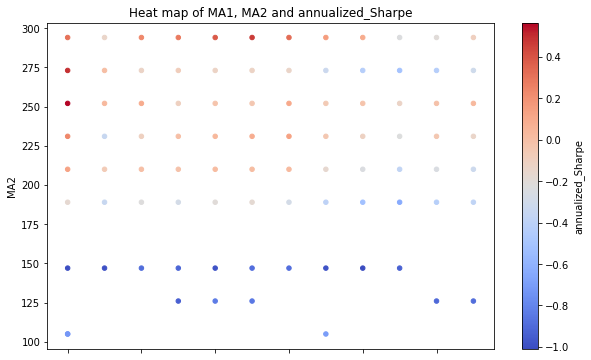

In [28]:
# Plot heat map of Sharpe ratio depending on MA1 and MA2
%matplotlib inline  
b= summary
b.plot.scatter(x='MA1', y ='MA2', c='annualized_Sharpe',cmap ='coolwarm', figsize = (10,6), colorbar = True)
plt.title('Heat map of MA1, MA2 and annualized_Sharpe')   
plt.show()

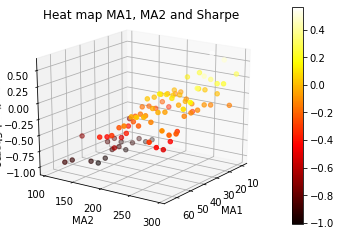

In [29]:
# Plot 3D heat map of Sharpe ratio depending on MA1 and MA2
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('MA1')
ax.set_ylabel('MA2')
ax.set_zlabel('annualized_Sharpe')
ax.set_title('Heat map MA1, MA2 and Sharpe')
ax.view_init(20, 35)
z = b['annualized_Sharpe']
c = b['annualized_Sharpe'] # set color to indicate annualized_Sharpe: the lighter the colour, the higher annualized_Sharpe 
x = b['MA1']
y = b['MA2']
img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

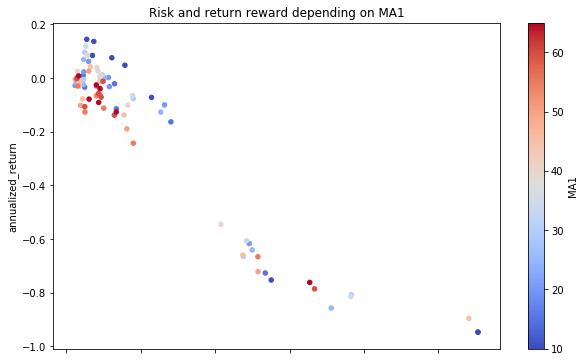

In [30]:
# How changes in MA1 affect risk and return

b.plot.scatter(y='annualized_return', x ='annualized_sd', c='MA1',cmap ='coolwarm', figsize = (10,6), colorbar = True)
plt.title('Risk and return reward depending on MA1')   
plt.show()

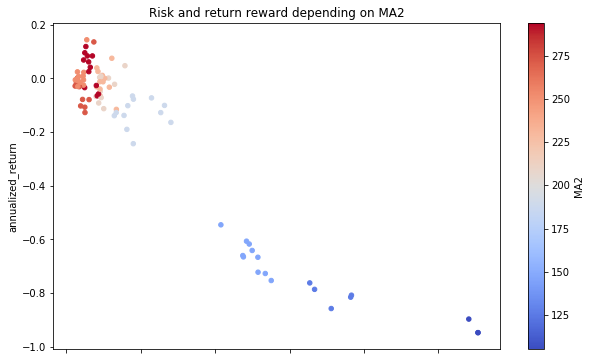

In [31]:
# How changes in  MA2 affect risk and return

b.plot.scatter(y='annualized_return', x ='annualized_sd', c='MA2',cmap ='coolwarm', figsize = (10,6), colorbar = True)
plt.title('Risk and return reward depending on MA2')   
plt.show()

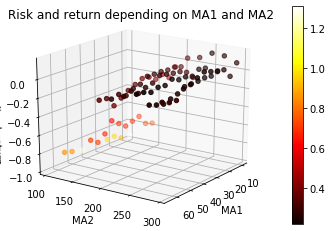

In [32]:
########## plot 3D Risk and return reward depending on MA1 and MA2
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('MA1')
ax.set_ylabel('MA2')
ax.set_zlabel('annualized_return')
ax.set_title('Risk and return depending on MA1 and MA2')
ax.view_init(20, 35)
z = b['annualized_return']
c = b['annualized_sd']
x = b['MA1']
y = b['MA2']


img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

# Note: I set colour to indicate annualized_sd: the lighter the colour, the higher annualized_sd

In [51]:
# Analyse the performance of max Sharpe case
def get_portfolio_return(data = data, MA1=5, MA2=210, initial_equity1 = 1000000, commission_fee1 = 0.002):
    individual_ret =[]
    valid_contracts = []
    for m in range (data.shape[1]-2):
        #print(m)
        price = data[['Time', str(m), 'regime']]
        price.columns =['Time', 'price', 'regime']
        price['log_ret'] =  price['price'].astype(float).pct_change()*100
        price['low'] = price['price'].rolling(MA1).mean() # 66
        price['high'] = price['price'].rolling(MA2).mean()
        price = price[np.isfinite(price['low'])]
        price = price[np.isfinite(price['high'])].reset_index().drop(columns = ['index'])
        price_minus_window = price
        price_minus_window ['position'] = np.where(price_minus_window['regime'] =='low', np.where(price_minus_window['price'] >= price_minus_window['low'],1, -1), np.where(price_minus_window['price'] >= price_minus_window['high'],1, -1))
        price_minus_window ['ret'] = price_minus_window ['position'].shift(1)* price_minus_window ['log_ret']/100
        sell_buy =[]
        for i in range (price_minus_window.shape[0]):
            if (i == 0):
                sell_buy.append('None')

            elif (i == 1):
                if (price_minus_window['position'].iloc[i]== 1):
                    sell_buy.append('buy')

                if (price_minus_window['position'].iloc[i]== -1):
                    sell_buy.append('sell')

            elif (i == price_minus_window.shape[0]-1):
                if (price_minus_window['position'].iloc[i]== 1):
                    sell_buy.append('sell')

                if (price_minus_window['position'].iloc[i]== -1):
                    sell_buy.append('buy')

            else:
                if (price_minus_window['position'].iloc[i-1]== 1) and (price_minus_window['position'].iloc[i]== -1):
                    sell_buy.append('sell')

                elif (price_minus_window['position'].iloc[i-1]== -1) and (price_minus_window['position'].iloc[i]== 1):
                    sell_buy.append('buy')

                else:
                    sell_buy.append('None')
        price_minus_window['sell_buy'] = sell_buy

        price_minus_window = price_minus_window [price_minus_window['ret']!=0]

        # ############# Modeling transaction cost using Bid-Ask Price data ###################################################

        # Data for transaction cost
        data_for_transaction_cost = price_minus_window[price_minus_window['sell_buy'].isin(['sell','buy'])].reset_index()
        data_for_transaction_cost = data_for_transaction_cost [['Time', 'sell_buy']]
        transaction_data = data_for_transaction_cost.merge(bid_ask, on='Time', how='left') 

        transaction_data1 =transaction_data[['Time','sell_buy', 'Bid_{}'.format(str(m)),'Ask_{}'.format(str(m))]]
        transaction_data1.columns = ['Time','sell_buy','bid','ask']

        # Calculate accumulate equity
        initial_equity = initial_equity1
        
        commission_fee = [commission_fee1]
        volume =[]
        equity =[]
        for i in range(transaction_data1.shape[0]): 

            if (i == 0):
                if (transaction_data1['sell_buy'].iloc[i]== "sell"):
                    equity0 = initial_equity
                    volume0 = initial_equity/float(transaction_data1['bid'].iloc[i])
                else:
                    equity0 = initial_equity
                    volume0 = initial_equity/float(transaction_data1['ask'].iloc[i])
                volume.append(volume0)
                equity.append(equity0)
            elif i == 1:

                if transaction_data1['sell_buy'].iloc[i]== "buy":
                    volume1 = equity[0]/float(transaction_data1['ask'].iloc[i])
                    equity1 = min(volume[0],volume1)*(float(transaction_data1['bid'].iloc[i-1])-float(transaction_data1['ask'].iloc[i]))+equity[i-1]
                else:
                    volume1 = equity[0]/float(transaction_data1['bid'].iloc[i])
                    equity1 = min(volume[0],volume1)*(float(transaction_data1['bid'].iloc[i])-float(transaction_data1['ask'].iloc[i-1]))+equity[i-1]
                volume.append(volume1)
                equity.append(equity1)
            else:
                if equity[i-1] == equity[i-2]:
                    if transaction_data1['sell_buy'].iloc[i]== "buy":
                        volume2 = equity[i-1]/float(transaction_data1['ask'].iloc[i])
                        equity2 = min(volume[i-1],volume2)*(float(transaction_data1['bid'].iloc[i-1])-float(transaction_data1['ask'].iloc[i]))+equity[i-1]
                    else:
                        volume2 = equity[i-1]/float(transaction_data1['bid'].iloc[i])
                        equity2 = min(volume[i-1],volume2)*(float(transaction_data1['bid'].iloc[i])-float(transaction_data1['ask'].iloc[i-1]))+equity[i-1]
                    volume.append(volume2)
                    equity.append(equity2)
                else:
                    equity2 = equity[i-1]
                    if transaction_data1['sell_buy'].iloc[i]== "sell":
                        volume2 = equity[i-1]/float(transaction_data1['bid'].iloc[i])
                    else:
                        volume2 = equity[i-1]/float(transaction_data1['ask'].iloc[i])

                    volume.append(volume2)
                    equity.append(equity2)

        transaction_data1 ['volume'] = volume
        transaction_data1 ['accumulate equity'] = equity
        # Take into aacount the effect of comission fee
        transaction_data1 ['commission_index'] = range(transaction_data1.shape[0])
        transaction_data1 ['commission_fee'] = commission_fee* transaction_data1.shape[0]
        transaction_data1 ['accum_commission_fee'] = transaction_data1 ['commission_index']*transaction_data1 ['commission_fee']
        transaction_data1 ['accum_equity_after_comm'] = transaction_data1 ['accumulate equity'] - transaction_data1 ['accum_commission_fee'] 
        transaction_data1.drop(columns =['commission_index', 'commission_fee'], inplace = True)
        print("Number of transactions in contract ", m, " is ", transaction_data1.shape [0])
        # Put accumulate equity into price_minus_window data frame 
        price_minus_window = price_minus_window.merge(transaction_data1[['Time','accum_equity_after_comm']], on = 'Time', how = 'left')
        price_minus_window1 = price_minus_window[['Time', 'accum_equity_after_comm']]
        price_minus_window1.ffill(inplace = True)
        price_minus_window1 ['accum_equity_after_comm'].iloc[0]= price_minus_window1 ['accum_equity_after_comm'].iloc[1]
        price_minus_window['accum_equity_after_comm'] = price_minus_window1['accum_equity_after_comm'] 
        valid_contracts.append(m)
        individual_ret.append(price_minus_window[['Time','accum_equity_after_comm']])
        
    ### Collect the returns columns of each contract and merger them tegether based on 'Time' columns
    port_ret =pd.DataFrame(individual_ret[0])  
    for i in range(1,len(individual_ret),1): # i = 1
        port_ret = port_ret.merge(pd.DataFrame(individual_ret[i]),on='Time', how='outer')
    ### Create the name for columns in port_ret dataframe 
    column1 = valid_contracts.copy()
    column1.insert(0,'Time')
    port_ret.columns = column1
    port_ret.ffill(inplace = True)
    port_ret.fillna(initial_equity, inplace=True)
    port_ret['Total Ret'] = port_ret.sum(axis=1)
    port_ret1 = port_ret.set_index('Time')

    port_ret1['ret'] =  port_ret1['Total Ret'].astype(float).pct_change()*100
    port_ret1

    winning_percentage = len(port_ret1[port_ret1['ret']>0])/len(port_ret1)

    port_ret1['Cum_ret'] = (1+port_ret1['ret']).cumprod() -1 
    avg_annualized_return = (1+port_ret1['Cum_ret'].iloc[-1])**(252/port_ret1.shape[0])-1

    print('Average annualized daily return of portfolio is', avg_annualized_return,'%')
    # standard deviation
    annualized_standard_deviation = port_ret1['ret'].std()*np.sqrt(252)
    print('Annualized standard deviation return of portfolio is', annualized_standard_deviation, '%')
    # sharpe ratio
    annualized_sharpe = avg_annualized_return/annualized_standard_deviation
    annualized_sharpe 
    print('Annualized_sharpe ratio of portfolio is: ', annualized_sharpe )

    # Maximum draw down
    max_draw_down = max(-drawdown(port_ret1['ret'].dropna()))
    print('Maximum draw down of portfolio is: ', max_draw_down )
    # port_ret.to_csv ('port_ret.csv', index = False, header=True)
    summary_port = pd.DataFrame({'Start':port_ret['Time'].iloc[0] ,'Finish':port_ret['Time'].iloc[-1],'MA1': MA1,'MA2': MA2,'annualized_return': avg_annualized_return, 'annualized_sd': annualized_standard_deviation,
                                 'annualized_Sharpe': annualized_sharpe,'max_draw_down': max_draw_down,'winning_percentage': winning_percentage }, index=[0])
    return port_ret1

port_ret1 = get_portfolio_return(data = data, MA1=10, MA2=252, initial_equity1 = 1000000, commission_fee1 = 0.002)

Number of transactions in contract  0  is  4
Number of transactions in contract  1  is  4
Number of transactions in contract  2  is  11
Number of transactions in contract  3  is  13
Number of transactions in contract  4  is  3
Number of transactions in contract  5  is  2
Number of transactions in contract  6  is  2
Number of transactions in contract  7  is  12
Number of transactions in contract  8  is  14
Number of transactions in contract  9  is  4
Number of transactions in contract  10  is  4
Number of transactions in contract  11  is  4
Number of transactions in contract  12  is  4
Number of transactions in contract  13  is  5
Number of transactions in contract  14  is  11
Number of transactions in contract  15  is  8
Number of transactions in contract  16  is  6
Number of transactions in contract  17  is  4
Number of transactions in contract  18  is  6
Number of transactions in contract  19  is  2
Number of transactions in contract  20  is  10
Number of transactions in contract  21

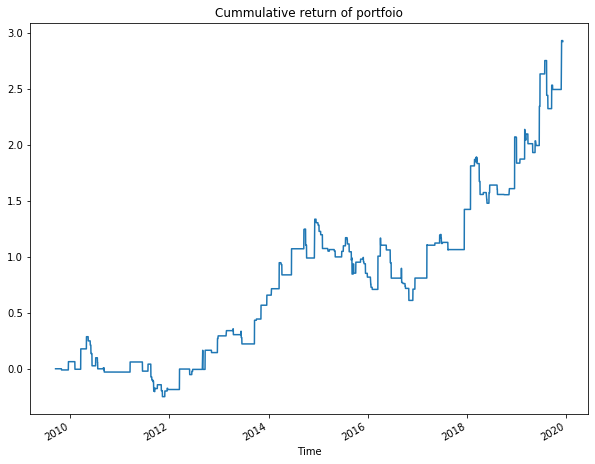

In [47]:
# Show the cummulative return
port_ret1['Cum_ret'].plot(figsize=(10,8))
plt.title('Cummulative return of portfoio')
plt.show()

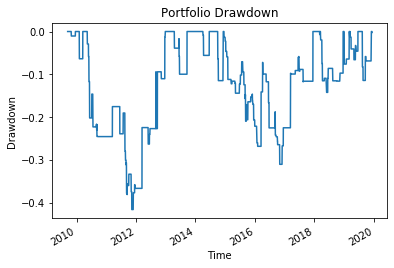

In [48]:
# Exhibit 8 : Portfolio drawdown overtime. 

import matplotlib.pyplot as plt 
drawdown(port_ret1['ret']).plot() 
plt.title('Portfolio Drawdown') 
plt.xlabel('Time') 
plt.ylabel('Drawdown') 
plt.show()

In [49]:
# Exhibit_6: Out of sample performance summary 
port_return =pd.DataFrame(port_ret1['ret']) 
port_return.index = pd.to_datetime(port_return.index) 
port_return['Year'] = port_return.index.year
ret1 = [] 
vol1 =[] 
sharpe1=[] 
sortino1=[] 
max_drawdown1=[] 
year1 = [] 
for year in list(np.unique(port_return['Year'])): # year = 2014    
    return_year = port_return[port_return['Year']==year]    
    return_year['Cum_ret'] = (1+return_year['ret']).cumprod() -1     
    a_ret = (1+return_year['Cum_ret'].iloc[-1])**(252/return_year['Cum_ret'].shape[0])-1 # annualize    
    ret1.append(a_ret)    
    a_vol = return_year['ret'].std()*252**0.5    
    vol1.append(a_vol) #252**0.5*sharpe    
    sharpe1.append(a_ret/a_vol)    
    max_drawdown1.append(max(-drawdown(return_year['ret'])))    
    year1.append(year)    
    # Need a short rate to calculate the sortino 
exhibit_6 = pd.DataFrame(list(zip(year1,ret1, vol1,sharpe1, max_drawdown1)),
                        columns =['Year','Annualize_return','Annualize_volatility','Annualize_sharpe', 'MaxDrawdown']) 
exhibit_6

Year  Annualize_return  Annualize_volatility  Annualize_sharpe  \
0   2009          0.219752              0.136759          1.606855   
1   2010         -0.087801              0.269921         -0.325285   
2   2011         -0.163455              0.261814         -0.624317   
3   2012          0.603147              0.312354          1.930971   
4   2013          0.282557              0.218975          1.290363   
5   2014          0.399546              0.289733          1.379014   
6   2015         -0.212352              0.160407         -1.323833   
7   2016         -0.004651              0.264983         -0.017551   
8   2017          0.343559              0.246524          1.393614   
9   2018          0.270700              0.260584          1.038822   
10  2019          0.294662              0.261500          1.126813   

    MaxDrawdown  
0           NaN  
1      0.245721  
2      0.292011  
3      0.049694  
4      0.099840  
5      0.114873  
6      0.203402  
7      0.256936  
8      0.062849  
9      0.142350  
10     0.114413

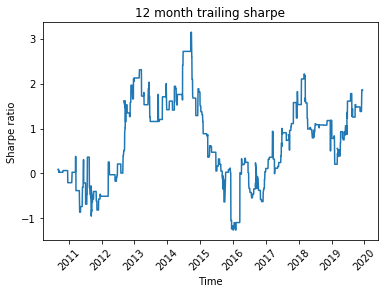

In [50]:
# Exhibit 7: 12 month trailing sharpe 
port_return['12M_Sharpe'] = (((1+port_return['ret'].rolling(252).mean())**252)-1)/(port_return['ret'].rolling(252).std()*252**0.5)

import matplotlib.pyplot as plt
plt.plot(port_return['12M_Sharpe']) 
plt.xticks(rotation=45) 
plt.xlabel('Time') 
plt.ylabel('Sharpe ratio') 
plt.title('12 month trailing sharpe') 
plt.show()